# **Introduction**


In this notebook we will analyze the "cs448b_ipasn" dataset which includes some network traffic data.

We will explore time series of communication between local computers (l_ipn) and remote resources (r_asn).

The dataset has approximately 21K rows and covers 10 local workstation IPs over a three month period.

Each row consists of four columns:
*   date: yyyy-mm-dd (from 2006-07-01 through 2006-09-30)
*   l_ipn: local IP (coded as an integer from 0-9)
*   r_asn: remote ASN (an integer which identifies the remote ISP)
*   f: flows (count of connnections for that day)


We will perform anomaly detection using different machine learning algorithms in order to understand if there have been any attacks or any anomalous behavior.

# Import libraries and Drive

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import to_datetime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Exploration

In [2]:
# Load your time series dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Ferri/cs448b_ipasn.csv')

In [3]:
print('dataframe shape {} '.format(df.shape))

dataframe shape (20803, 4) 


In [4]:
df.head()

date  l_ipn  r_asn  f
0  2006-07-01      0    701  1
1  2006-07-01      0    714  1
2  2006-07-01      0   1239  1
3  2006-07-01      0   1680  1
4  2006-07-01      0   2514  1

Each row of the dataset shows the number of connections between l_ipn and r_asn on a day.

For example row 0 in dataset says on date 2006-07-01 l_ipn 0 and r_asn 701 have had one flow, similarly row 6 indicate there have been 13 flows or connections between l_ipn 0 and r_asn 3561.

Let's look at some brief descriptive statistics and clean up missing data.

In [ ]:
print('Unique local ip: {:d}'.format(df['l_ipn'].nunique()))
print('Unique remote ASN: {:d}'.format(df['r_asn'].nunique()))
print('Minimum flow count per day: {:d}'.format(df['f'].min()))
print('Maximum flow count per day: {:d}'.format(df['f'].max()))

Unique local ip: 10
Unique remote ASN: 2005
Minimum flow count per day: 1
Maximum flow count per day: 784234


In [ ]:
# Missing or NAN values in dataset
df.isnull().sum()

date     0
l_ipn    0
r_asn    0
f        0
dtype: int64

In order to understand connections represented in the dataset, let's look at the flows aggregated across all l_ipn for each day.

In [ ]:
# Aggregating daily connections
daily_aggregate = df.groupby(['date'])[['f']].sum()
daily_aggregate.reset_index(inplace = True)

In [ ]:
daily_aggregate[['f']].describe()

f
count      92.000000
mean    21235.847826
std     85752.692609
min      2706.000000
25%      5211.750000
50%      8773.500000
75%     12426.000000
max    788297.000000

In [ ]:
daily_mean = round(daily_aggregate['f'].mean(),2)

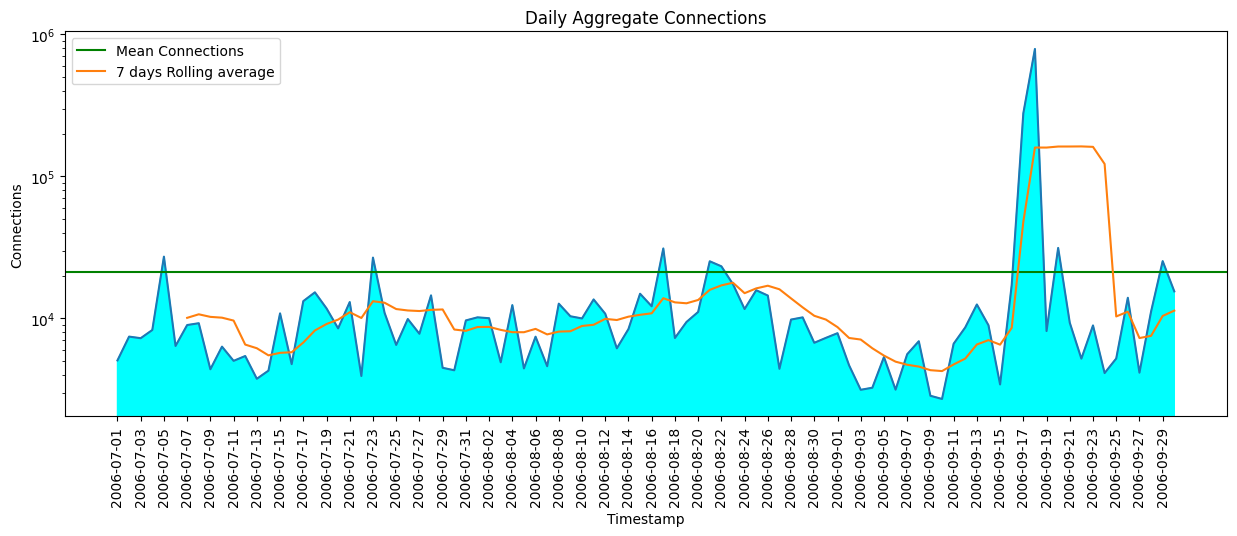

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(daily_aggregate['date'],daily_aggregate['f'])
plt.axhline(y= daily_mean, color='g', label = 'Mean Connections')
plt.plot(daily_aggregate['date'],daily_aggregate['f'].rolling(7).mean(), label = '7 days Rolling average')
plt.xticks(daily_aggregate['date'][::2],  rotation='vertical')
plt.yscale('log')
plt.xlabel('Timestamp')
plt.ylabel('Connections')
plt.title('Daily Aggregate Connections')
plt.fill_between(daily_aggregate['date'],daily_aggregate['f'],color='aqua')
plt.legend()
plt.show()

Let's look at the daily connections of all l_ipn

In [ ]:
daily_aggregate_l_ipn = df.groupby(['l_ipn','date'])[['f']].sum()
daily_aggregate_l_ipn.reset_index(inplace= True)

daily_aggregate_l_ipn

l_ipn        date     f
0        0  2006-07-01   106
1        0  2006-07-02   920
2        0  2006-07-03   249
3        0  2006-07-04  2971
4        0  2006-07-05   158
..     ...         ...   ...
842      9  2006-09-26  1330
843      9  2006-09-27    97
844      9  2006-09-28   983
845      9  2006-09-29     5
846      9  2006-09-30     4

[847 rows x 3 columns]

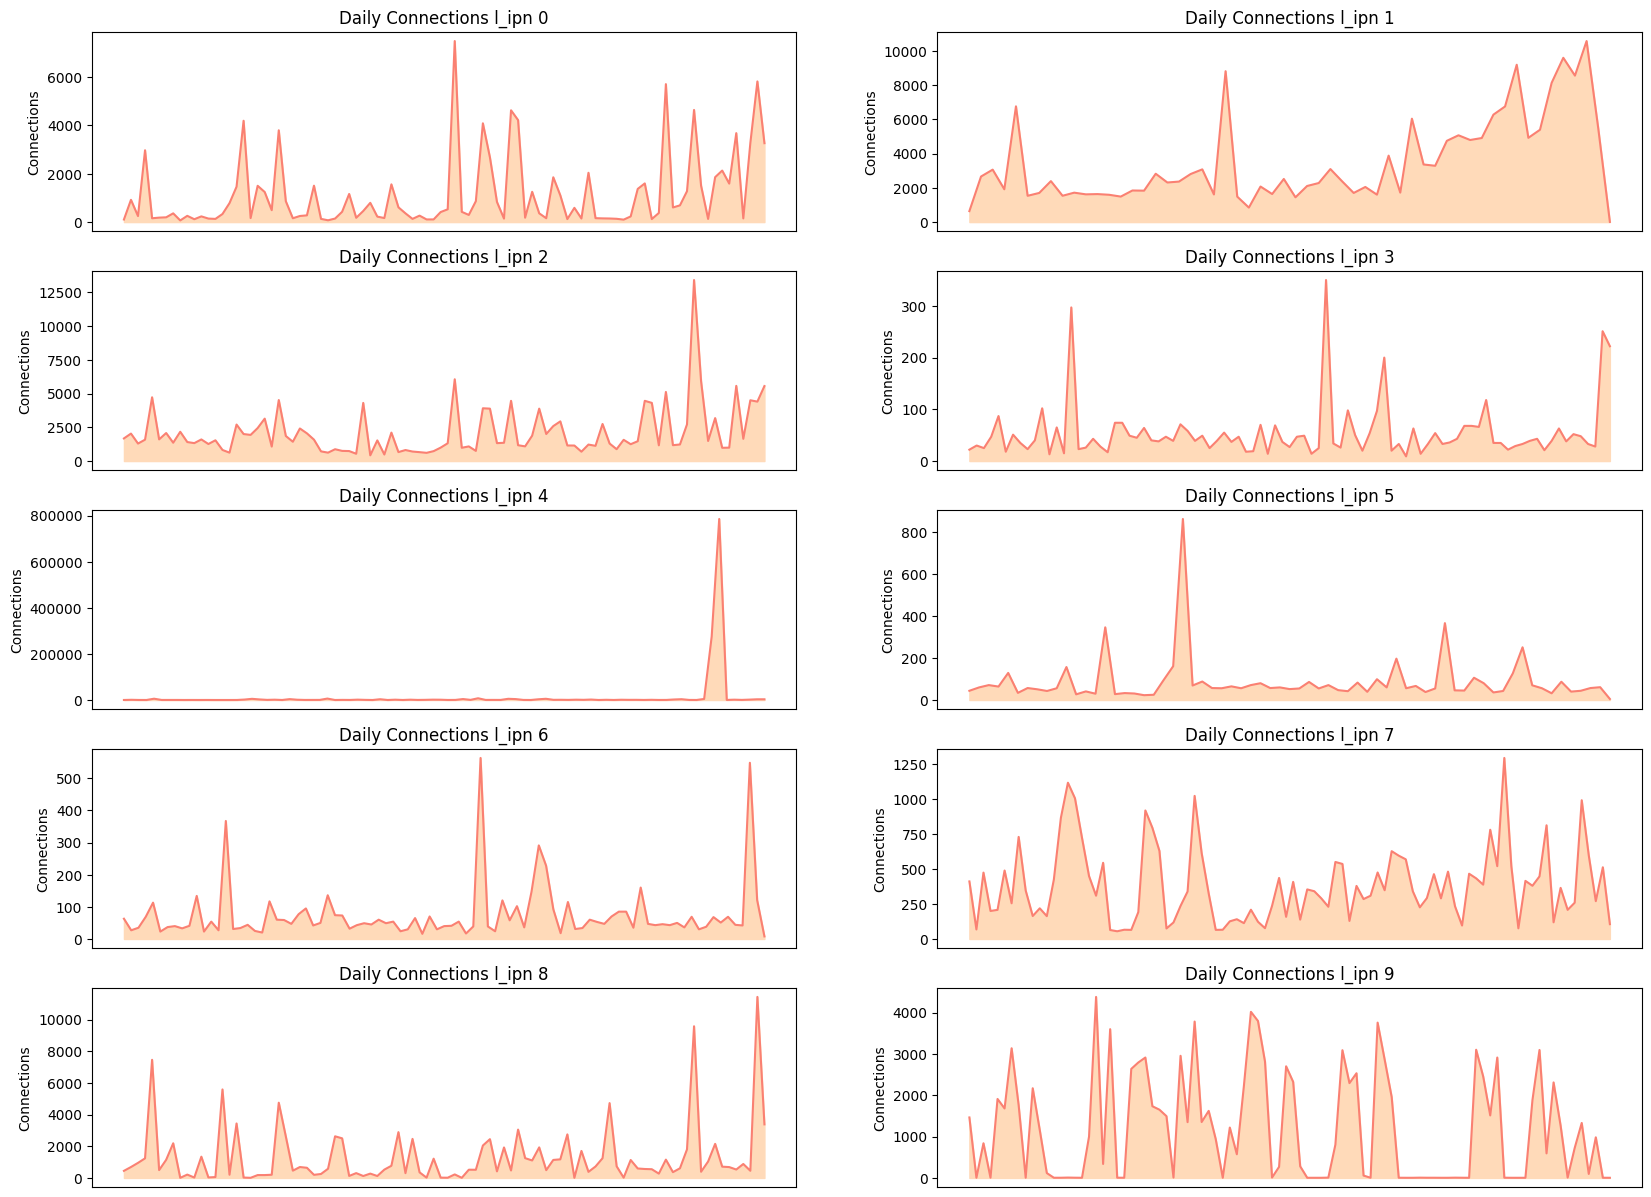

In [ ]:
import matplotlib.dates as mdates

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 15))

plot_row = 0
plot_col = 0

for i in range(df['l_ipn'].nunique()):

    temp = daily_aggregate_l_ipn[daily_aggregate_l_ipn['l_ipn'] == i]
    axes[plot_row,plot_col].set_title('Daily Connections l_ipn %i' %i)
    axes[plot_row,plot_col].set_xlabel('Timestamp')
    axes[plot_row,plot_col].set_ylabel('Connections')

    axes[plot_row,plot_col].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    axes[plot_row,plot_col].plot(temp['date'],temp['f'], color = 'salmon')
    axes[plot_row,plot_col].get_xaxis().set_visible(False)
    axes[plot_row,plot_col].fill_between(temp['date'],temp['f'], color='peachpuff')


    plot_col = plot_col + 1

    if(plot_col == 2):
        plot_row = plot_row + 1
        plot_col = 0

plt.show()

# Data Preparation

In [ ]:
def get_daily_aggregate_l_ipn(in_l_ipn):

    temp_df = daily_aggregate_l_ipn[daily_aggregate_l_ipn['l_ipn'] == in_l_ipn].drop(['l_ipn'],axis = 1)
    temp_df.columns = ['date','flows']
    temp_df['date'] = to_datetime(temp_df['date'])
    temp_df.reset_index(inplace=True,drop=True)

    return temp_df

Example of daily_aggregate_l_ipn

In [ ]:
da0 = get_daily_aggregate_l_ipn(0) # Daily aggregation for station l_ipn 0, date - flows
da0.head()

date  flows
0 2006-07-01    106
1 2006-07-02    920
2 2006-07-03    249
3 2006-07-04   2971
4 2006-07-05    158

# Z-Score

In [ ]:
def z_score(data):

    timestamp_column = 'date'
    value_column = 'flows'

    # Calculate Z-Score
    mean_value = data[value_column].mean()
    std_dev_value = data[value_column].std()
    data['z_score'] = (data[value_column] - mean_value) / std_dev_value

    # Set a threshold for anomaly detection
    threshold = 2.5

    # Identify anomalies based on the threshold
    anomalies = data[np.abs(data['z_score']) > threshold]

    # Visualize anomalies
    plt.figure(figsize=(12, 6))
    plt.plot(data[timestamp_column], data[value_column], label='Original Data', color='blue')
    plt.scatter(anomalies[timestamp_column], anomalies[value_column], label='Anomalies', color='red')
    plt.axhline(y=mean_value + threshold * std_dev_value, color='orange', linestyle='--', label='Upper Threshold')
    plt.axhline(y=mean_value - threshold * std_dev_value, color='orange', linestyle='--', label='Lower Threshold')
    plt.title('Anomaly Detection Z-Score l_ipn %i' %i)
    plt.xlabel('Timestamp')
    plt.ylabel('Connections')
    plt.legend()
    plt.show()

    # Display details of anomaly points
    print("Anomaly Points:")
    print(anomalies)

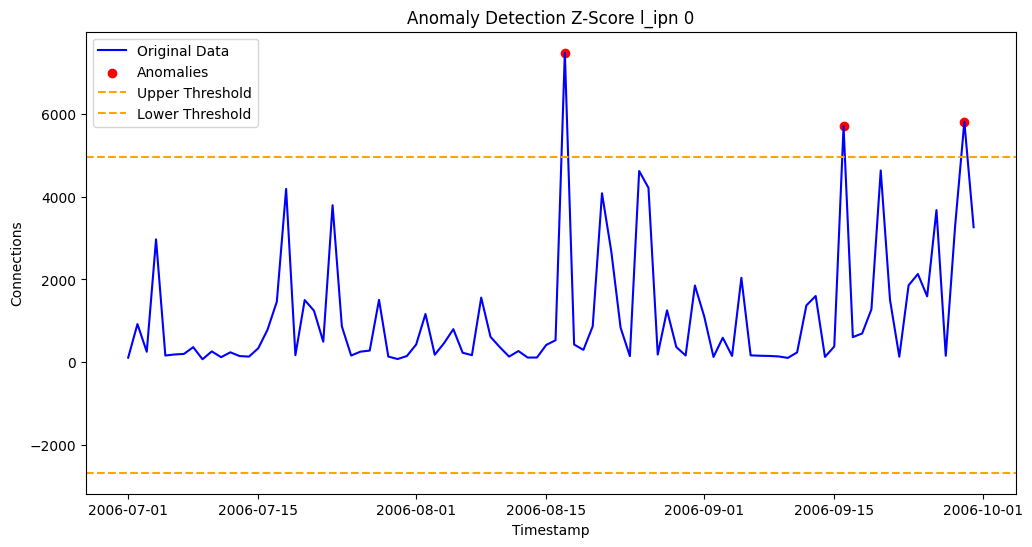

Anomaly Points:
         date  flows   z_score
47 2006-08-17   7488  4.150264
77 2006-09-16   5706  2.984616
90 2006-09-29   5818  3.057878


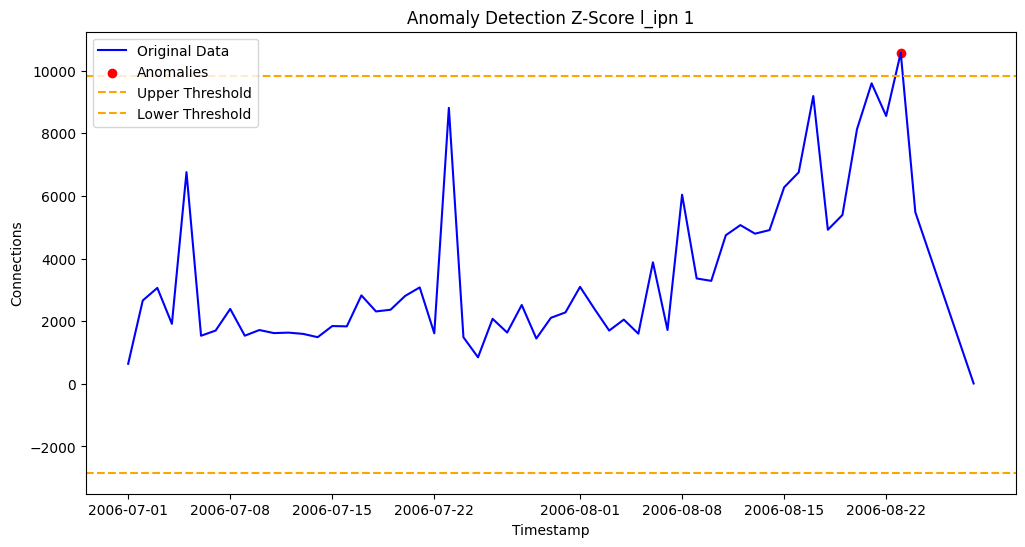

Anomaly Points:
         date  flows   z_score
53 2006-08-23  10574  2.794476


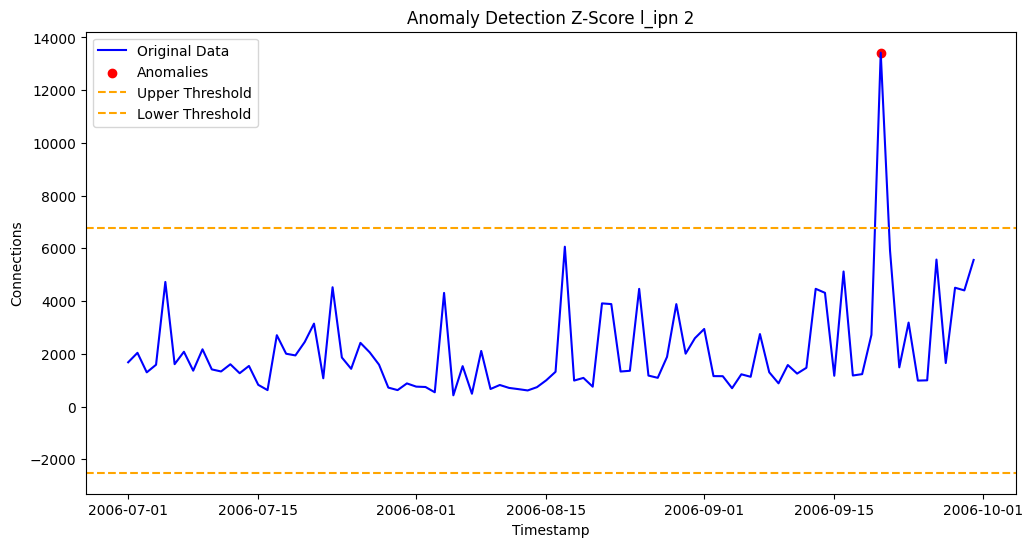

Anomaly Points:
         date  flows   z_score
81 2006-09-20  13421  6.085737


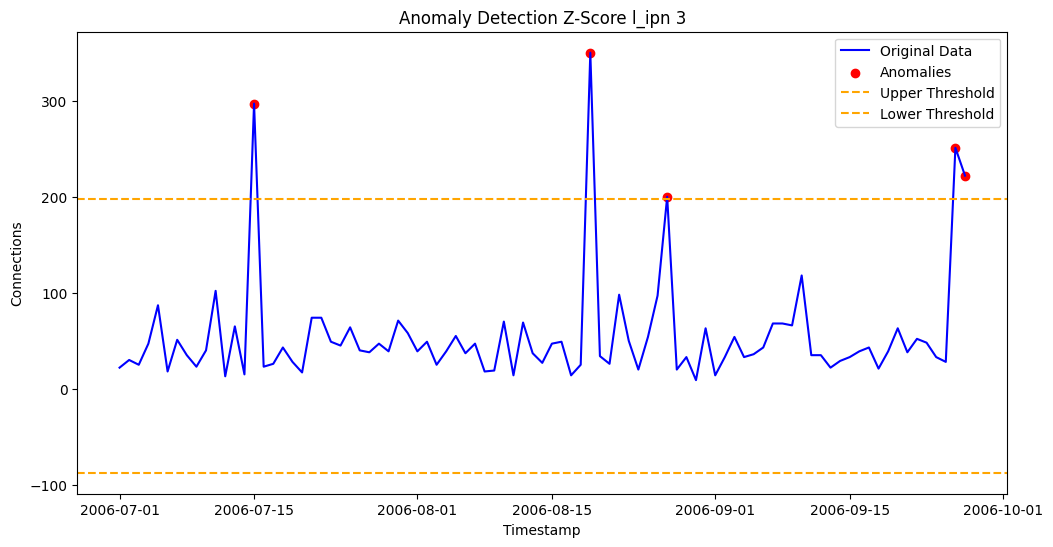

Anomaly Points:
         date  flows   z_score
14 2006-07-15    297  4.242875
49 2006-08-19    350  5.172488
57 2006-08-27    200  2.541507
87 2006-09-26    251  3.436041
88 2006-09-27    222  2.927385


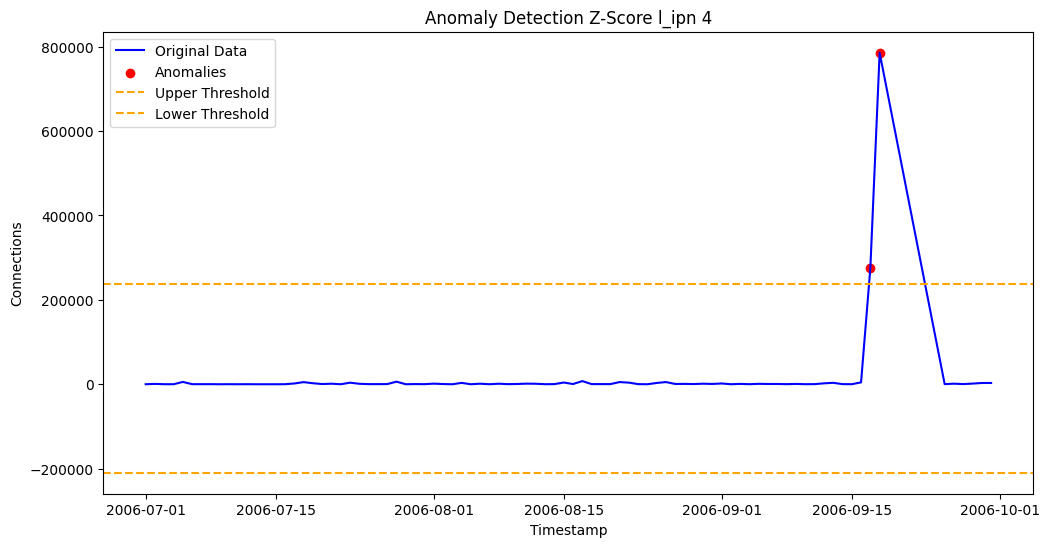

Anomaly Points:
         date   flows   z_score
78 2006-09-17  275140  2.930434
79 2006-09-18  785297  8.647983


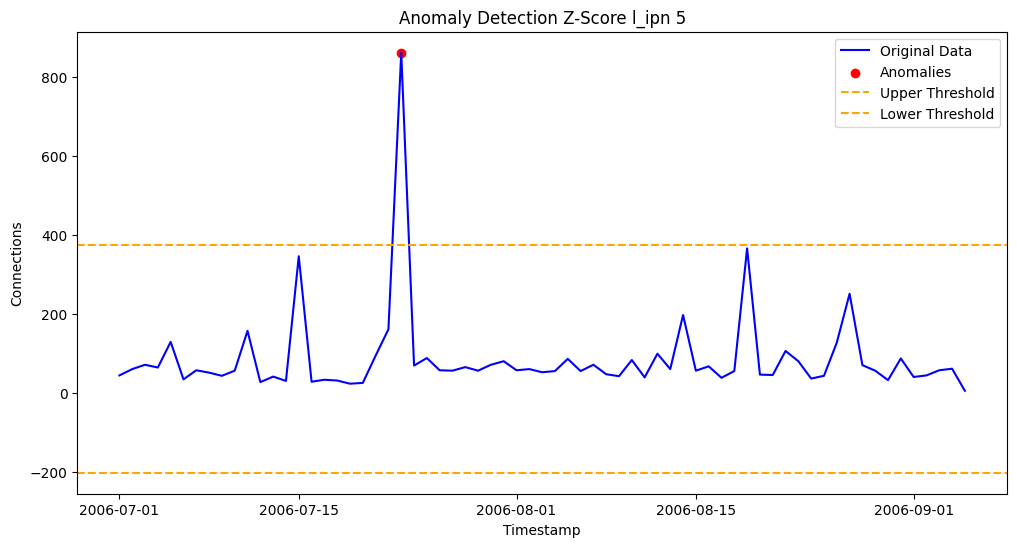

Anomaly Points:
         date  flows   z_score
22 2006-07-23    862  6.711463


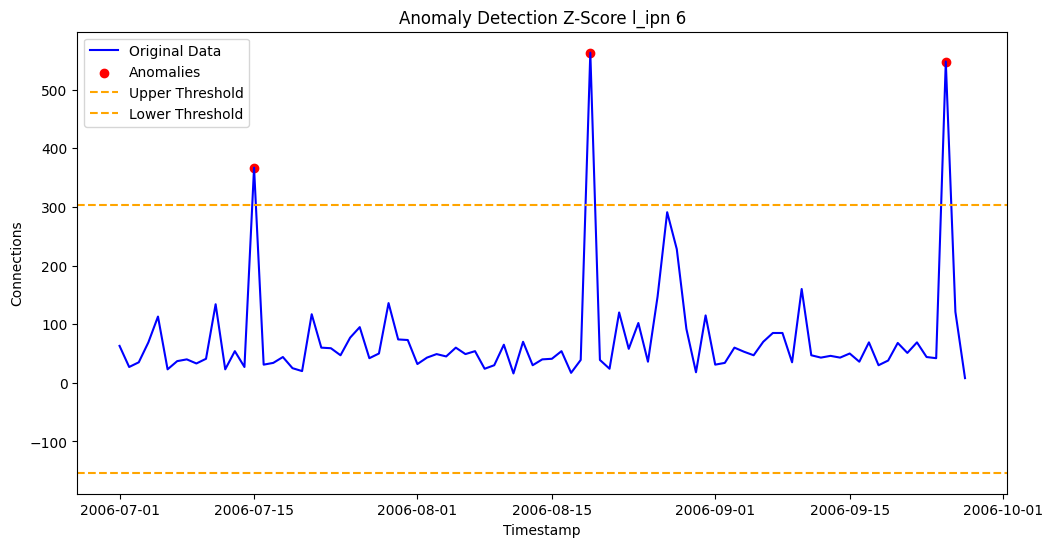

Anomaly Points:
         date  flows   z_score
14 2006-07-15    367  3.197442
49 2006-08-19    563  5.343587
86 2006-09-25    548  5.179341


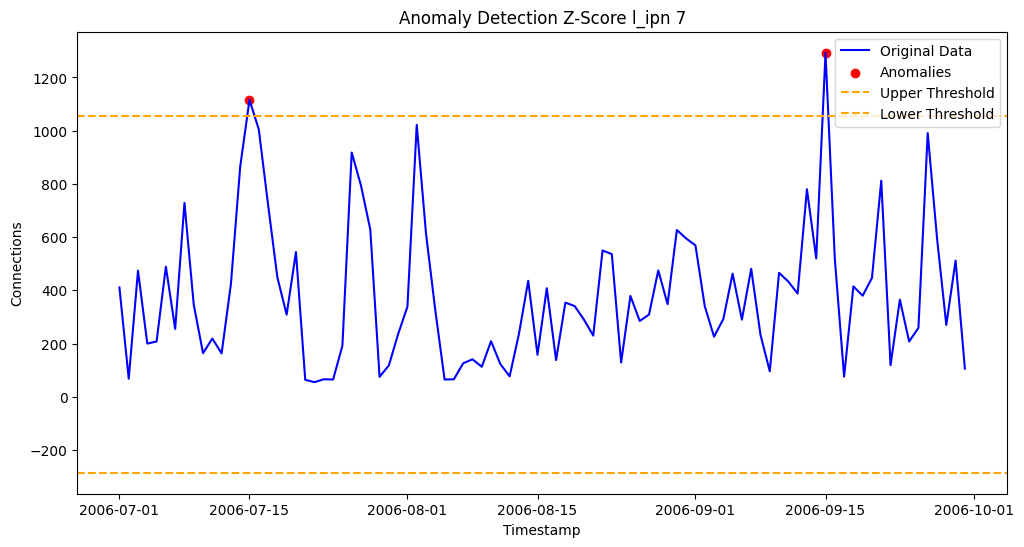

Anomaly Points:
         date  flows   z_score
14 2006-07-15   1116  2.731701
76 2006-09-15   1293  3.392569


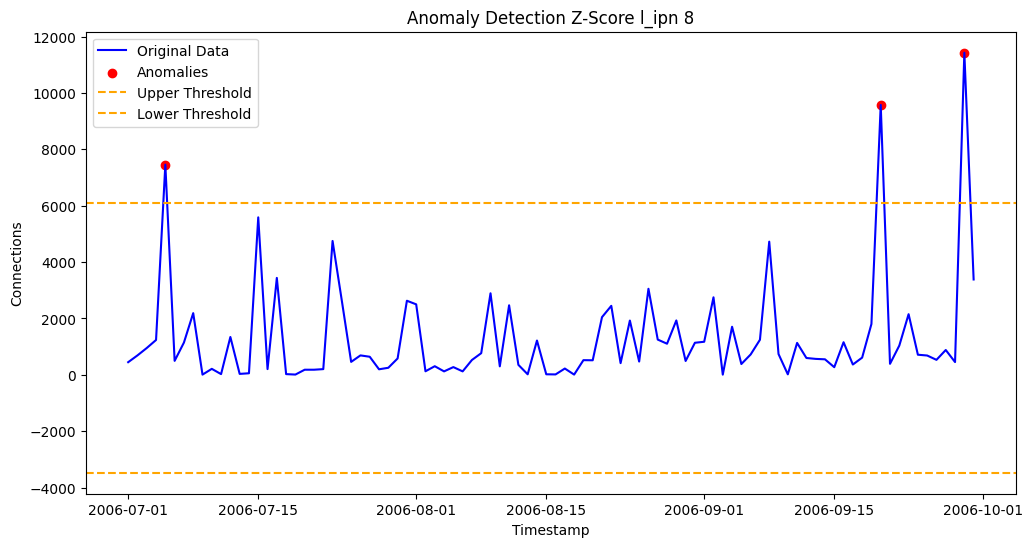

Anomaly Points:
         date  flows   z_score
4  2006-07-05   7456  3.216539
81 2006-09-20   9573  4.323861
90 2006-09-29  11426  5.293094


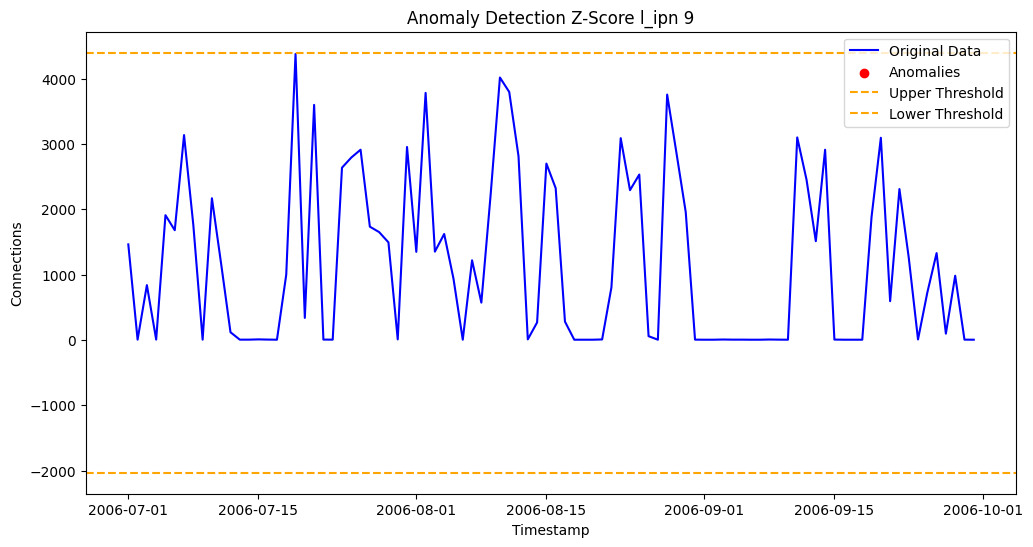

Anomaly Points:
Empty DataFrame
Columns: [date, flows, z_score]
Index: []


In [ ]:
for i in range(df['l_ipn'].nunique()):
    z_score(get_daily_aggregate_l_ipn(i))

# MAD

In [ ]:
def perform_mad(data):

    timestamp_column = 'date'
    value_column = 'flows'

    # Calculate the median and MAD (Median Absolute Deviation)
    median_value = data[value_column].median()
    mad = np.median(np.abs(data[value_column] - median_value))

    # Set a threshold for anomaly detection
    threshold = 7 * mad

    # Identify anomalies based on the threshold
    anomalies = data[np.abs(data[value_column] - median_value) > threshold]

    # Visualize anomalies
    plt.figure(figsize=(12, 6))
    plt.plot(data[timestamp_column], data[value_column], label='Original Data', color='blue')
    plt.scatter(anomalies[timestamp_column], anomalies[value_column], label='Anomalies', color='red')
    plt.axhline(y=median_value, color='green', linestyle='--', label='Median')
    plt.axhline(y=median_value + threshold, color='orange', linestyle='--', label='Upper Threshold')
    plt.axhline(y=median_value - threshold, color='orange', linestyle='--', label='Lower Threshold')
    plt.title('Anomaly Detection MAD l_ipn %i' %i)
    plt.xlabel('Timestamp')
    plt.ylabel('Connections')
    plt.legend()
    plt.show()

    # Display details of anomaly points
    print("Anomaly Points:")
    print(anomalies)

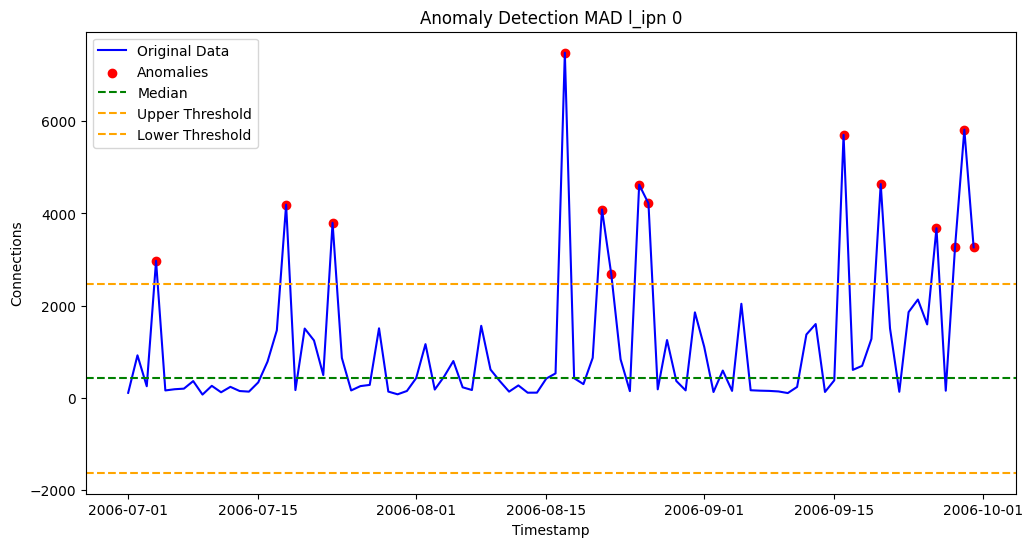

Anomaly Points:
         date  flows
3  2006-07-04   2971
17 2006-07-18   4191
22 2006-07-23   3797
47 2006-08-17   7488
51 2006-08-21   4085
52 2006-08-22   2677
55 2006-08-25   4624
56 2006-08-26   4218
77 2006-09-16   5706
81 2006-09-20   4638
87 2006-09-26   3679
89 2006-09-28   3270
90 2006-09-29   5818
91 2006-09-30   3264


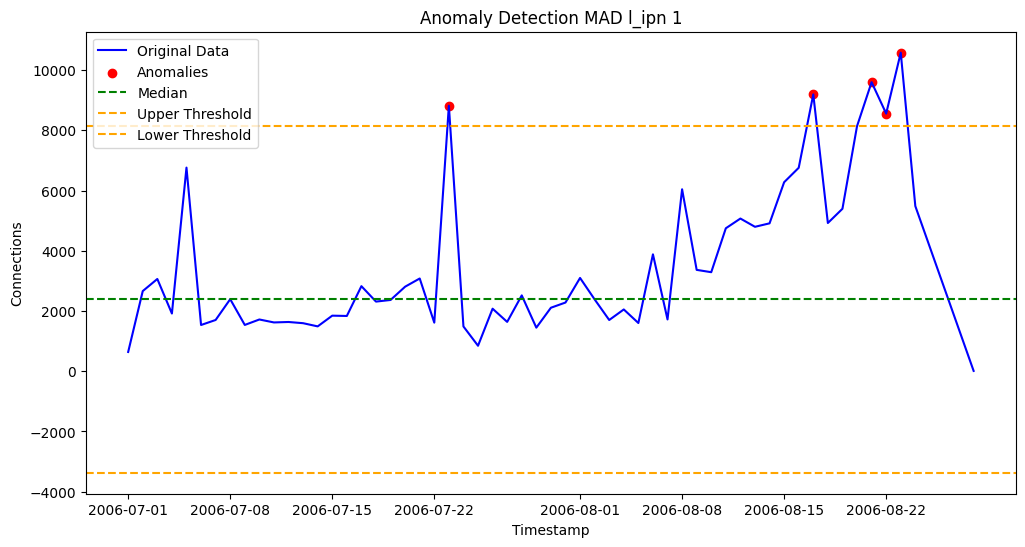

Anomaly Points:
         date  flows
22 2006-07-23   8813
47 2006-08-17   9190
51 2006-08-21   9596
52 2006-08-22   8554
53 2006-08-23  10574


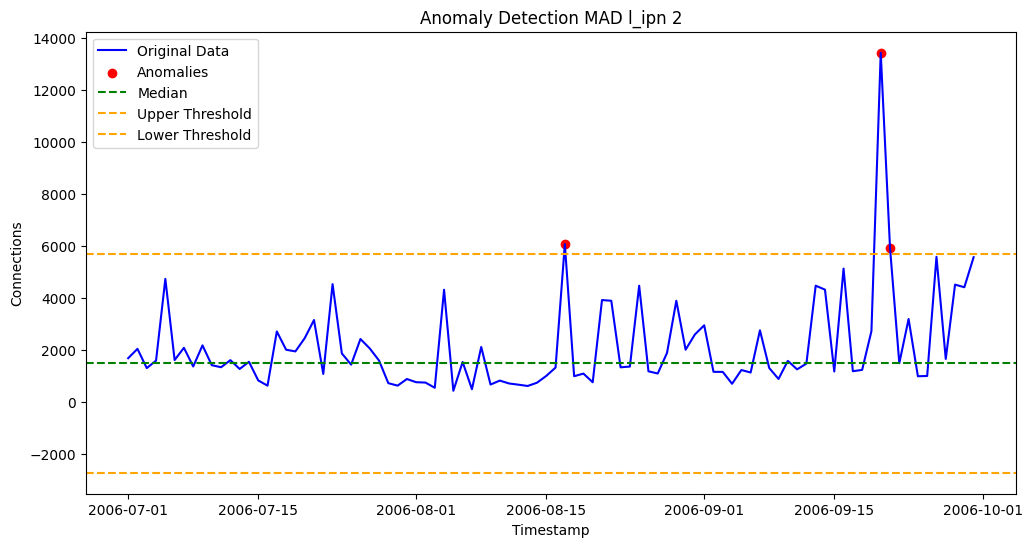

Anomaly Points:
         date  flows
47 2006-08-17   6062
81 2006-09-20  13421
82 2006-09-21   5920


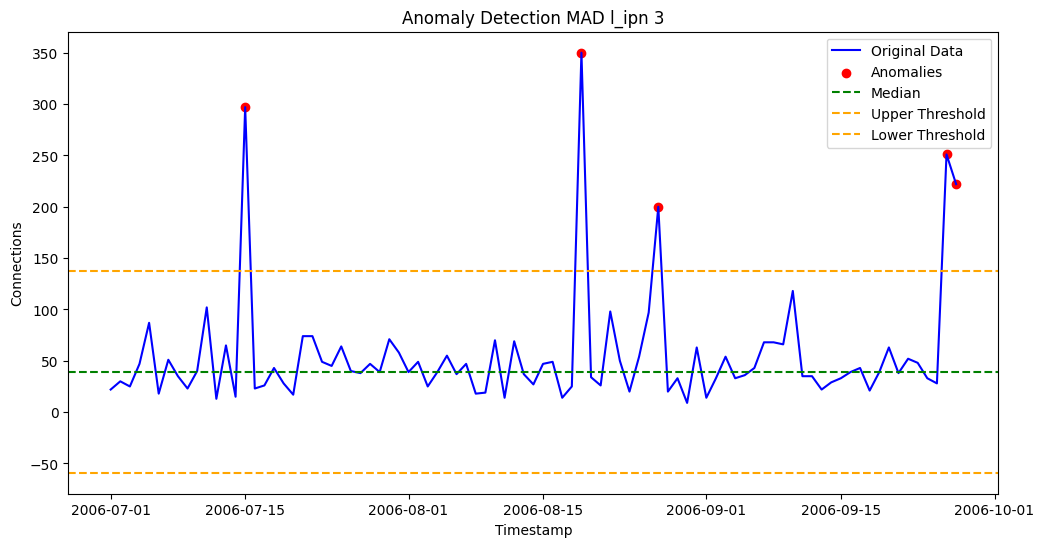

Anomaly Points:
         date  flows
14 2006-07-15    297
49 2006-08-19    350
57 2006-08-27    200
87 2006-09-26    251
88 2006-09-27    222


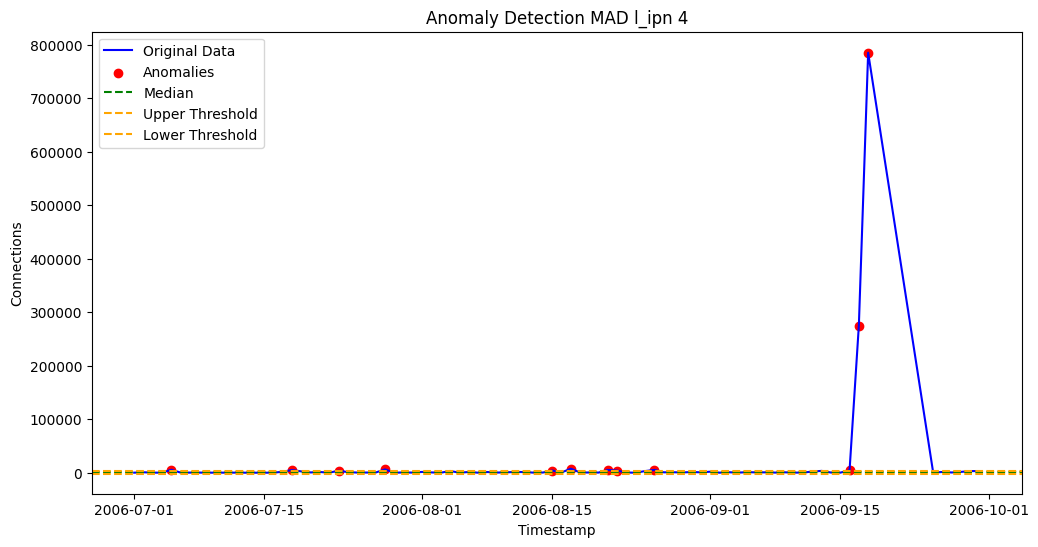

Anomaly Points:
         date   flows
4  2006-07-05    5643
17 2006-07-18    5147
22 2006-07-23    3846
27 2006-07-28    6265
45 2006-08-15    4194
47 2006-08-17    7593
51 2006-08-21    5246
52 2006-08-22    4005
56 2006-08-26    5310
77 2006-09-16    4539
78 2006-09-17  275140
79 2006-09-18  785297


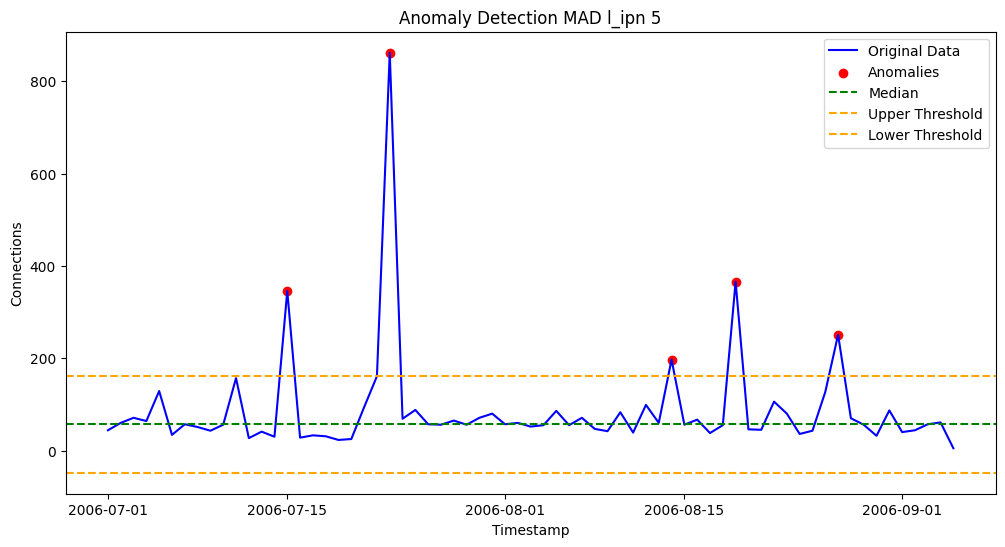

Anomaly Points:
         date  flows
14 2006-07-15    346
22 2006-07-23    862
44 2006-08-14    197
49 2006-08-19    366
57 2006-08-27    251


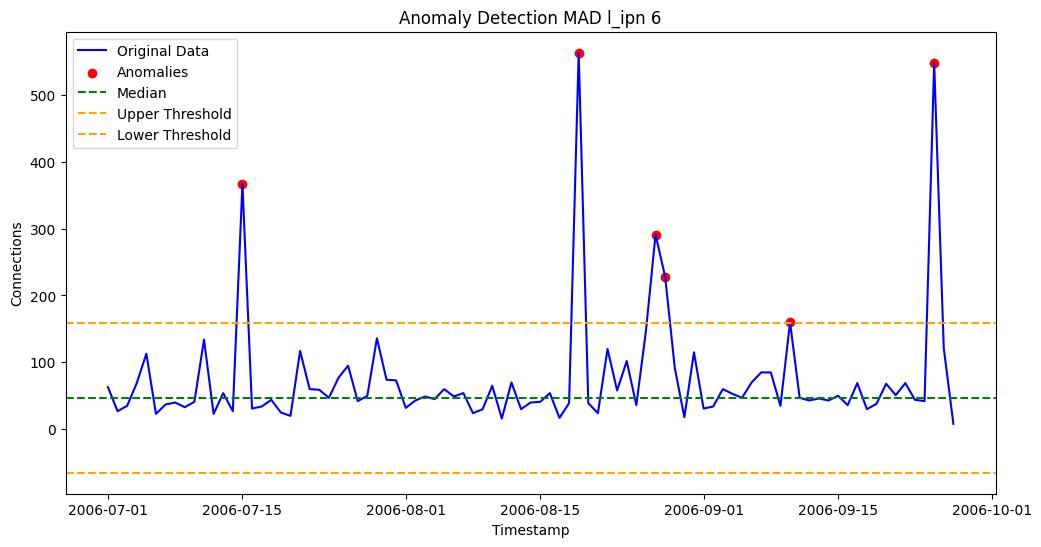

Anomaly Points:
         date  flows
14 2006-07-15    367
49 2006-08-19    563
57 2006-08-27    291
58 2006-08-28    228
71 2006-09-10    160
86 2006-09-25    548


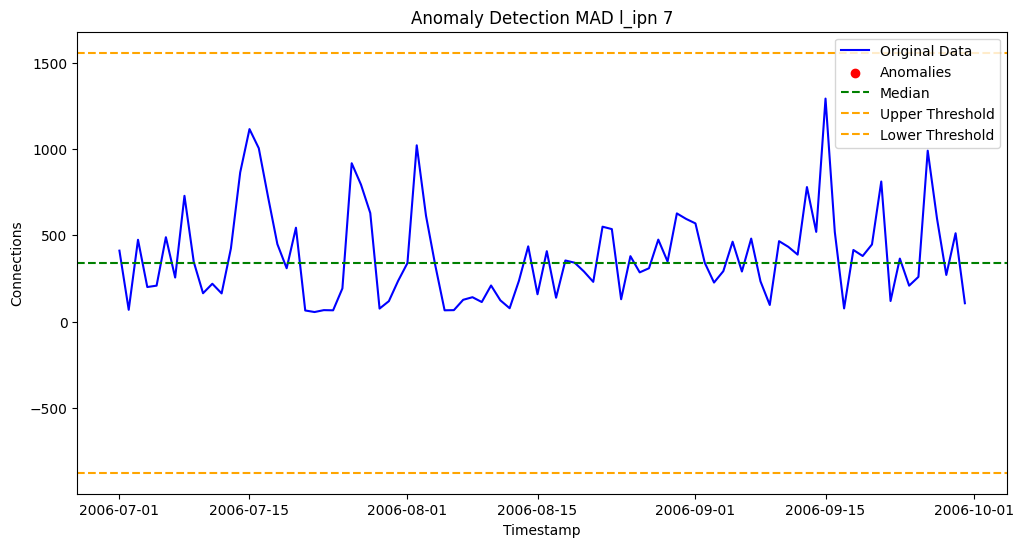

Anomaly Points:
Empty DataFrame
Columns: [date, flows]
Index: []


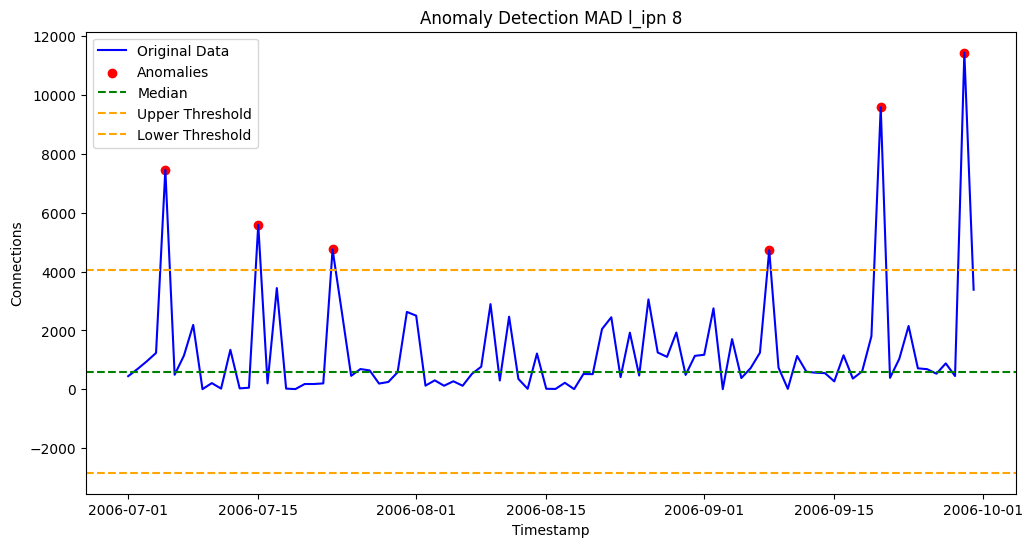

Anomaly Points:
         date  flows
4  2006-07-05   7456
14 2006-07-15   5586
22 2006-07-23   4748
69 2006-09-08   4724
81 2006-09-20   9573
90 2006-09-29  11426


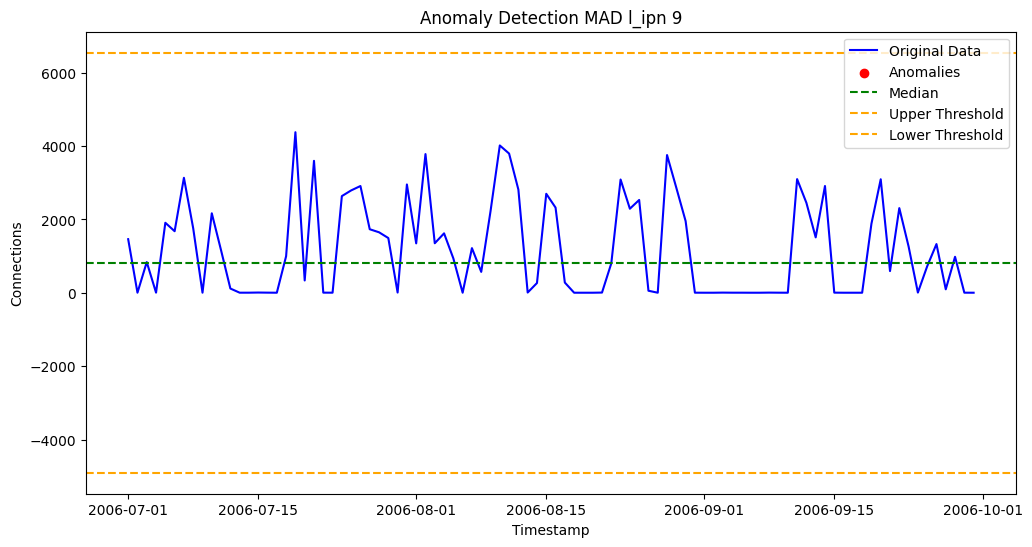

Anomaly Points:
Empty DataFrame
Columns: [date, flows]
Index: []


In [ ]:
for i in range(df['l_ipn'].nunique()):
    perform_mad(get_daily_aggregate_l_ipn(i))

# LOF

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor

In [ ]:
def lof(data):

    timestamp_column = 'date'
    value_column = 'flows'

    # Feature engineering: Normalize the value column
    scaler = StandardScaler()
    data['normalized_value'] = scaler.fit_transform(data[[value_column]])

    # Use Local Outlier Factor (LOF) for anomaly detection
    X = data[['normalized_value']].values

    # Set LOF parameters
    contamination = 0.02  # Percentage of outliers in the dataset
    lof_model = LocalOutlierFactor(n_neighbors=20, contamination=contamination)

    # Fit the LOF model and get outlier scores
    data['lof_score'] = lof_model.fit_predict(X)

    # Identify anomalies based on the LOF scores
    anomalies = data[data['lof_score'] == -1]

    # Visualize anomalies
    plt.figure(figsize=(12, 6))
    plt.plot(data[timestamp_column], data['normalized_value'], label='Normalized Data', color='blue')
    plt.scatter(anomalies[timestamp_column], anomalies['normalized_value'], label='Anomalies', color='red')
    plt.title('Anomaly Detection LOF l_ipn %i' %i)
    plt.xlabel('Timestamp')
    plt.ylabel('Connections (Normalized Value)')
    plt.legend()
    plt.show()

    # Display details of anomaly points
    print("Anomaly Points:")
    print(anomalies)

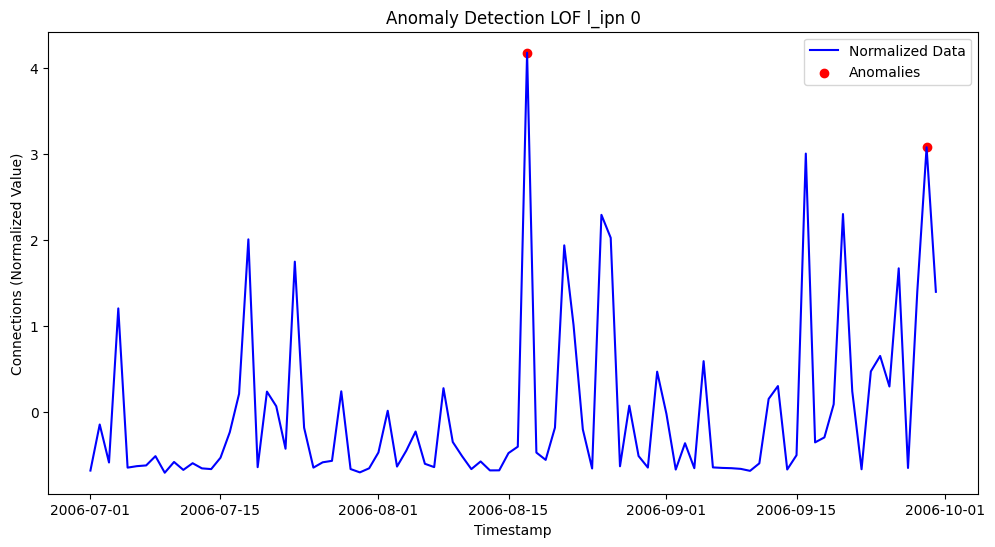

Anomaly Points:
         date  flows  normalized_value  lof_score
47 2006-08-17   7488          4.173005         -1
90 2006-09-29   5818          3.074633         -1


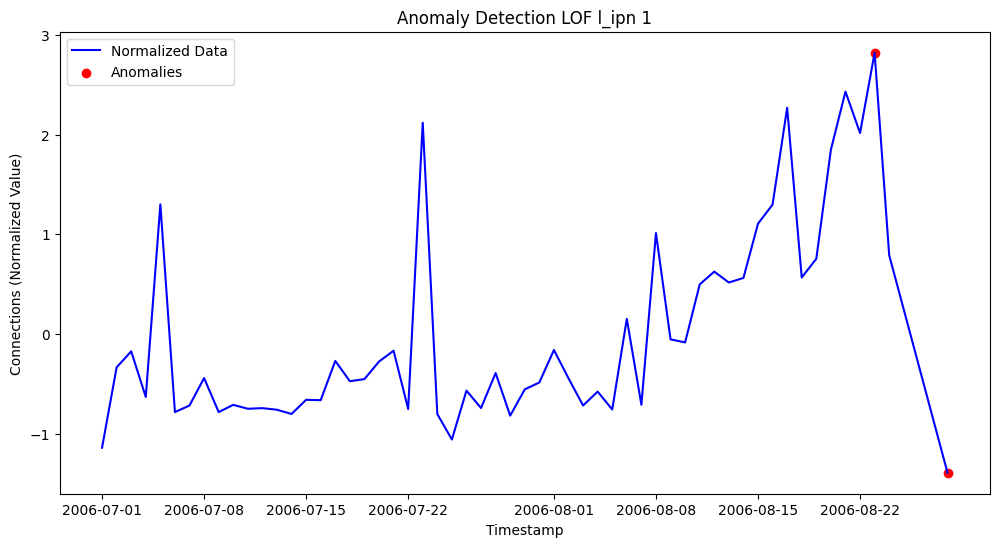

Anomaly Points:
         date  flows  normalized_value  lof_score
53 2006-08-23  10574          2.819766         -1
55 2006-08-28     11         -1.387468         -1


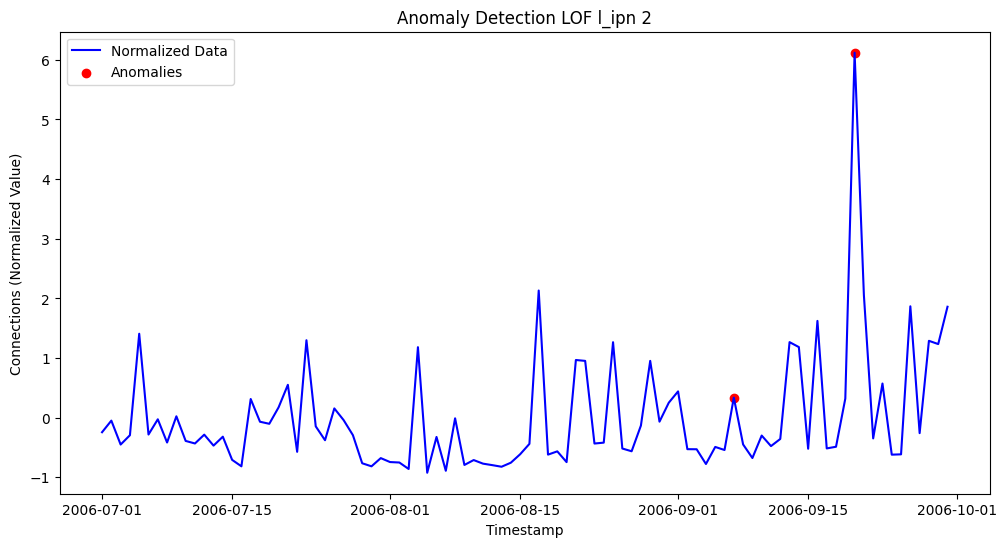

Anomaly Points:
         date  flows  normalized_value  lof_score
68 2006-09-07   2748          0.336296         -1
81 2006-09-20  13421          6.119084         -1


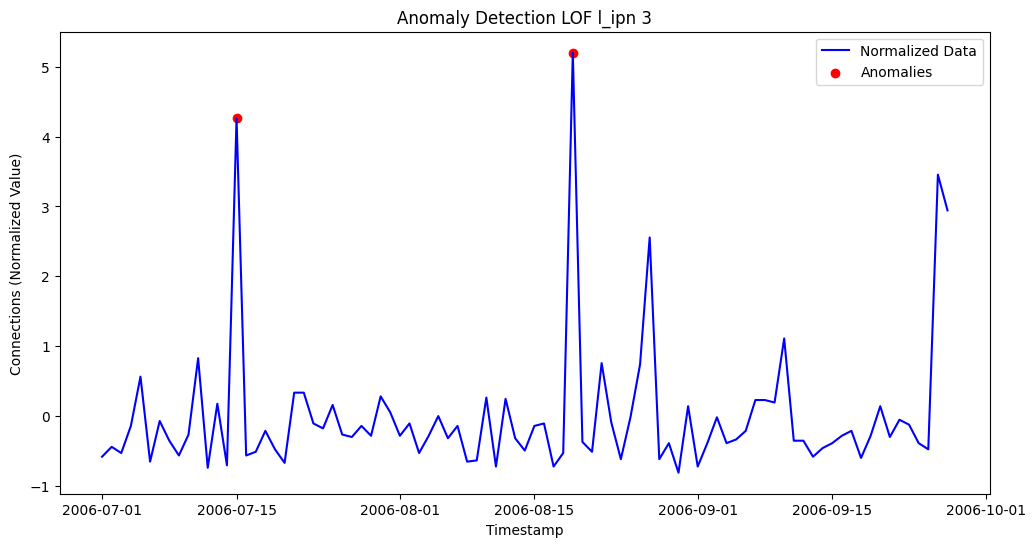

Anomaly Points:
         date  flows  normalized_value  lof_score
14 2006-07-15    297          4.266914         -1
49 2006-08-19    350          5.201794         -1


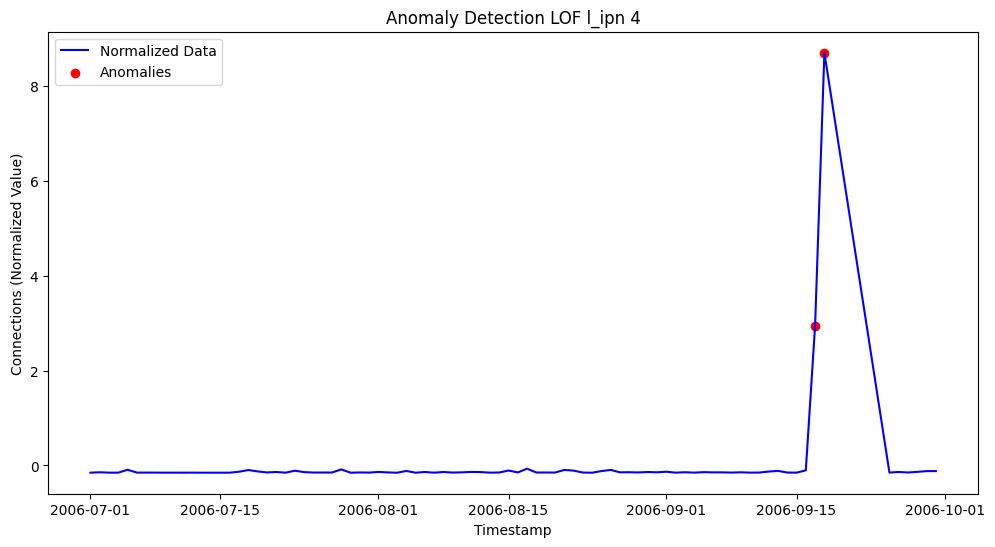

Anomaly Points:
         date   flows  normalized_value  lof_score
78 2006-09-17  275140          2.947621         -1
79 2006-09-18  785297          8.698705         -1


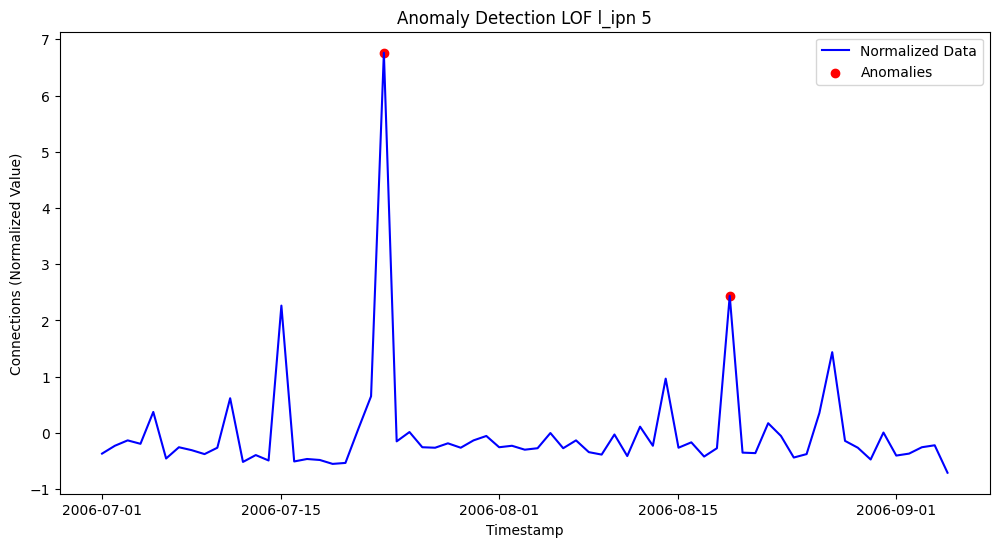

Anomaly Points:
         date  flows  normalized_value  lof_score
22 2006-07-23    862          6.762116         -1
49 2006-08-19    366          2.438442         -1


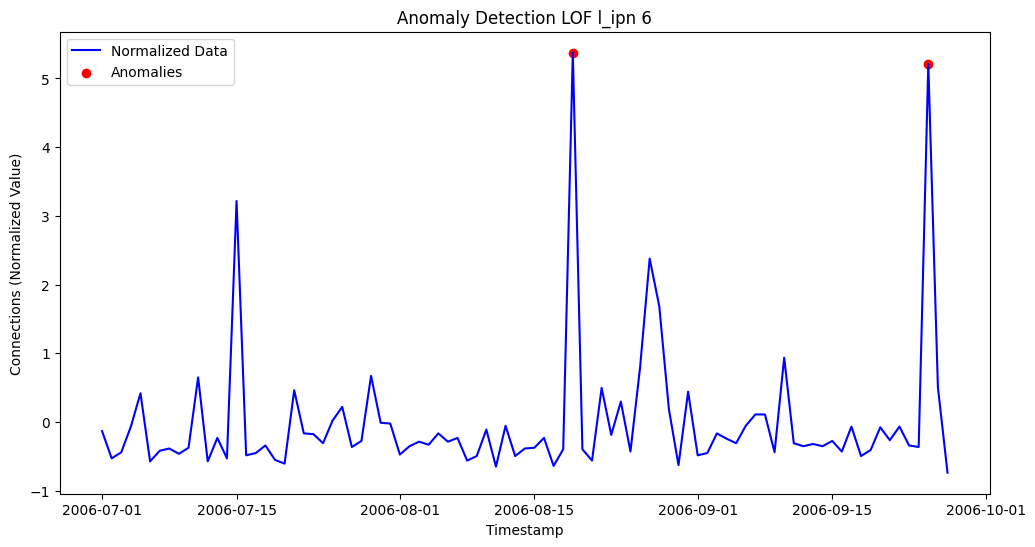

Anomaly Points:
         date  flows  normalized_value  lof_score
49 2006-08-19    563          5.373863         -1
86 2006-09-25    548          5.208686         -1


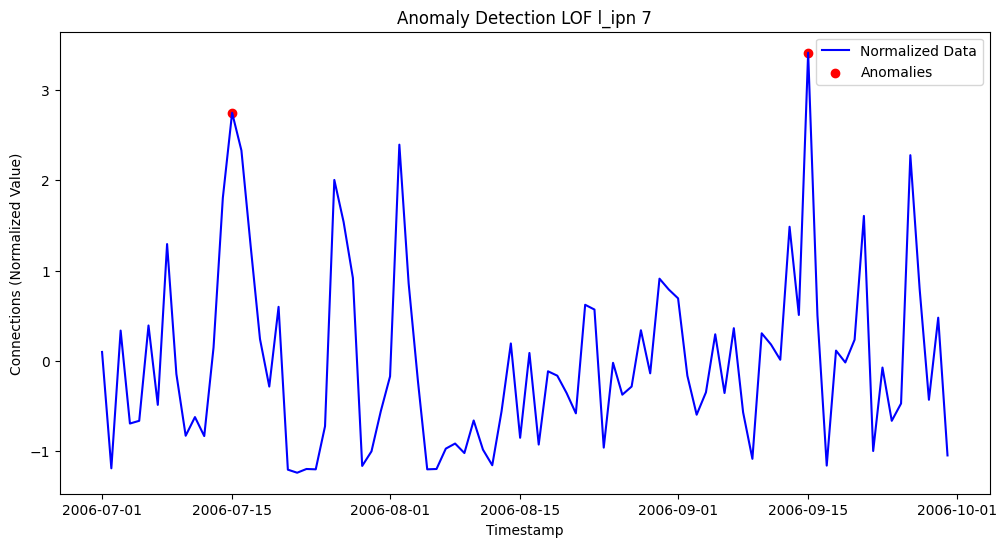

Anomaly Points:
         date  flows  normalized_value  lof_score
14 2006-07-15   1116          2.746669         -1
76 2006-09-15   1293          3.411158         -1


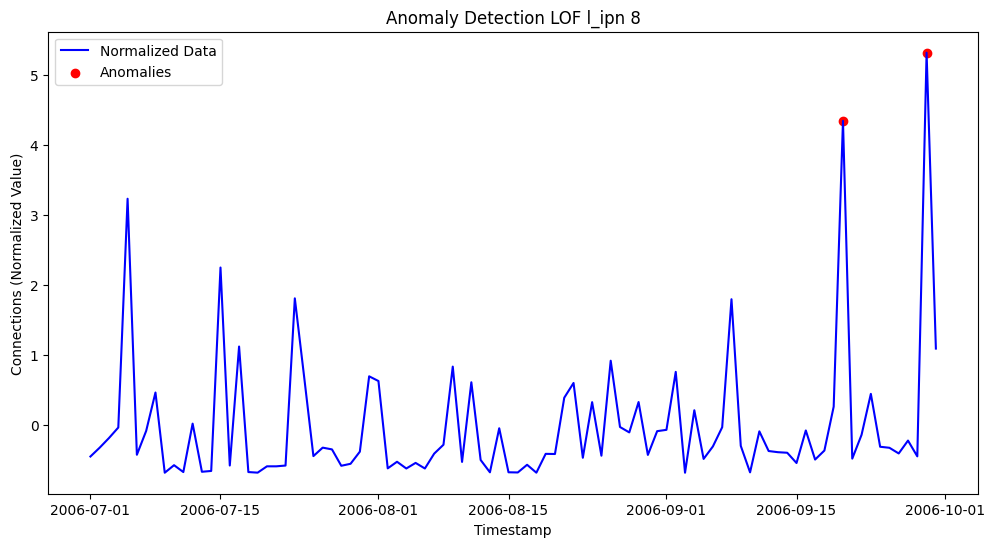

Anomaly Points:
         date  flows  normalized_value  lof_score
81 2006-09-20   9573          4.347553         -1
90 2006-09-29  11426          5.322097         -1


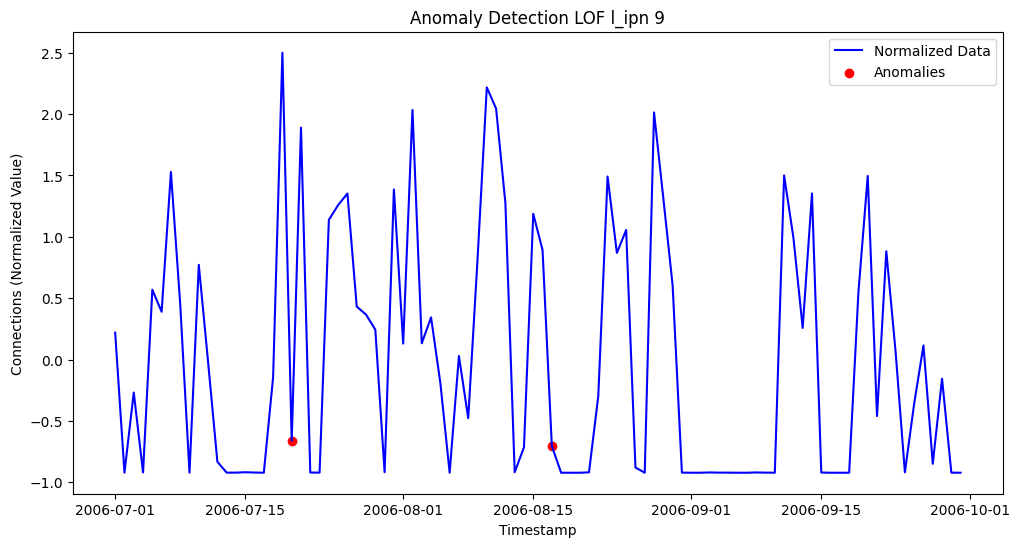

Anomaly Points:
         date  flows  normalized_value  lof_score
19 2006-07-20    338         -0.660329         -1
47 2006-08-17    281         -0.704906         -1


In [ ]:
for i in range(df['l_ipn'].nunique()):
    lof(get_daily_aggregate_l_ipn(i))

# Isolation Forests

In [ ]:
from sklearn.ensemble import IsolationForest

In [ ]:
def iso_for(data):

    timestamp_column = 'date'
    value_column = 'flows'

    # Train the Isolation Forest model
    model = IsolationForest(contamination=0.02, random_state=42)
    model.fit(data[[value_column]])

    # Predict anomalies (outliers)
    data['anomaly'] = model.predict(data[[value_column]])

    # Visualize anomalies
    anomaly_points = data[data['anomaly'] == -1]
    plt.figure(figsize=(12, 6))
    plt.plot(data[timestamp_column], data[value_column], label='Original Data', color='blue')
    plt.scatter(anomaly_points[timestamp_column], anomaly_points[value_column], label='Anomalies', color='red')
    plt.title('Anomaly Detection Isolation Forests l_ipn %i' %i)
    plt.xlabel('Timestamp')
    plt.ylabel('Connections')
    plt.legend()
    plt.show()

    # Display details of anomaly points
    print("Anomaly Points:")
    print(anomaly_points)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


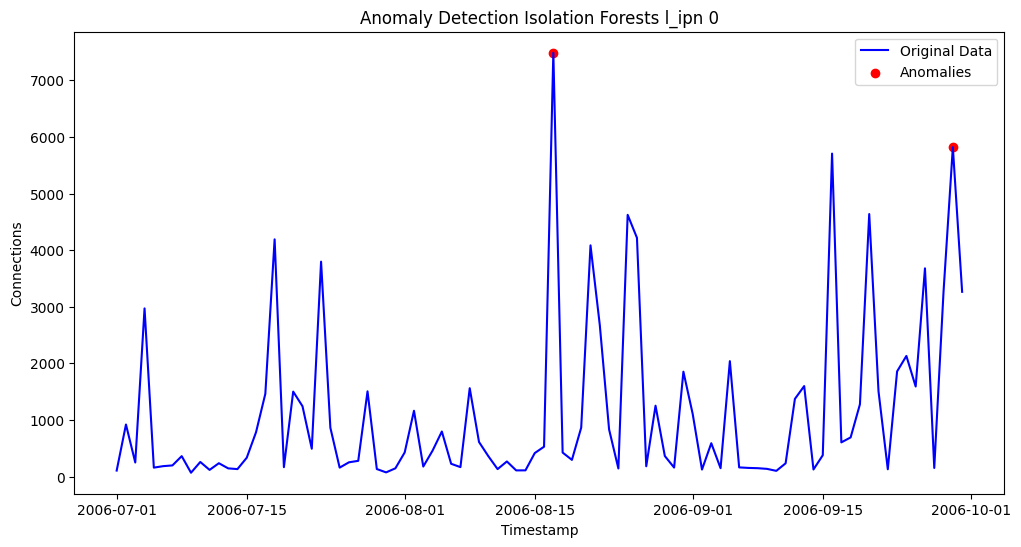

Anomaly Points:
         date  flows  anomaly
47 2006-08-17   7488       -1
90 2006-09-29   5818       -1


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


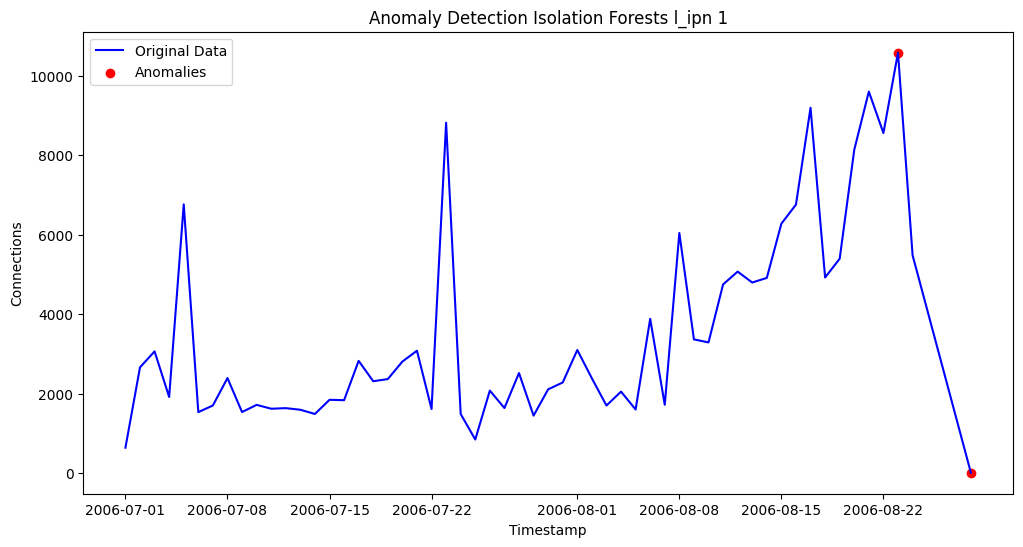

Anomaly Points:
         date  flows  anomaly
53 2006-08-23  10574       -1
55 2006-08-28     11       -1


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


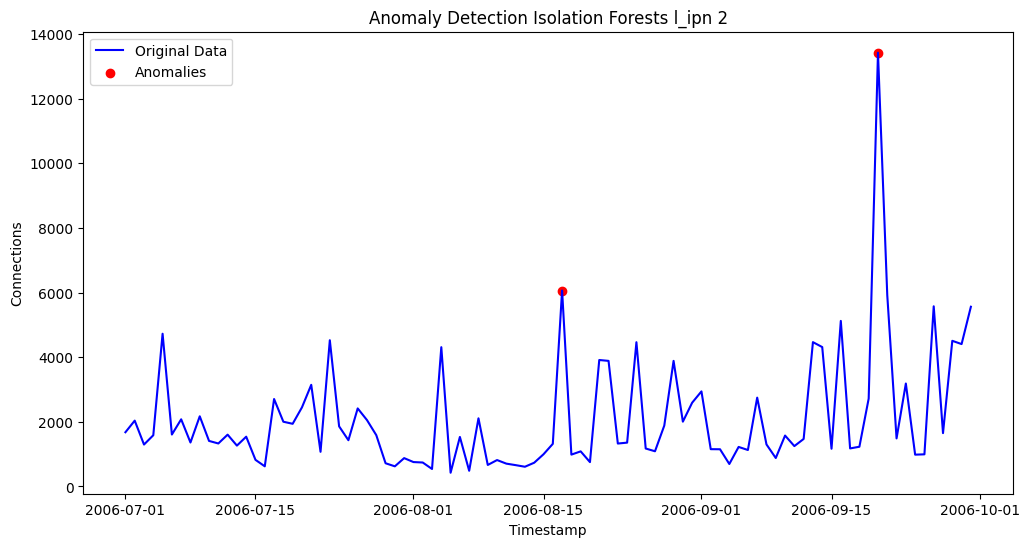

Anomaly Points:
         date  flows  anomaly
47 2006-08-17   6062       -1
81 2006-09-20  13421       -1


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


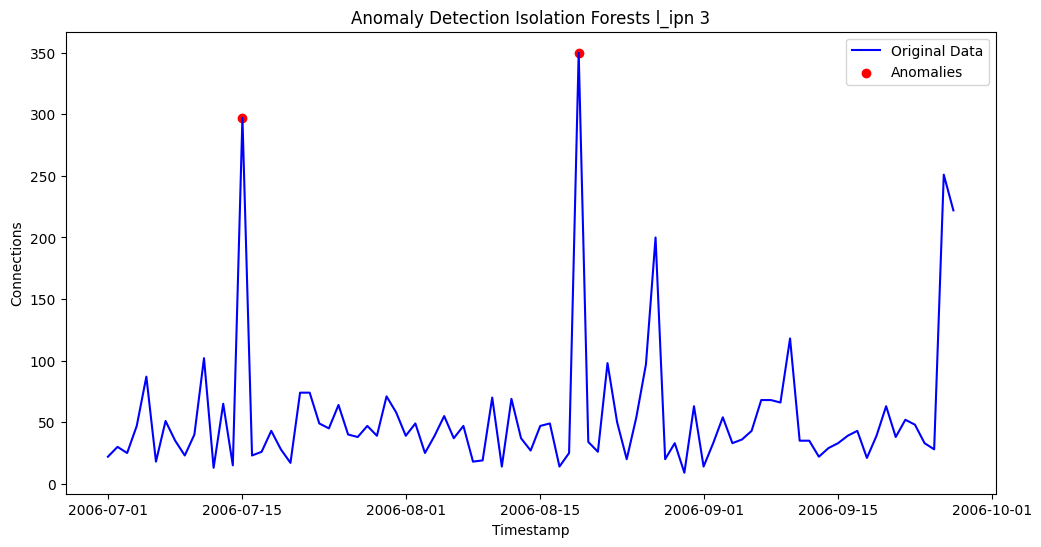

Anomaly Points:
         date  flows  anomaly
14 2006-07-15    297       -1
49 2006-08-19    350       -1


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


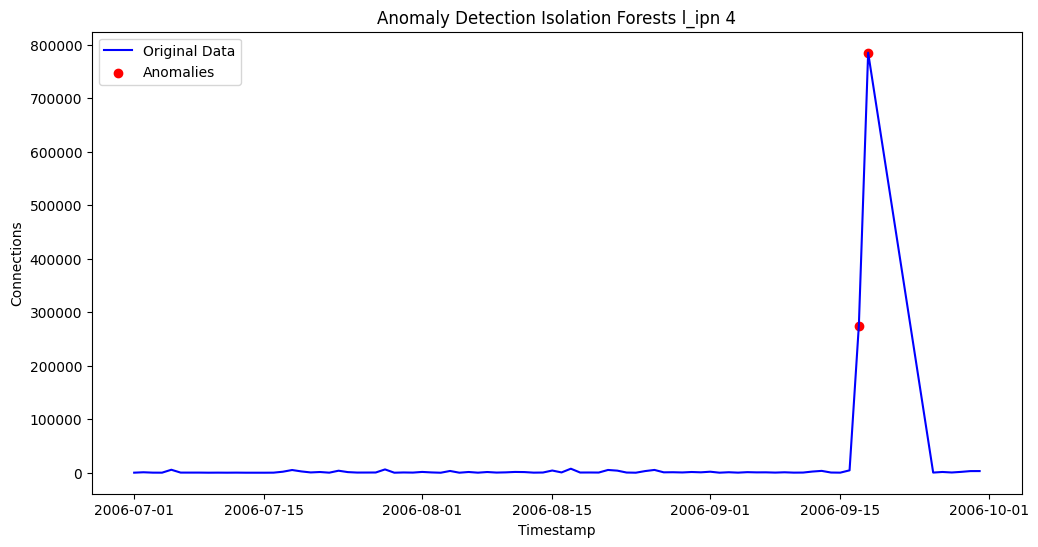

Anomaly Points:
         date   flows  anomaly
78 2006-09-17  275140       -1
79 2006-09-18  785297       -1


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


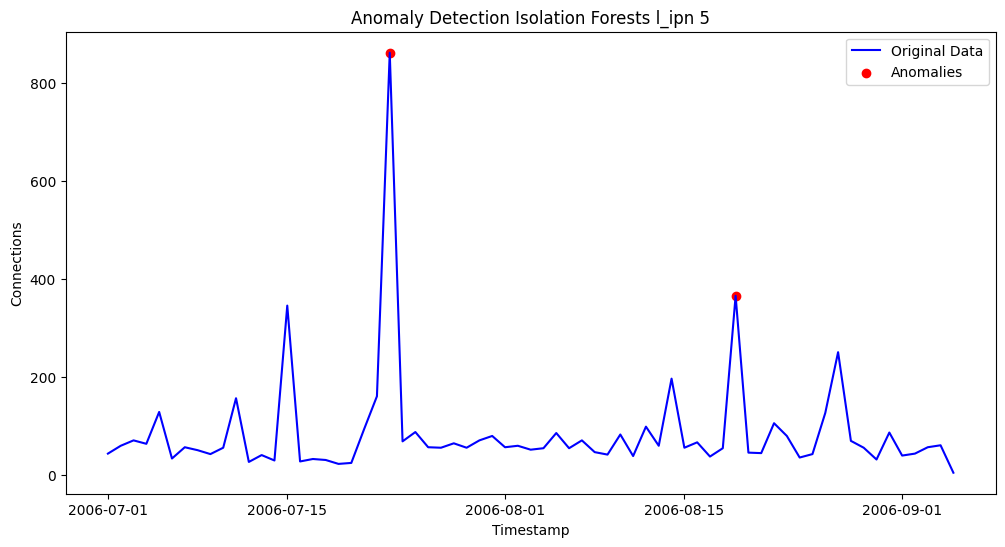

Anomaly Points:
         date  flows  anomaly
22 2006-07-23    862       -1
49 2006-08-19    366       -1


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


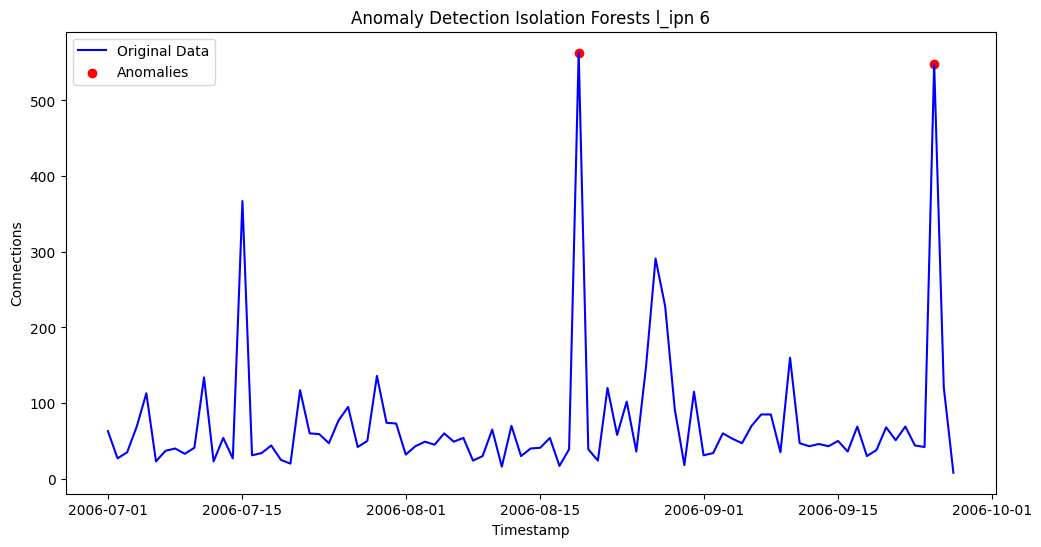

Anomaly Points:
         date  flows  anomaly
49 2006-08-19    563       -1
86 2006-09-25    548       -1


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


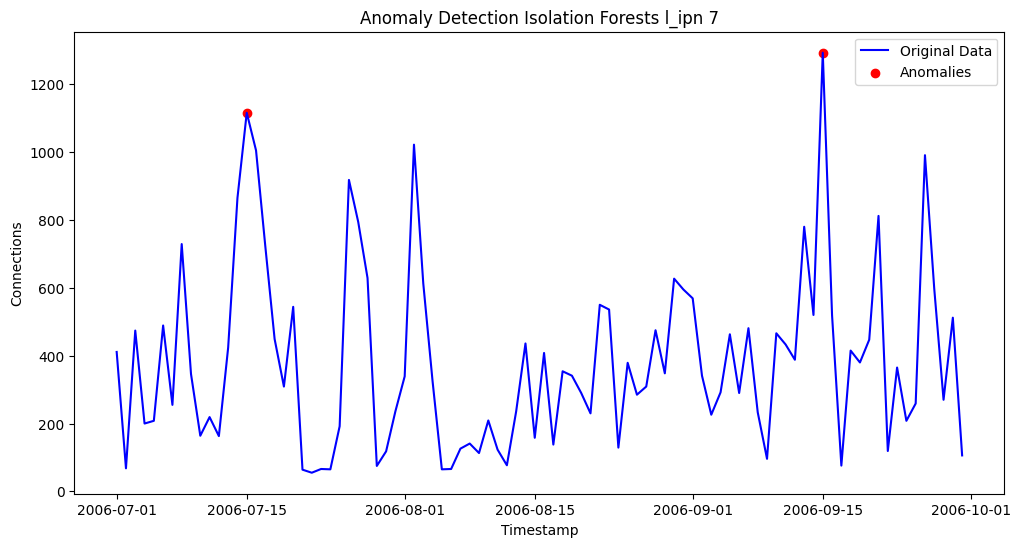

Anomaly Points:
         date  flows  anomaly
14 2006-07-15   1116       -1
76 2006-09-15   1293       -1


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


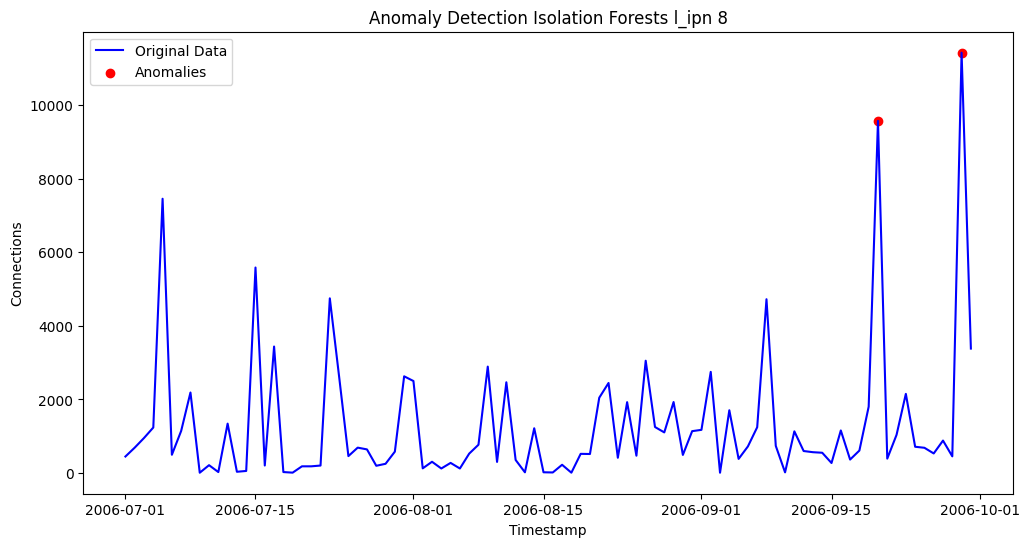

Anomaly Points:
         date  flows  anomaly
81 2006-09-20   9573       -1
90 2006-09-29  11426       -1


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


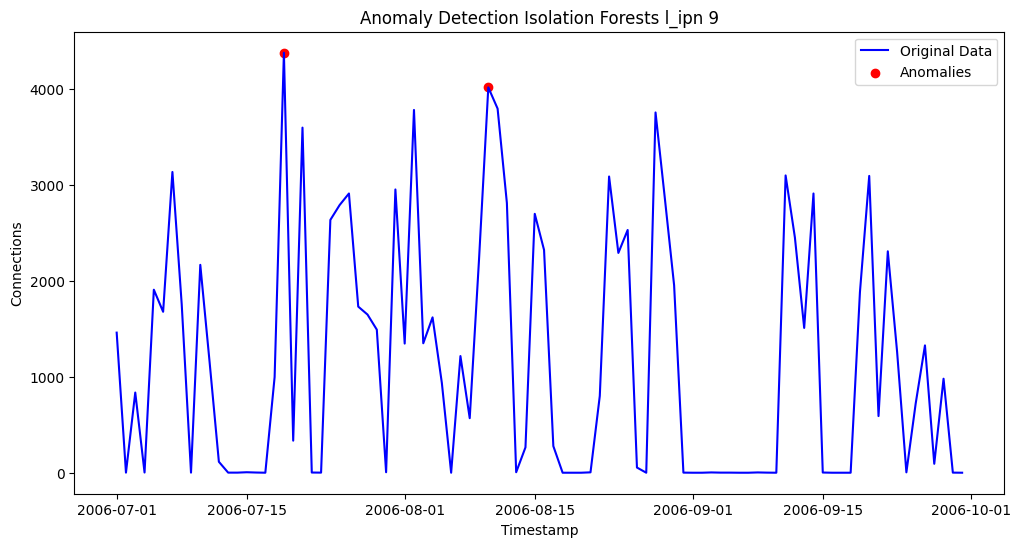

Anomaly Points:
         date  flows  anomaly
18 2006-07-19   4378       -1
40 2006-08-10   4017       -1


In [ ]:
for i in range(df['l_ipn'].nunique()):
    iso_for(get_daily_aggregate_l_ipn(i))

# SVM

In [ ]:
from sklearn.svm import OneClassSVM

In [ ]:
def svm(data):

    timestamp_column = 'date'
    value_column = 'flows'

    # Feature engineering: Normalize the value column
    scaler = StandardScaler()
    data['normalized_value'] = scaler.fit_transform(data[[value_column]])

    # Use SVM for anomaly detection
    X = data[['normalized_value']].values

    # Train the One-Class SVM model
    model = OneClassSVM(nu=0.01)
    model.fit(X)

    # Predict anomalies (outliers)
    data['anomaly'] = model.predict(X)

    # Visualize anomalies
    anomaly_points = data[data['anomaly'] == -1]
    plt.figure(figsize=(12, 6))
    plt.plot(data[timestamp_column], data[value_column], label='Original Data', color='blue')
    plt.scatter(anomaly_points[timestamp_column], anomaly_points[value_column], label='Anomalies', color='red')
    plt.title('Anomaly Detection One-Class SVM l_ipn %i' %i)
    plt.xlabel('Timestamp')
    plt.ylabel('Connections')
    plt.legend()
    plt.show()

    # Display details of anomaly points
    print("Anomaly Points:")
    print(anomaly_points)

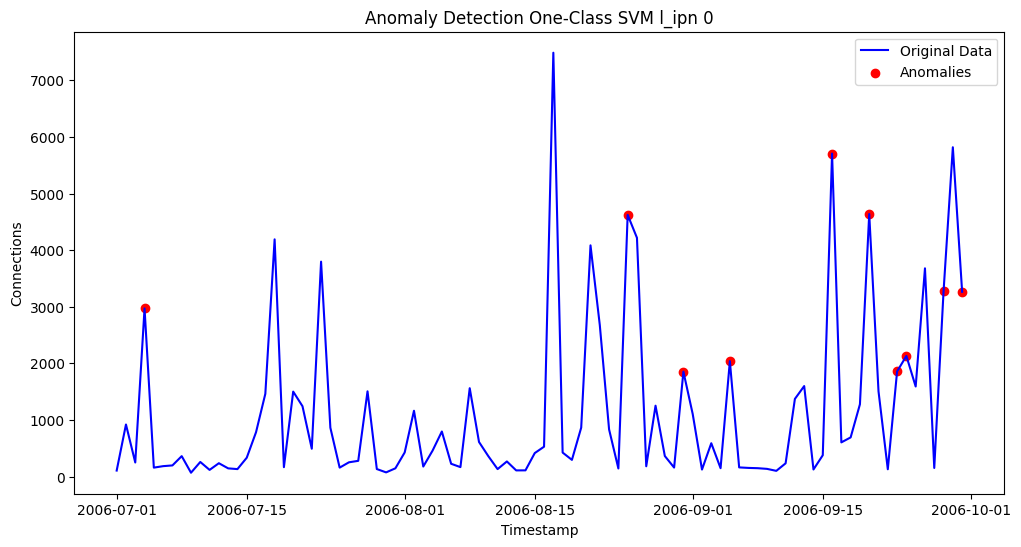

Anomaly Points:
         date  flows  normalized_value  anomaly
3  2006-07-04   2971          1.202140       -1
55 2006-08-25   4624          2.289330       -1
61 2006-08-31   1853          0.466822       -1
66 2006-09-05   2039          0.589156       -1
77 2006-09-16   5706          3.000970       -1
81 2006-09-20   4638          2.298538       -1
84 2006-09-23   1858          0.470111       -1
85 2006-09-24   2131          0.649665       -1
89 2006-09-28   3270          1.398794       -1
91 2006-09-30   3264          1.394848       -1


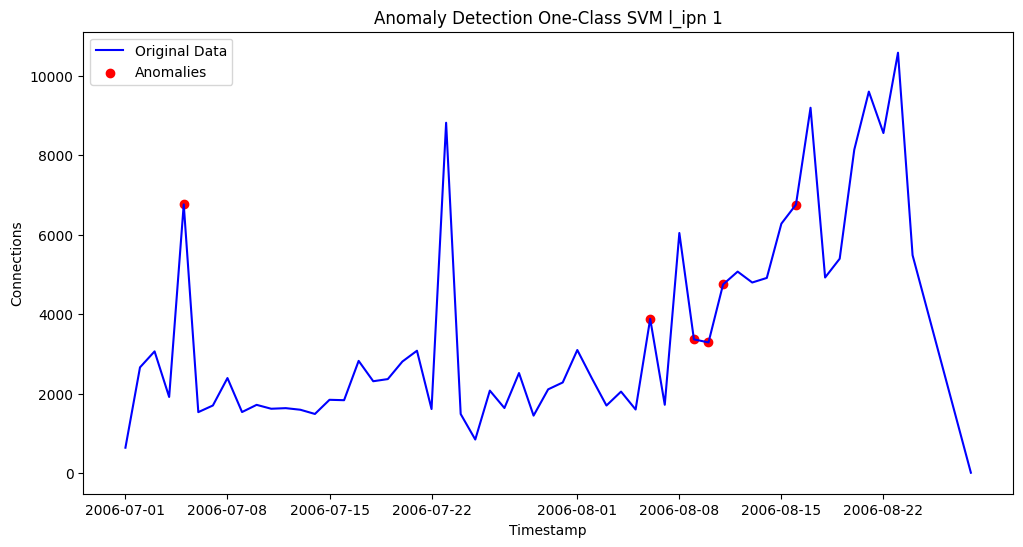

Anomaly Points:
         date  flows  normalized_value  anomaly
4  2006-07-05   6760          1.300653       -1
36 2006-08-06   3881          0.153950       -1
39 2006-08-09   3365         -0.051573       -1
40 2006-08-10   3288         -0.082242       -1
41 2006-08-11   4746          0.498479       -1
46 2006-08-16   6754          1.298263       -1


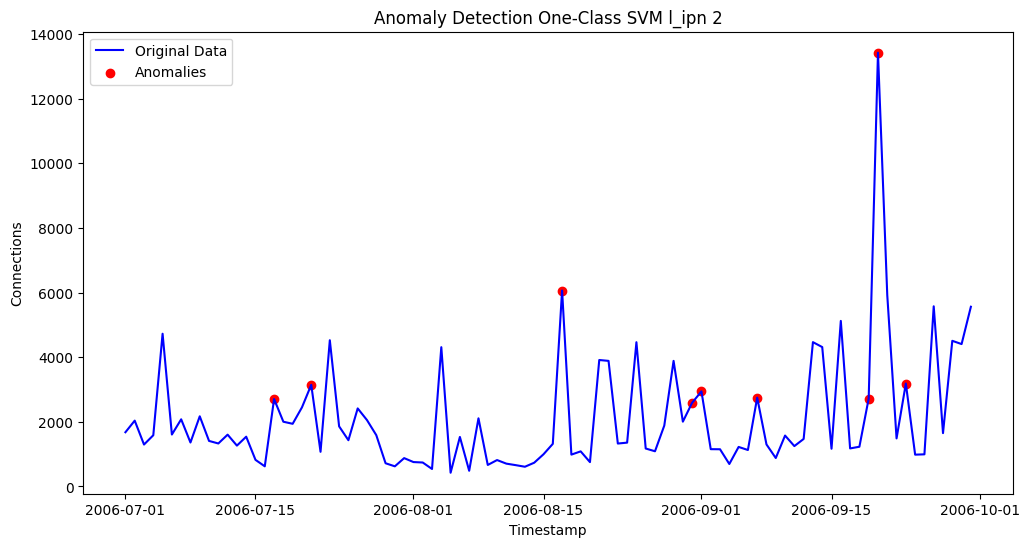

Anomaly Points:
         date  flows  normalized_value  anomaly
16 2006-07-17   2705          0.312998       -1
20 2006-07-21   3144          0.550855       -1
47 2006-08-17   6062          2.131870       -1
61 2006-08-31   2591          0.251231       -1
62 2006-09-01   2941          0.440866       -1
68 2006-09-07   2748          0.336296       -1
80 2006-09-19   2718          0.320042       -1
81 2006-09-20  13421          6.119084       -1
84 2006-09-23   3184          0.572527       -1


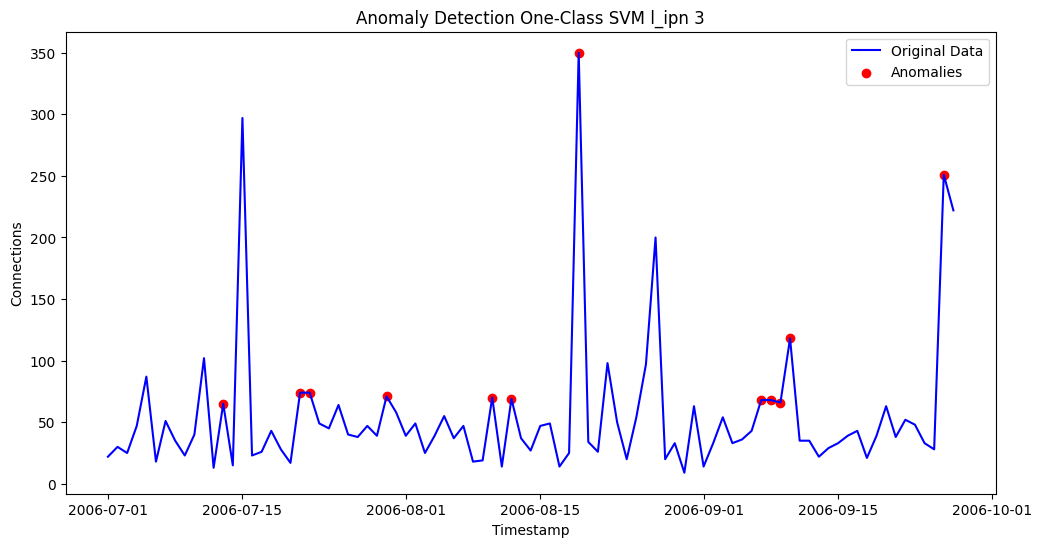

Anomaly Points:
         date  flows  normalized_value  anomaly
12 2006-07-13     65          0.174609       -1
20 2006-07-21     74          0.333362       -1
21 2006-07-22     74          0.333362       -1
29 2006-07-30     71          0.280444       -1
40 2006-08-10     70          0.262805       -1
42 2006-08-12     69          0.245166       -1
49 2006-08-19    350          5.201794       -1
68 2006-09-07     68          0.227526       -1
69 2006-09-08     68          0.227526       -1
70 2006-09-09     66          0.192248       -1
71 2006-09-10    118          1.109489       -1
87 2006-09-26    251          3.455509       -1


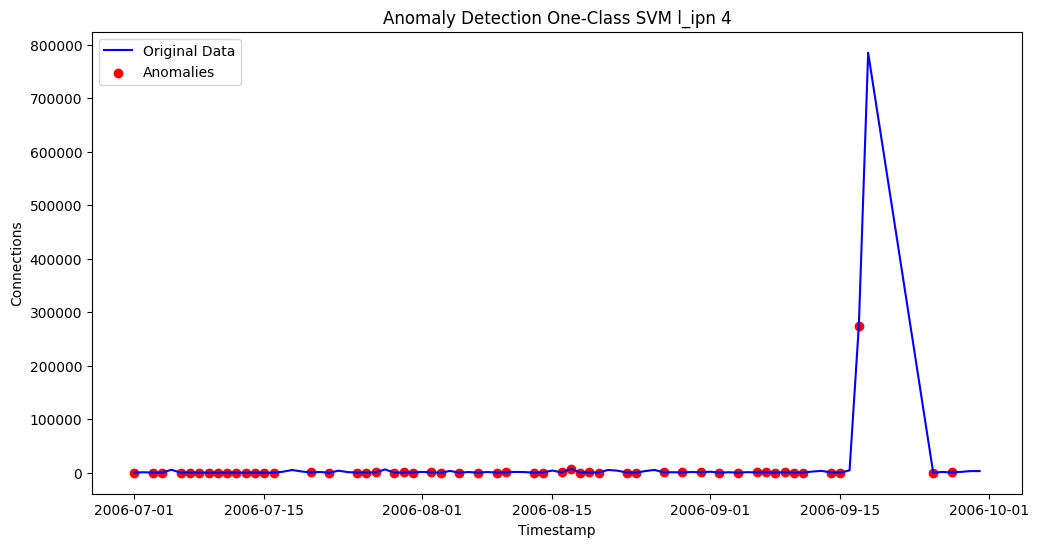

Anomaly Points:
         date   flows  normalized_value  anomaly
0  2006-07-01     184         -0.152003       -1
2  2006-07-03     245         -0.151316       -1
3  2006-07-04     187         -0.151969       -1
5  2006-07-06     327         -0.150391       -1
6  2006-07-07     315         -0.150527       -1
7  2006-07-08     327         -0.150391       -1
8  2006-07-09     148         -0.152409       -1
9  2006-07-10     254         -0.151214       -1
10 2006-07-11     158         -0.152296       -1
11 2006-07-12     270         -0.151034       -1
12 2006-07-13     128         -0.152635       -1
13 2006-07-14     126         -0.152657       -1
14 2006-07-15     118         -0.152747       -1
15 2006-07-16     221         -0.151586       -1
19 2006-07-20     620         -0.147088       -1
21 2006-07-22     194         -0.151891       -1
24 2006-07-25     391         -0.149670       -1
25 2006-07-26     435         -0.149174       -1
26 2006-07-27     511         -0.148317       -1
28 2

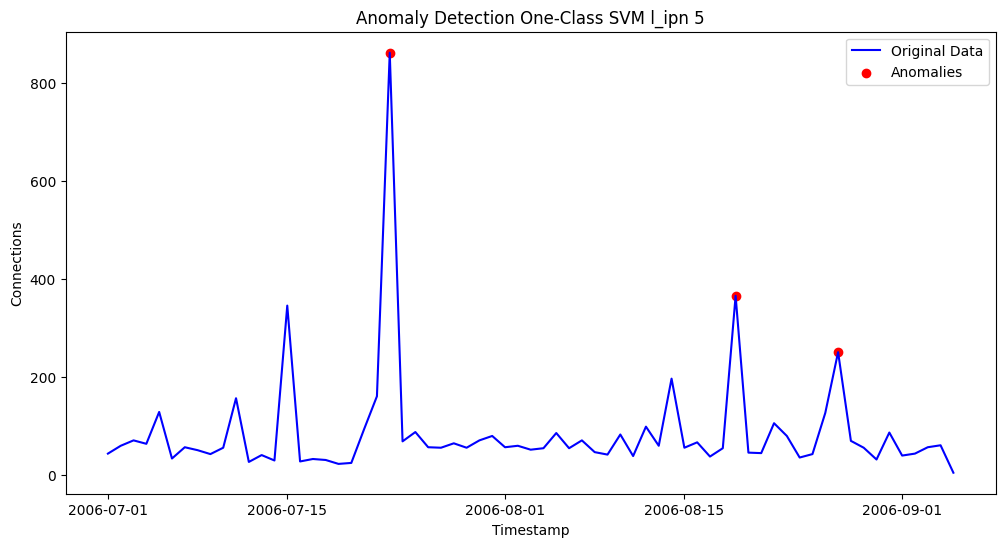

Anomaly Points:
         date  flows  normalized_value  anomaly
22 2006-07-23    862          6.762116       -1
49 2006-08-19    366          2.438442       -1
57 2006-08-27    251          1.435977       -1


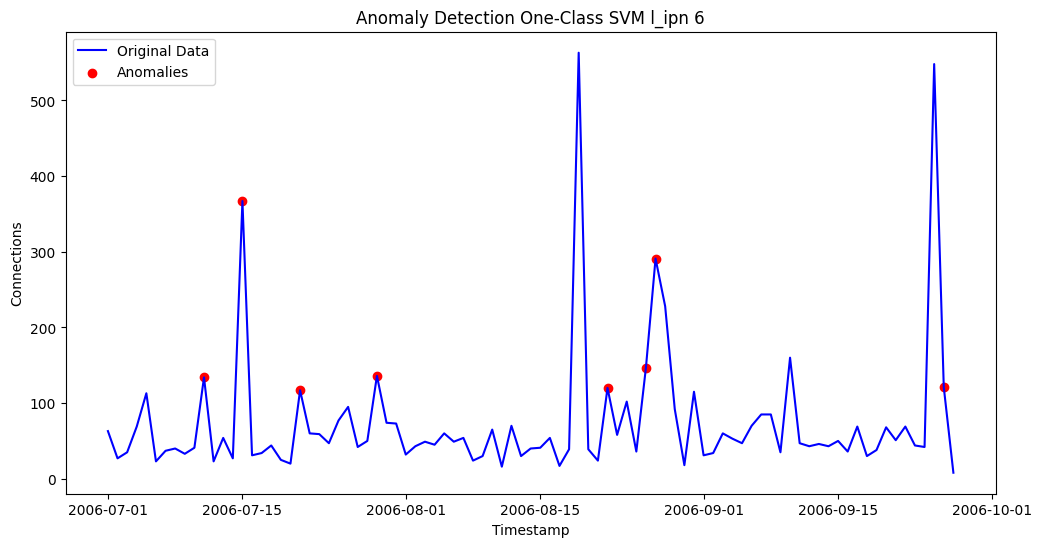

Anomaly Points:
         date  flows  normalized_value  anomaly
10 2006-07-11    134          0.649818       -1
14 2006-07-15    367          3.215558       -1
20 2006-07-21    117          0.462618       -1
28 2006-07-29    136          0.671841       -1
52 2006-08-22    120          0.495653       -1
56 2006-08-26    147          0.792970       -1
57 2006-08-27    291          2.378664       -1
87 2006-09-26    121          0.506665       -1


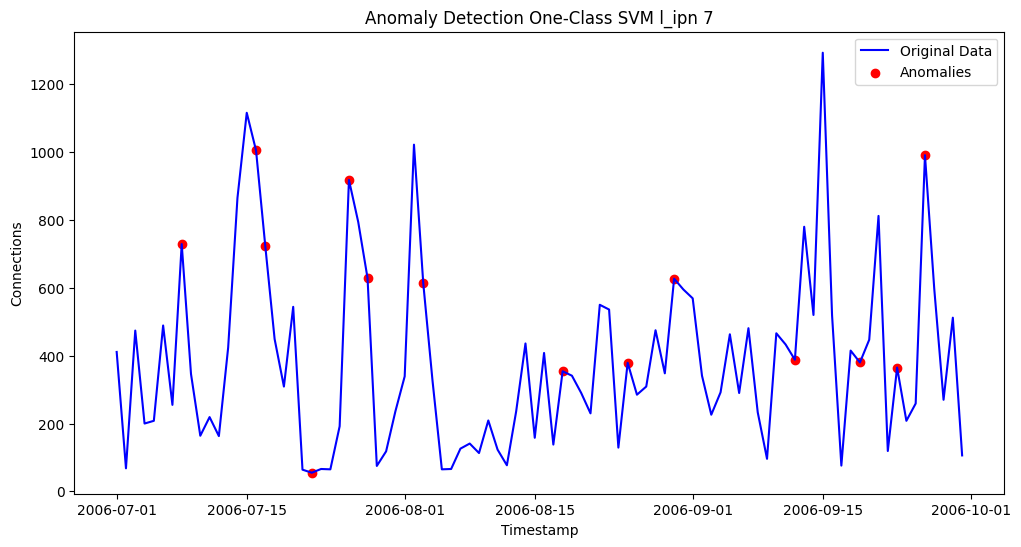

Anomaly Points:
         date  flows  normalized_value  anomaly
7  2006-07-08    729          1.293803       -1
15 2006-07-16   1005          2.329956       -1
16 2006-07-17    722          1.267524       -1
21 2006-07-22     55         -1.236511       -1
25 2006-07-26    918          2.003342       -1
27 2006-07-28    629          0.918386       -1
33 2006-08-03    613          0.858319       -1
48 2006-08-18    354         -0.114013       -1
55 2006-08-25    379         -0.020158       -1
60 2006-08-30    627          0.910877       -1
73 2006-09-12    388          0.013629       -1
80 2006-09-19    380         -0.016404       -1
84 2006-09-23    365         -0.072717       -1
87 2006-09-26    991          2.277397       -1


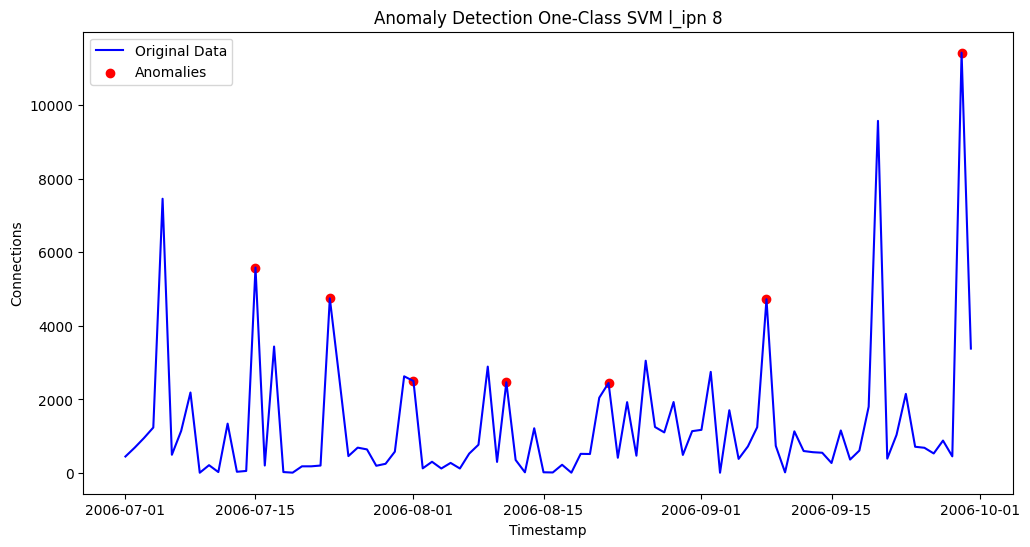

Anomaly Points:
         date  flows  normalized_value  anomaly
14 2006-07-15   5586          2.250679       -1
22 2006-07-23   4748          1.809952       -1
31 2006-08-01   2500          0.627666       -1
41 2006-08-11   2466          0.609785       -1
52 2006-08-22   2447          0.599792       -1
69 2006-09-08   4724          1.797330       -1
90 2006-09-29  11426          5.322097       -1


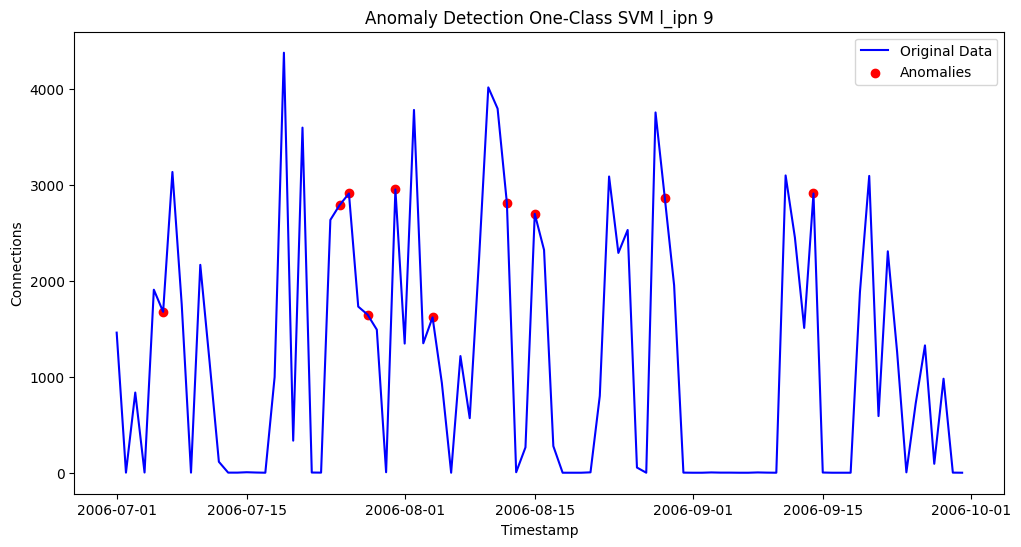

Anomaly Points:
         date  flows  normalized_value  anomaly
5  2006-07-06   1680          0.389180       -1
24 2006-07-25   2792          1.258817       -1
25 2006-07-26   2912          1.352663       -1
27 2006-07-28   1651          0.366500       -1
30 2006-07-31   2954          1.385509       -1
34 2006-08-04   1622          0.343821       -1
42 2006-08-12   2813          1.275240       -1
45 2006-08-15   2700          1.186869       -1
59 2006-08-29   2863          1.314343       -1
75 2006-09-14   2912          1.352663       -1


In [ ]:
for i in range(df['l_ipn'].nunique()):
    svm(get_daily_aggregate_l_ipn(i))

# KNN

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
def knn(data):

    timestamp_column = 'date'
    value_column = 'flows'

    # Feature engineering: Normalize the value column
    scaler = StandardScaler()
    data['normalized_value'] = scaler.fit_transform(data[[value_column]])

    # Use KNN for anomaly detection
    X = data[['normalized_value']].values

    # Set KNN parameters
    n_neighbors = 3
    knn_model = NearestNeighbors(n_neighbors=n_neighbors)
    knn_model.fit(X)

    # Compute distances to the K nearest neighbors for each data point
    distances, _ = knn_model.kneighbors(X)

    # Use the maximum distance as a measure of anomaly
    anomaly_scores = distances.max(axis=1)

    # Set a threshold for anomaly detection
    threshold = np.percentile(anomaly_scores, 95)

    # Identify anomalies based on the threshold
    anomalies = data[anomaly_scores > threshold]

    # Visualize anomalies
    plt.figure(figsize=(12, 6))
    plt.plot(data[timestamp_column], data['normalized_value'], label='Normalized Data', color='blue')
    plt.scatter(anomalies[timestamp_column], anomalies['normalized_value'], label='Anomalies', color='red')
    plt.title('Anomaly Detection KNN l_ipn %i' %i)
    plt.xlabel('Timestamp')
    plt.ylabel('Connections (Normalized Value)')
    plt.legend()
    plt.show()

    # Display details of anomaly points
    print("Anomaly Points:")
    print(anomalies)

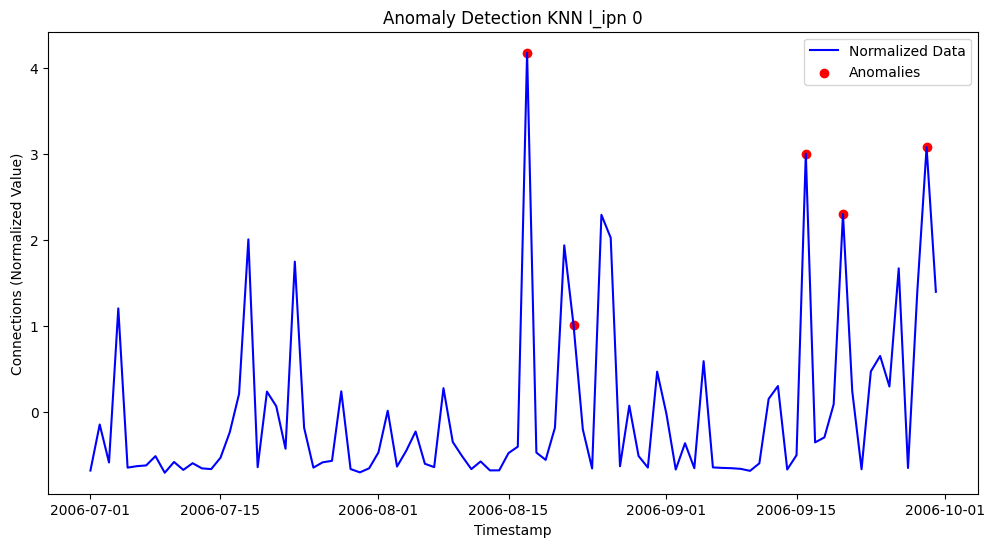

Anomaly Points:
         date  flows  normalized_value
47 2006-08-17   7488          4.173005
52 2006-08-22   2677          1.008773
77 2006-09-16   5706          3.000970
81 2006-09-20   4638          2.298538
90 2006-09-29   5818          3.074633


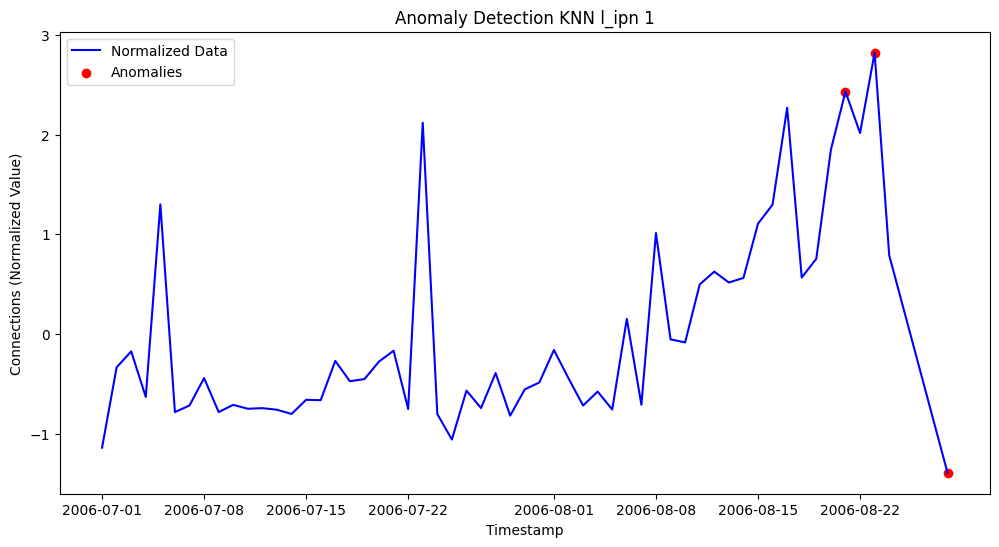

Anomaly Points:
         date  flows  normalized_value
51 2006-08-21   9596          2.430230
53 2006-08-23  10574          2.819766
55 2006-08-28     11         -1.387468


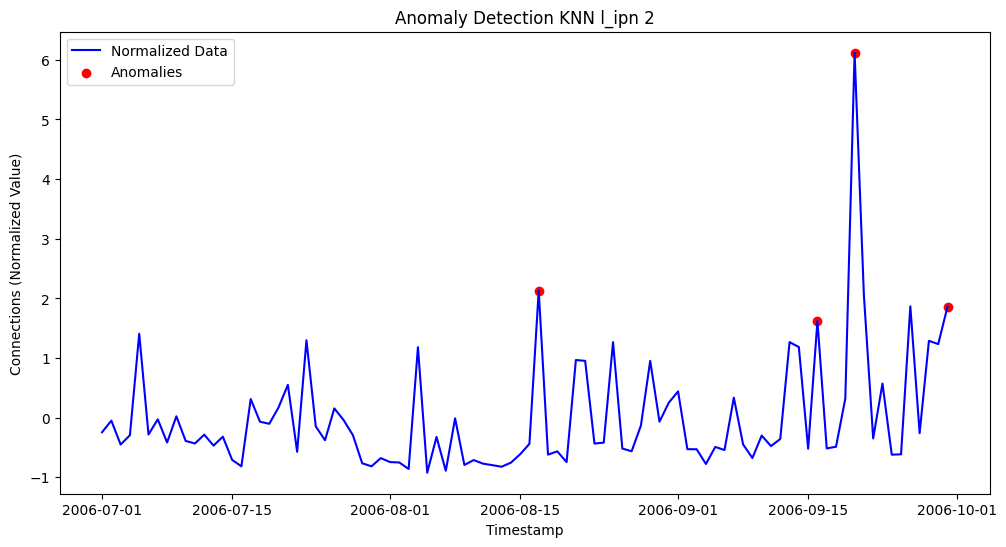

Anomaly Points:
         date  flows  normalized_value
47 2006-08-17   6062          2.131870
77 2006-09-16   5122          1.622564
81 2006-09-20  13421          6.119084
91 2006-09-30   5560          1.859879


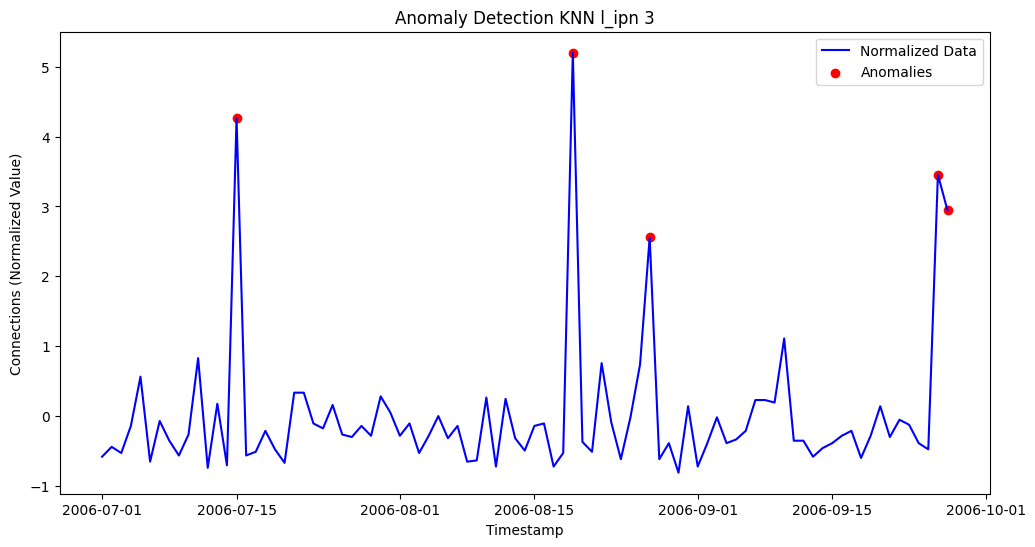

Anomaly Points:
         date  flows  normalized_value
14 2006-07-15    297          4.266914
49 2006-08-19    350          5.201794
57 2006-08-27    200          2.555907
87 2006-09-26    251          3.455509
88 2006-09-27    222          2.943970


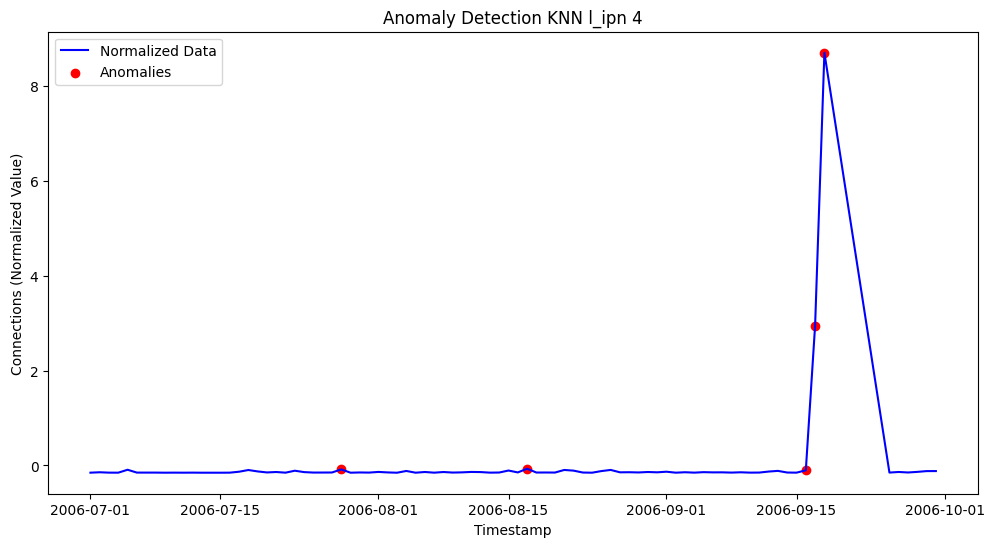

Anomaly Points:
         date   flows  normalized_value
27 2006-07-28    6265         -0.083451
47 2006-08-17    7593         -0.068480
77 2006-09-16    4539         -0.102909
78 2006-09-17  275140          2.947621
79 2006-09-18  785297          8.698705


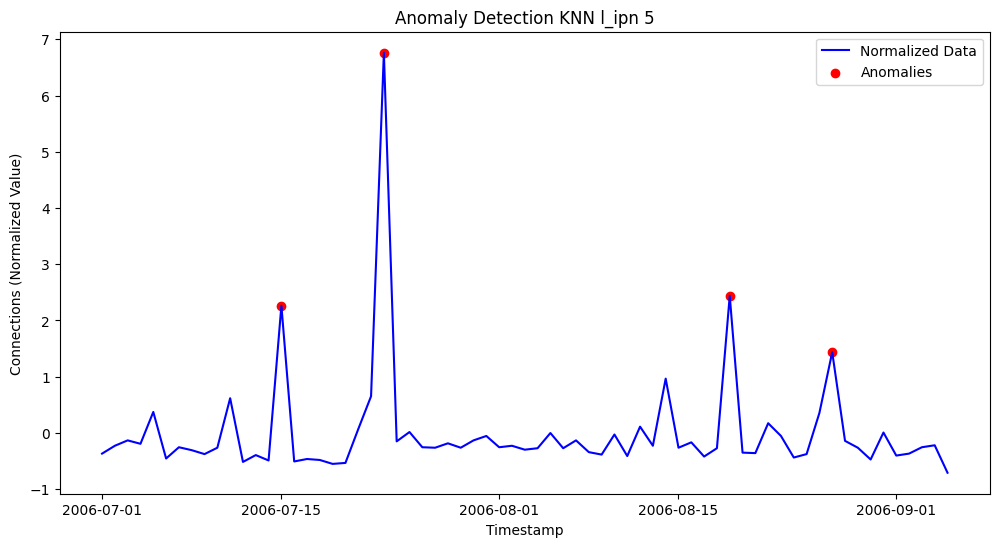

Anomaly Points:
         date  flows  normalized_value
14 2006-07-15    346          2.264100
22 2006-07-23    862          6.762116
49 2006-08-19    366          2.438442
57 2006-08-27    251          1.435977


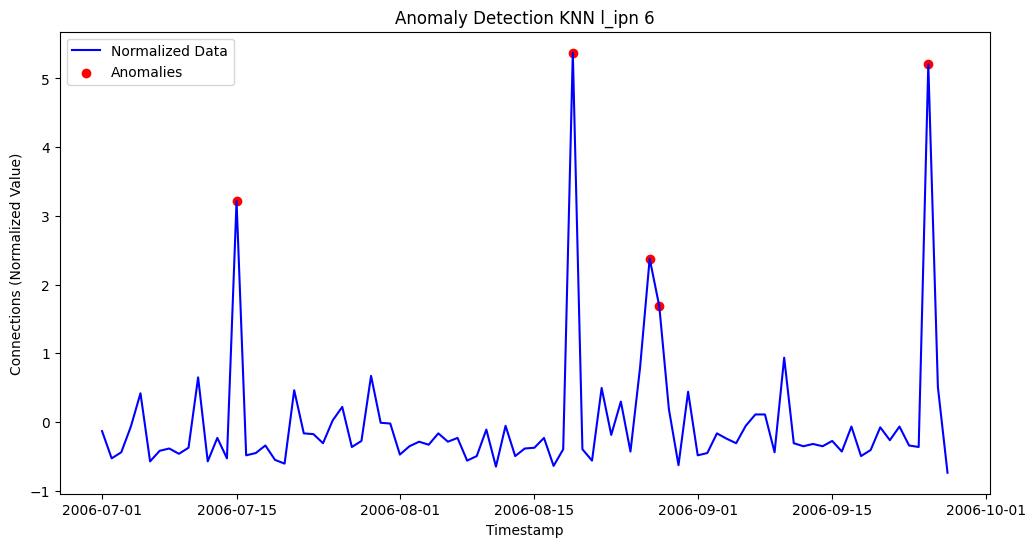

Anomaly Points:
         date  flows  normalized_value
14 2006-07-15    367          3.215558
49 2006-08-19    563          5.373863
57 2006-08-27    291          2.378664
58 2006-08-28    228          1.684923
86 2006-09-25    548          5.208686


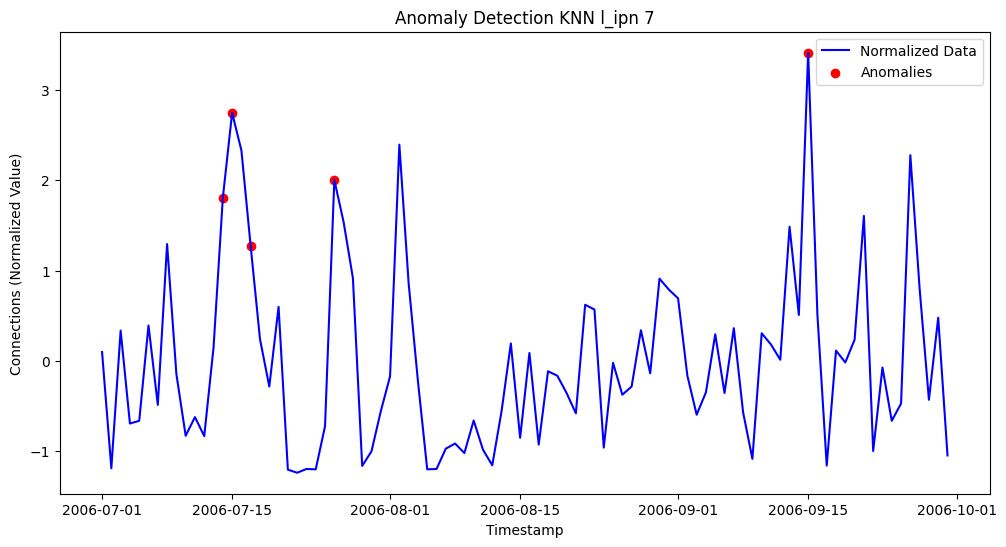

Anomaly Points:
         date  flows  normalized_value
13 2006-07-14    865          1.804371
14 2006-07-15   1116          2.746669
16 2006-07-17    722          1.267524
25 2006-07-26    918          2.003342
76 2006-09-15   1293          3.411158


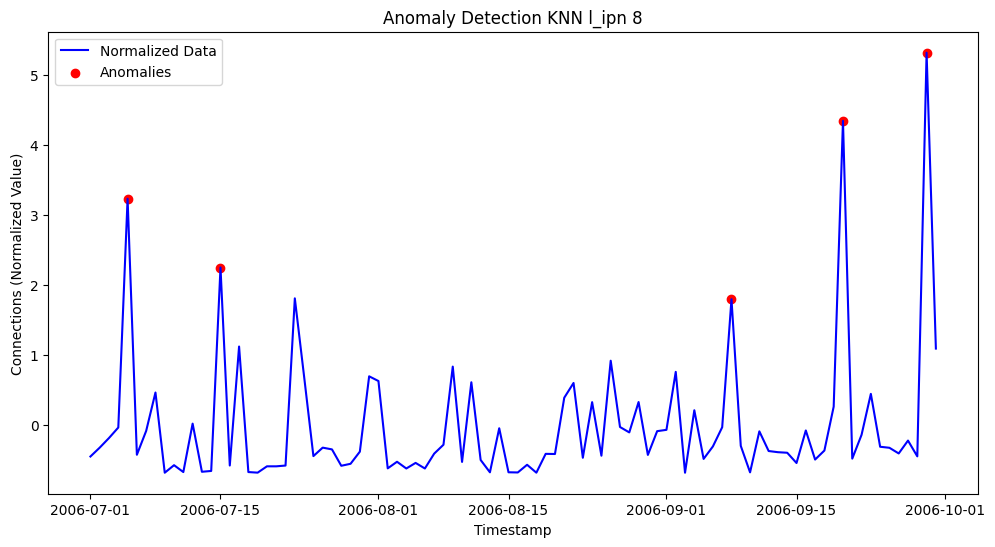

Anomaly Points:
         date  flows  normalized_value
4  2006-07-05   7456          3.234164
14 2006-07-15   5586          2.250679
69 2006-09-08   4724          1.797330
81 2006-09-20   9573          4.347553
90 2006-09-29  11426          5.322097


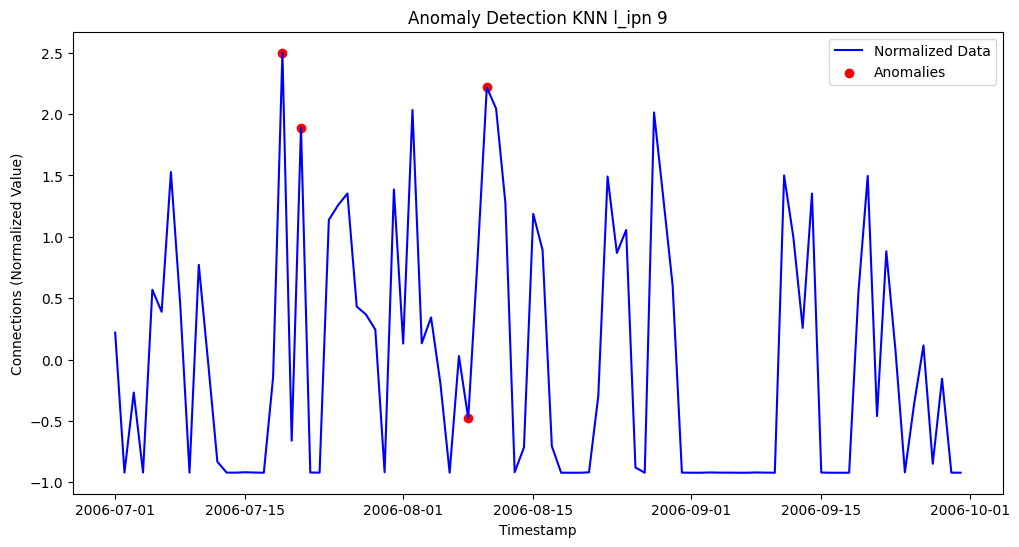

Anomaly Points:
         date  flows  normalized_value
18 2006-07-19   4378          2.499146
20 2006-07-21   3598          1.889148
38 2006-08-08    572         -0.477330
40 2006-08-10   4017          2.216826


In [ ]:
for i in range(df['l_ipn'].nunique()):
    knn(get_daily_aggregate_l_ipn(i))

# Autoencoder

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
def perform_autoenc(data):

    timestamp_column = 'date'
    value_column = 'flows'

    # Feature engineering: Normalize the value column
    scaler = StandardScaler()
    data['normalized_value'] = scaler.fit_transform(data[[value_column]])

    # Define the autoencoder model
    model = Sequential([
        Dense(units=10, activation='relu', input_shape=(1,), name='encoder'),
        Dense(units=1, activation='sigmoid', name='decoder')
    ])

    model.compile(optimizer='adam', loss='mse')

    # Create input and target sequences for training
    sequences = data['normalized_value'].values.reshape(-1, 1)
    target_sequences = sequences.copy()

    # Train the autoencoder
    model.fit(sequences, target_sequences, epochs=50, batch_size=32, shuffle=True)

    # Predict on the same data
    predictions = model.predict(sequences)

    # Calculate reconstruction errors (MSE)
    mse = np.mean(np.square(predictions - sequences), axis=1)

    # Set a threshold for anomaly detection
    threshold = mse.mean() + 2 * mse.std()

    # Identify anomalies based on the threshold
    anomalies = mse > threshold

    # Visualize anomalies
    plt.figure(figsize=(12, 6))
    plt.plot(data[timestamp_column], sequences, label='Original Data', color='blue')
    plt.scatter(data[timestamp_column][anomalies],
                sequences[anomalies], label='Anomalies', color='red')
    plt.title('Anomaly Detection Autoencoder l_ipn %i' %i)
    plt.xlabel('Timestamp')
    plt.ylabel('Connections (Normalized Value)')
    plt.legend()
    plt.show()

    # Display details of anomaly points
    anomaly_points = data[anomalies]
    print("Anomaly Points:")
    print(anomaly_points)

Epoch 1/50
3/3 [==============================] - 0s 5ms/step - loss: 1.2821
Epoch 2/50
3/3 [==============================] - 0s 3ms/step - loss: 1.2736
Epoch 3/50
3/3 [==============================] - 0s 2ms/step - loss: 1.2652
Epoch 4/50
3/3 [==============================] - 0s 2ms/step - loss: 1.2570
Epoch 5/50
3/3 [==============================] - 0s 3ms/step - loss: 1.2484
Epoch 6/50
3/3 [==============================] - 0s 2ms/step - loss: 1.2403
Epoch 7/50
3/3 [==============================] - 0s 2ms/step - loss: 1.2321
Epoch 8/50
3/3 [==============================] - 0s 2ms/step - loss: 1.2237
Epoch 9/50
3/3 [==============================] - 0s 2ms/step - loss: 1.2157
Epoch 10/50
3/3 [==============================] - 0s 2ms/step - loss: 1.2076
Epoch 11/50
3/3 [==============================] - 0s 3ms/step - loss: 1.1995
Epoch 12/50
3/3 [==============================] - 0s 2ms/step - loss: 1.1914
Epoch 13/50
3/3 [==============================] - 0s 3ms/step - loss: 1.

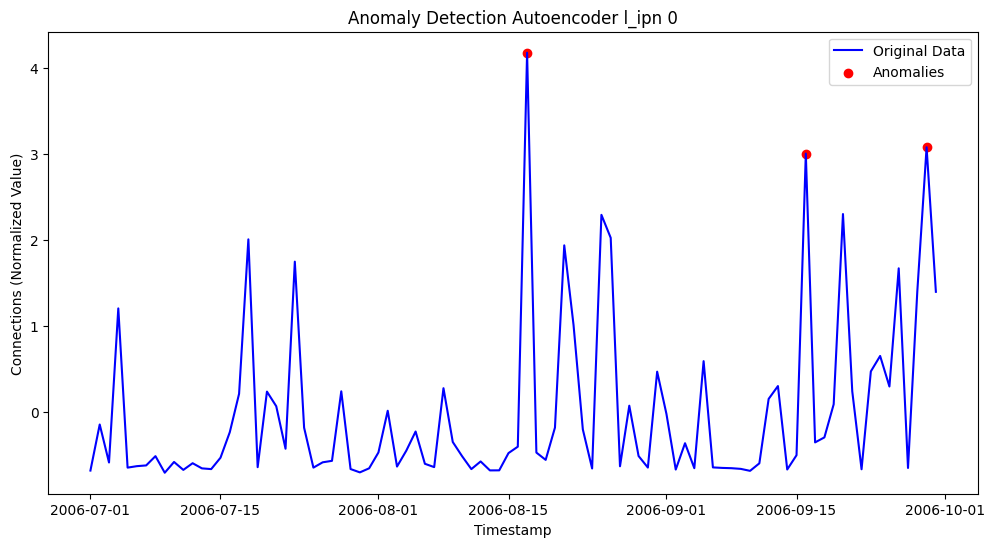

Anomaly Points:
         date  flows  normalized_value
47 2006-08-17   7488          4.173005
77 2006-09-16   5706          3.000970
90 2006-09-29   5818          3.074633
Epoch 1/50
2/2 [==============================] - 0s 4ms/step - loss: 1.2938
Epoch 2/50
2/2 [==============================] - 0s 5ms/step - loss: 1.2893
Epoch 3/50
2/2 [==============================] - 0s 6ms/step - loss: 1.2843
Epoch 4/50
2/2 [==============================] - 0s 3ms/step - loss: 1.2801
Epoch 5/50
2/2 [==============================] - 0s 3ms/step - loss: 1.2762
Epoch 6/50
2/2 [==============================] - 0s 4ms/step - loss: 1.2719
Epoch 7/50
2/2 [==============================] - 0s 7ms/step - loss: 1.2679
Epoch 8/50
2/2 [==============================] - 0s 4ms/step - loss: 1.2637
Epoch 9/50
2/2 [==============================] - 0s 4ms/step - loss: 1.2594
Epoch 10/50
2/2 [==============================] - 0s 3ms/step - loss: 1.2554
Epoch 11/50
2/2 [==============================] - 0s 4ms

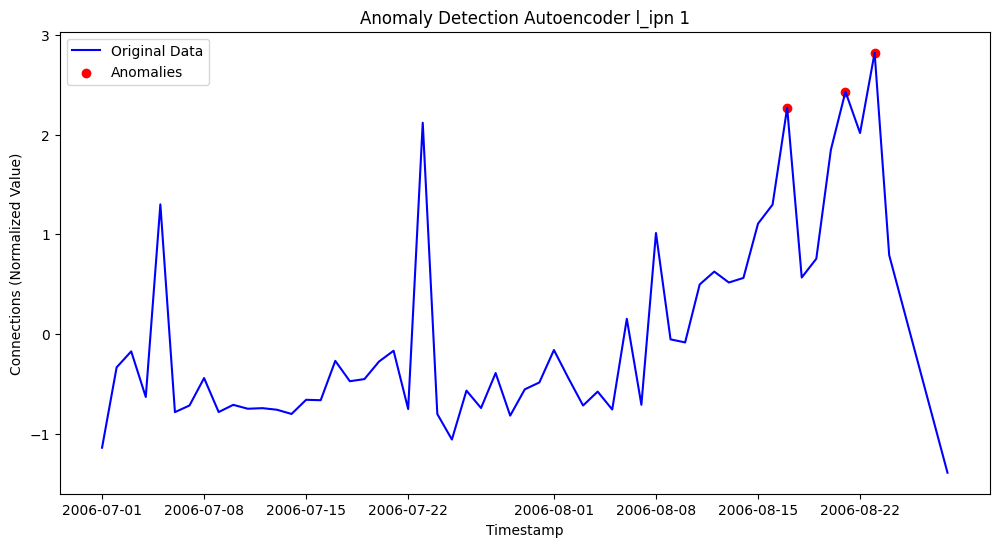

Anomaly Points:
         date  flows  normalized_value
47 2006-08-17   9190          2.268520
51 2006-08-21   9596          2.430230
53 2006-08-23  10574          2.819766
Epoch 1/50
3/3 [==============================] - 0s 4ms/step - loss: 1.0085
Epoch 2/50
3/3 [==============================] - 0s 3ms/step - loss: 1.0033
Epoch 3/50
3/3 [==============================] - 0s 3ms/step - loss: 0.9980
Epoch 4/50
3/3 [==============================] - 0s 3ms/step - loss: 0.9931
Epoch 5/50
3/3 [==============================] - 0s 3ms/step - loss: 0.9882
Epoch 6/50
3/3 [==============================] - 0s 3ms/step - loss: 0.9831
Epoch 7/50
3/3 [==============================] - 0s 3ms/step - loss: 0.9780
Epoch 8/50
3/3 [==============================] - 0s 5ms/step - loss: 0.9733
Epoch 9/50
3/3 [==============================] - 0s 3ms/step - loss: 0.9686
Epoch 10/50
3/3 [==============================] - 0s 2ms/step - loss: 0.9638
Epoch 11/50
3/3 [==============================] - 0s 2ms

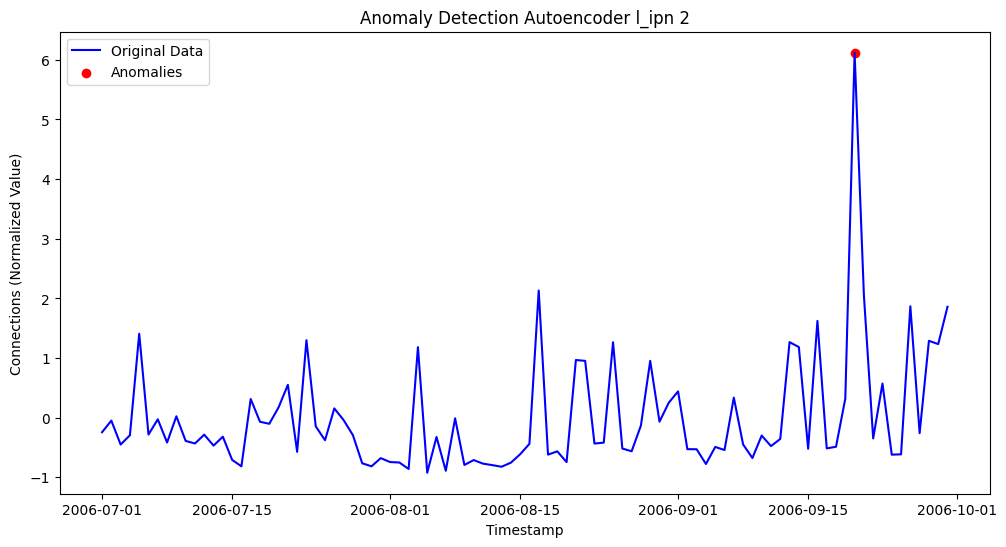

Anomaly Points:
         date  flows  normalized_value
81 2006-09-20  13421          6.119084
Epoch 1/50
3/3 [==============================] - 0s 2ms/step - loss: 1.1114
Epoch 2/50
3/3 [==============================] - 0s 4ms/step - loss: 1.1069
Epoch 3/50
3/3 [==============================] - 0s 2ms/step - loss: 1.1021
Epoch 4/50
3/3 [==============================] - 0s 3ms/step - loss: 1.0978
Epoch 5/50
3/3 [==============================] - 0s 3ms/step - loss: 1.0933
Epoch 6/50
3/3 [==============================] - 0s 2ms/step - loss: 1.0894
Epoch 7/50
3/3 [==============================] - 0s 3ms/step - loss: 1.0852
Epoch 8/50
3/3 [==============================] - 0s 3ms/step - loss: 1.0812
Epoch 9/50
3/3 [==============================] - 0s 3ms/step - loss: 1.0777
Epoch 10/50
3/3 [==============================] - 0s 4ms/step - loss: 1.0740
Epoch 11/50
3/3 [==============================] - 0s 3ms/step - loss: 1.0700
Epoch 12/50
3/3 [==============================] - 0s 6ms

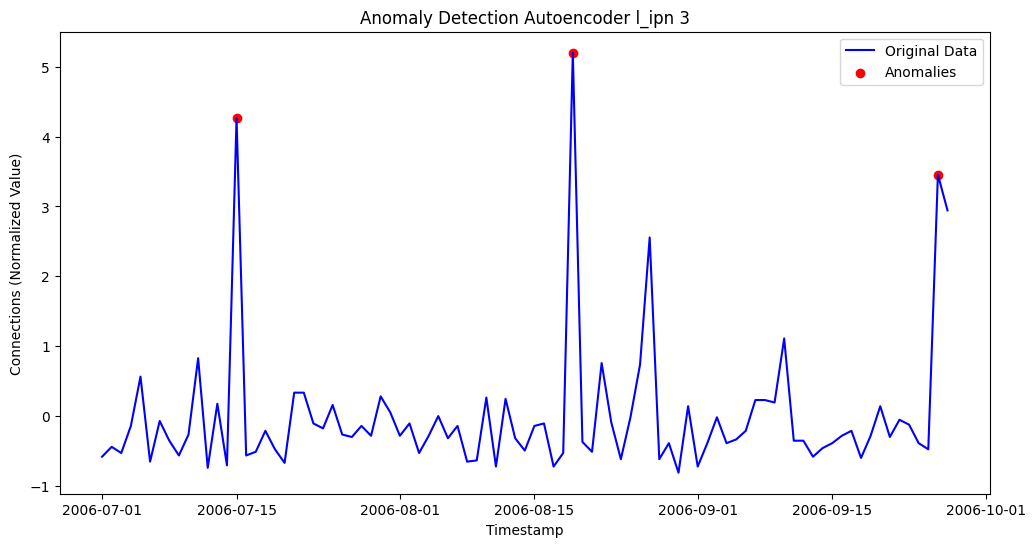

Anomaly Points:
         date  flows  normalized_value
14 2006-07-15    297          4.266914
49 2006-08-19    350          5.201794
87 2006-09-26    251          3.455509
Epoch 1/50
3/3 [==============================] - 0s 4ms/step - loss: 1.1062
Epoch 2/50
3/3 [==============================] - 0s 3ms/step - loss: 1.1028
Epoch 3/50
3/3 [==============================] - 0s 3ms/step - loss: 1.0999
Epoch 4/50
3/3 [==============================] - 0s 3ms/step - loss: 1.0969
Epoch 5/50
3/3 [==============================] - 0s 4ms/step - loss: 1.0938
Epoch 6/50
3/3 [==============================] - 0s 4ms/step - loss: 1.0908
Epoch 7/50
3/3 [==============================] - 0s 3ms/step - loss: 1.0877
Epoch 8/50
3/3 [==============================] - 0s 4ms/step - loss: 1.0847
Epoch 9/50
3/3 [==============================] - 0s 5ms/step - loss: 1.0816
Epoch 10/50
3/3 [==============================] - 0s 5ms/step - loss: 1.0784
Epoch 11/50
3/3 [==============================] - 0s 4ms

3/3 [==============================] - 0s 2ms/step


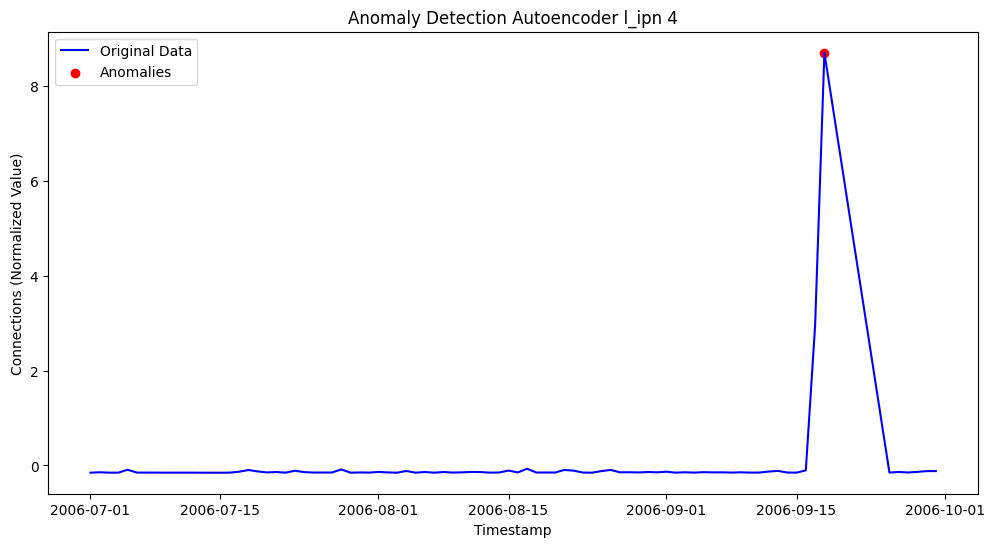

Anomaly Points:
         date   flows  normalized_value
79 2006-09-18  785297          8.698705
Epoch 1/50
3/3 [==============================] - 0s 3ms/step - loss: 1.4196
Epoch 2/50
3/3 [==============================] - 0s 3ms/step - loss: 1.4139
Epoch 3/50
3/3 [==============================] - 0s 2ms/step - loss: 1.4085
Epoch 4/50
3/3 [==============================] - 0s 3ms/step - loss: 1.4029
Epoch 5/50
3/3 [==============================] - 0s 3ms/step - loss: 1.3973
Epoch 6/50
3/3 [==============================] - 0s 3ms/step - loss: 1.3919
Epoch 7/50
3/3 [==============================] - 0s 3ms/step - loss: 1.3864
Epoch 8/50
3/3 [==============================] - 0s 3ms/step - loss: 1.3809
Epoch 9/50
3/3 [==============================] - 0s 3ms/step - loss: 1.3754
Epoch 10/50
3/3 [==============================] - 0s 3ms/step - loss: 1.3701
Epoch 11/50
3/3 [==============================] - 0s 3ms/step - loss: 1.3647
Epoch 12/50
3/3 [==============================] - 0s 3

3/3 [==============================] - 0s 2ms/step


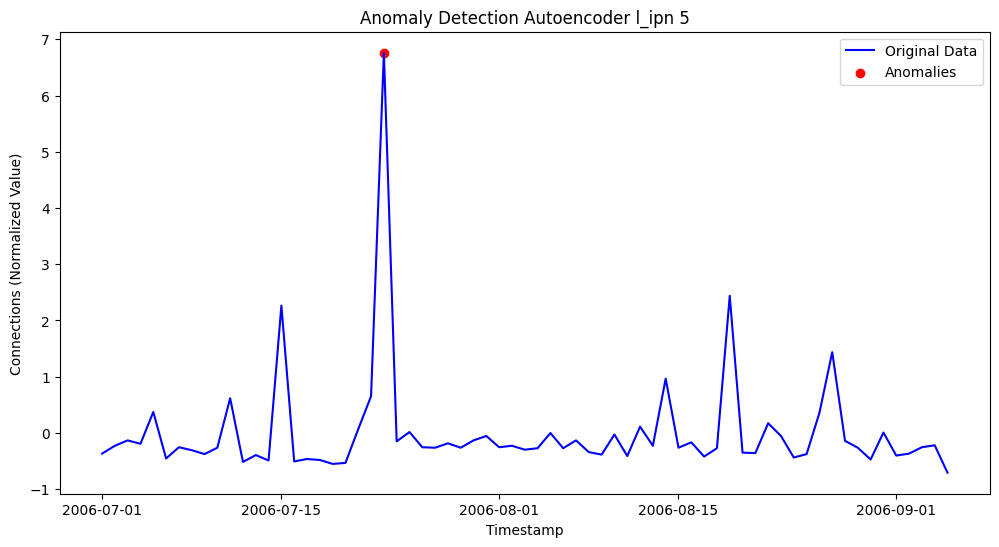

Anomaly Points:
         date  flows  normalized_value
22 2006-07-23    862          6.762116
Epoch 1/50
3/3 [==============================] - 0s 3ms/step - loss: 1.4083
Epoch 2/50
3/3 [==============================] - 0s 4ms/step - loss: 1.4040
Epoch 3/50
3/3 [==============================] - 0s 3ms/step - loss: 1.3995
Epoch 4/50
3/3 [==============================] - 0s 3ms/step - loss: 1.3950
Epoch 5/50
3/3 [==============================] - 0s 4ms/step - loss: 1.3908
Epoch 6/50
3/3 [==============================] - 0s 3ms/step - loss: 1.3865
Epoch 7/50
3/3 [==============================] - 0s 3ms/step - loss: 1.3820
Epoch 8/50
3/3 [==============================] - 0s 3ms/step - loss: 1.3777
Epoch 9/50
3/3 [==============================] - 0s 3ms/step - loss: 1.3734
Epoch 10/50
3/3 [==============================] - 0s 2ms/step - loss: 1.3690
Epoch 11/50
3/3 [==============================] - 0s 4ms/step - loss: 1.3647
Epoch 12/50
3/3 [==============================] - 0s 3ms

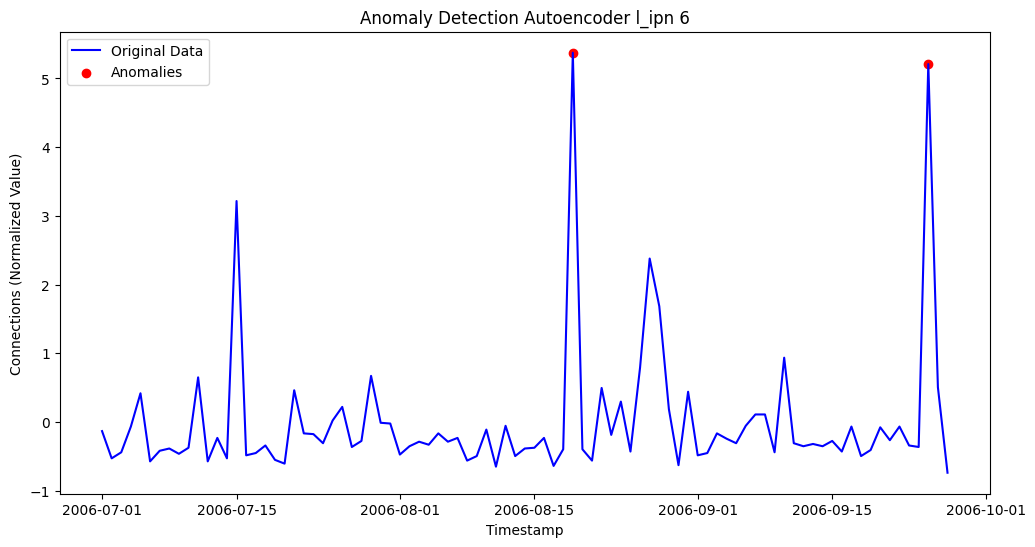

Anomaly Points:
         date  flows  normalized_value
49 2006-08-19    563          5.373863
86 2006-09-25    548          5.208686
Epoch 1/50
3/3 [==============================] - 0s 4ms/step - loss: 1.3417
Epoch 2/50
3/3 [==============================] - 0s 4ms/step - loss: 1.3318
Epoch 3/50
3/3 [==============================] - 0s 3ms/step - loss: 1.3223
Epoch 4/50
3/3 [==============================] - 0s 3ms/step - loss: 1.3121
Epoch 5/50
3/3 [==============================] - 0s 3ms/step - loss: 1.3029
Epoch 6/50
3/3 [==============================] - 0s 2ms/step - loss: 1.2931
Epoch 7/50
3/3 [==============================] - 0s 3ms/step - loss: 1.2832
Epoch 8/50
3/3 [==============================] - 0s 3ms/step - loss: 1.2735
Epoch 9/50
3/3 [==============================] - 0s 3ms/step - loss: 1.2644
Epoch 10/50
3/3 [==============================] - 0s 3ms/step - loss: 1.2546
Epoch 11/50
3/3 [==============================] - 0s 3ms/step - loss: 1.2449
Epoch 12/50
3/3 [=

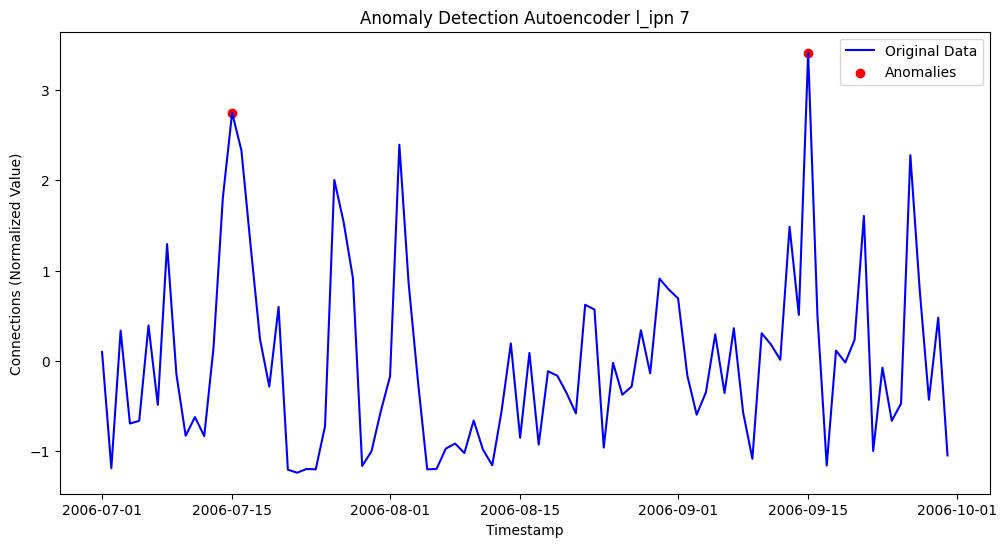

Anomaly Points:
         date  flows  normalized_value
14 2006-07-15   1116          2.746669
76 2006-09-15   1293          3.411158
Epoch 1/50
3/3 [==============================] - 0s 3ms/step - loss: 1.1363
Epoch 2/50
3/3 [==============================] - 0s 5ms/step - loss: 1.1286
Epoch 3/50
3/3 [==============================] - 0s 3ms/step - loss: 1.1195
Epoch 4/50
3/3 [==============================] - 0s 3ms/step - loss: 1.1132
Epoch 5/50
3/3 [==============================] - 0s 3ms/step - loss: 1.1073
Epoch 6/50
3/3 [==============================] - 0s 3ms/step - loss: 1.0996
Epoch 7/50
3/3 [==============================] - 0s 3ms/step - loss: 1.0928
Epoch 8/50
3/3 [==============================] - 0s 3ms/step - loss: 1.0870
Epoch 9/50
3/3 [==============================] - 0s 3ms/step - loss: 1.0802
Epoch 10/50
3/3 [==============================] - 0s 3ms/step - loss: 1.0744
Epoch 11/50
3/3 [==============================] - 0s 4ms/step - loss: 1.0680
Epoch 12/50
3/3 [=

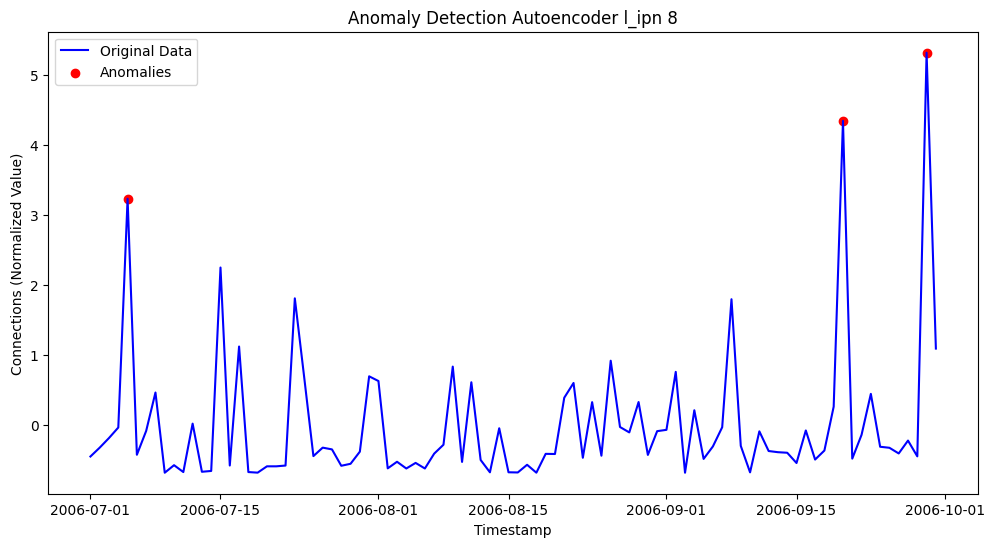

Anomaly Points:
         date  flows  normalized_value
4  2006-07-05   7456          3.234164
81 2006-09-20   9573          4.347553
90 2006-09-29  11426          5.322097
Epoch 1/50
3/3 [==============================] - 0s 3ms/step - loss: 1.6191
Epoch 2/50
3/3 [==============================] - 0s 2ms/step - loss: 1.6088
Epoch 3/50
3/3 [==============================] - 0s 4ms/step - loss: 1.5986
Epoch 4/50
3/3 [==============================] - 0s 3ms/step - loss: 1.5883
Epoch 5/50
3/3 [==============================] - 0s 3ms/step - loss: 1.5786
Epoch 6/50
3/3 [==============================] - 0s 3ms/step - loss: 1.5682
Epoch 7/50
3/3 [==============================] - 0s 3ms/step - loss: 1.5578
Epoch 8/50
3/3 [==============================] - 0s 2ms/step - loss: 1.5476
Epoch 9/50
3/3 [==============================] - 0s 2ms/step - loss: 1.5371
Epoch 10/50
3/3 [==============================] - 0s 2ms/step - loss: 1.5267
Epoch 11/50
3/3 [==============================] - 0s 3ms

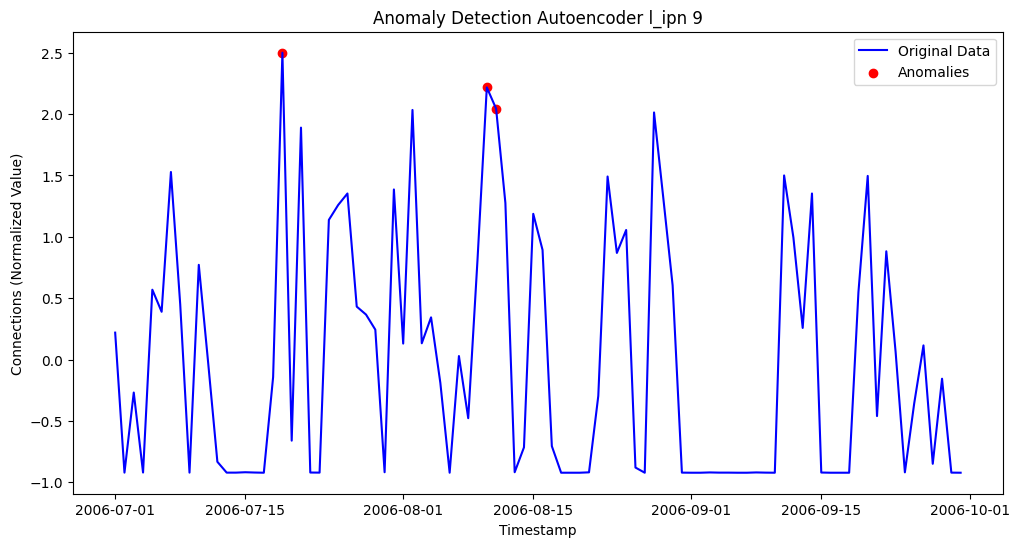

Anomaly Points:
         date  flows  normalized_value
18 2006-07-19   4378          2.499146
40 2006-08-10   4017          2.216826
41 2006-08-11   3796          2.043994


In [ ]:
for i in range(df['l_ipn'].nunique()):
    perform_autoenc(get_daily_aggregate_l_ipn(i))

# ARIMA

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
def perform_arima(data):

    timestamp_column = 'date'
    value_column = 'flows'

    # Feature engineering: Normalize the value column
    scaler = StandardScaler()
    data['normalized_value'] = scaler.fit_transform(data[[value_column]])

    # Split the data into training and testing sets
    train_size = int(0.8 * len(data))
    train_data, test_data = data.iloc[:train_size], data.iloc[train_size:]

    # Fit ARIMA model
    order = (1, 1, 1)  # ARIMA order (p, d, q)
    model = ARIMA(train_data['normalized_value'], order=order)
    fit_model = model.fit()

    # Predict on the test set
    predictions = fit_model.forecast(steps=len(test_data))

    # Calculate residuals (difference between actual and predicted values)
    residuals = test_data['normalized_value'] - predictions

    # Set a threshold for anomaly detection
    threshold = 2.0

    # Identify anomalies based on the threshold
    anomalies = test_data[np.abs(residuals) > threshold]

    # Visualize anomalies
    plt.figure(figsize=(12, 6))
    plt.plot(data[timestamp_column], data['normalized_value'], label='Original Data', color='blue')
    plt.plot(test_data[timestamp_column], predictions, label='Predictions', color='green')
    plt.scatter(anomalies[timestamp_column], anomalies['normalized_value'], label='Anomalies', color='red')
    plt.title('Anomaly Detection ARIMA l_ipn %i' %i)
    plt.xlabel('Timestamp')
    plt.ylabel('Connections (Normalized Value)')
    plt.legend()
    plt.show()

    # Display details of anomaly points
    print("Anomaly Points:")
    print(anomalies)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


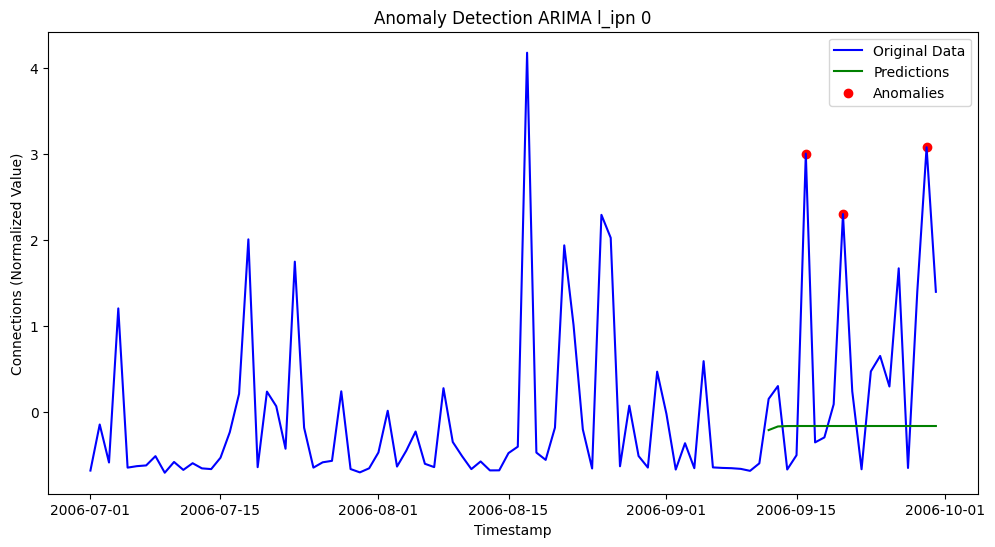

Anomaly Points:
         date  flows  normalized_value
77 2006-09-16   5706          3.000970
81 2006-09-20   4638          2.298538
90 2006-09-29   5818          3.074633


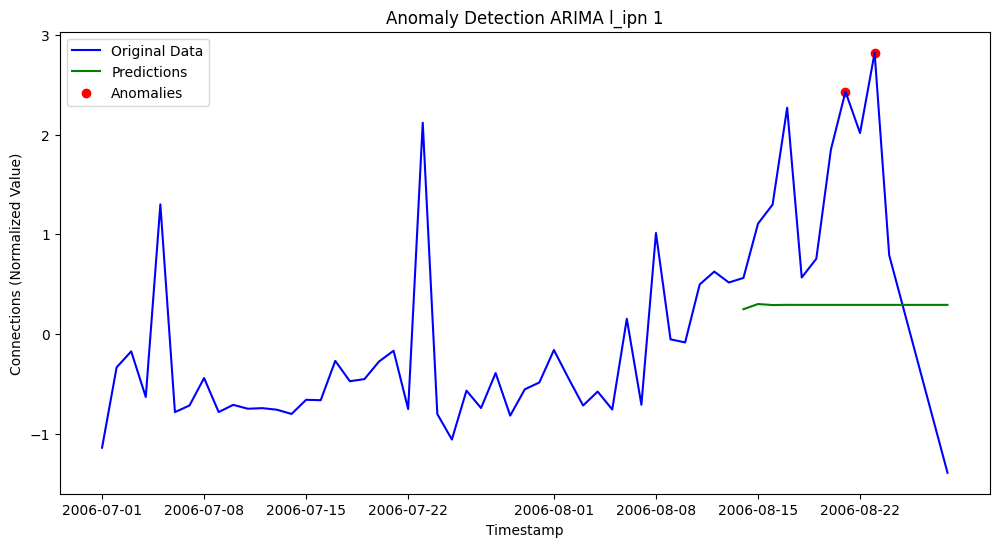

Anomaly Points:
         date  flows  normalized_value
51 2006-08-21   9596          2.430230
53 2006-08-23  10574          2.819766


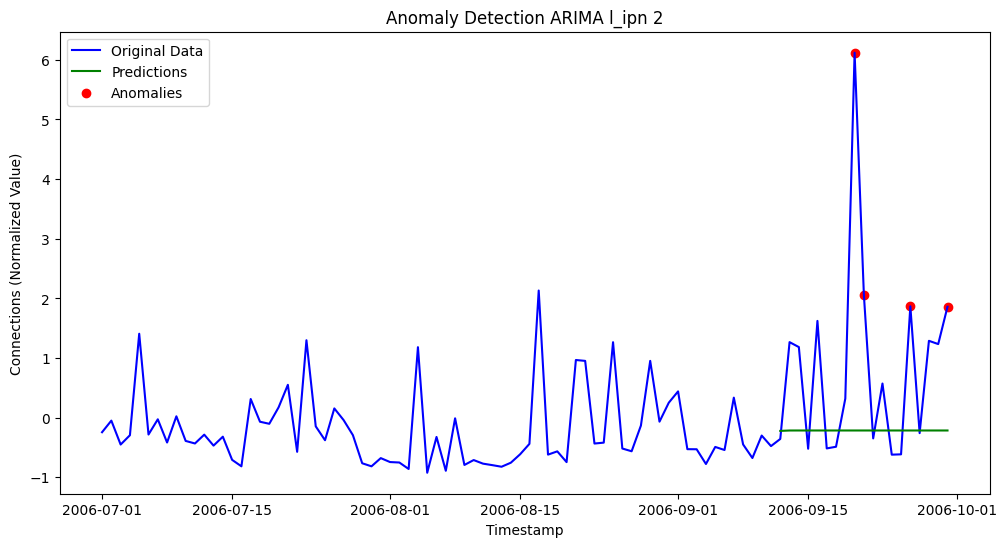

Anomaly Points:
         date  flows  normalized_value
81 2006-09-20  13421          6.119084
82 2006-09-21   5920          2.054932
87 2006-09-26   5574          1.867464
91 2006-09-30   5560          1.859879


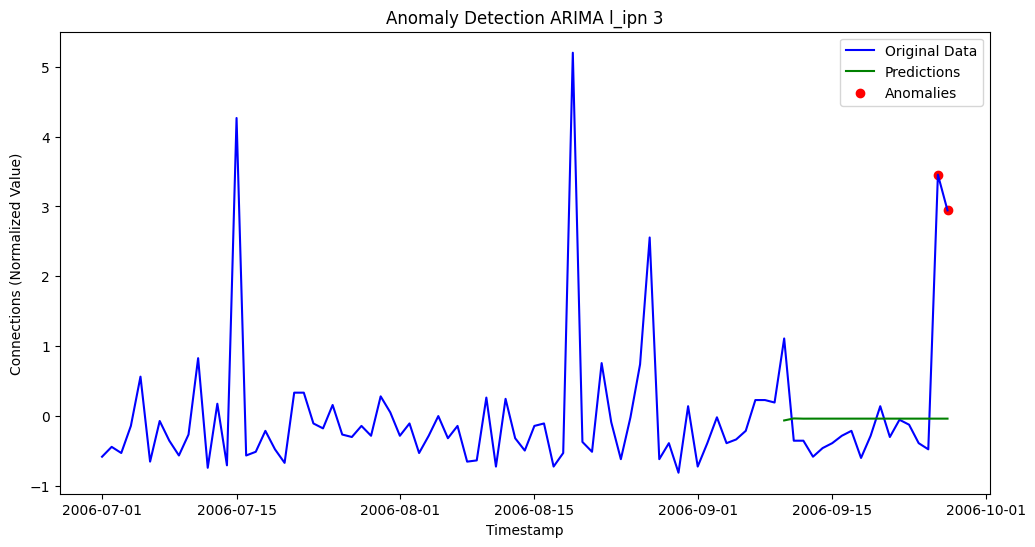

Anomaly Points:
         date  flows  normalized_value
87 2006-09-26    251          3.455509
88 2006-09-27    222          2.943970


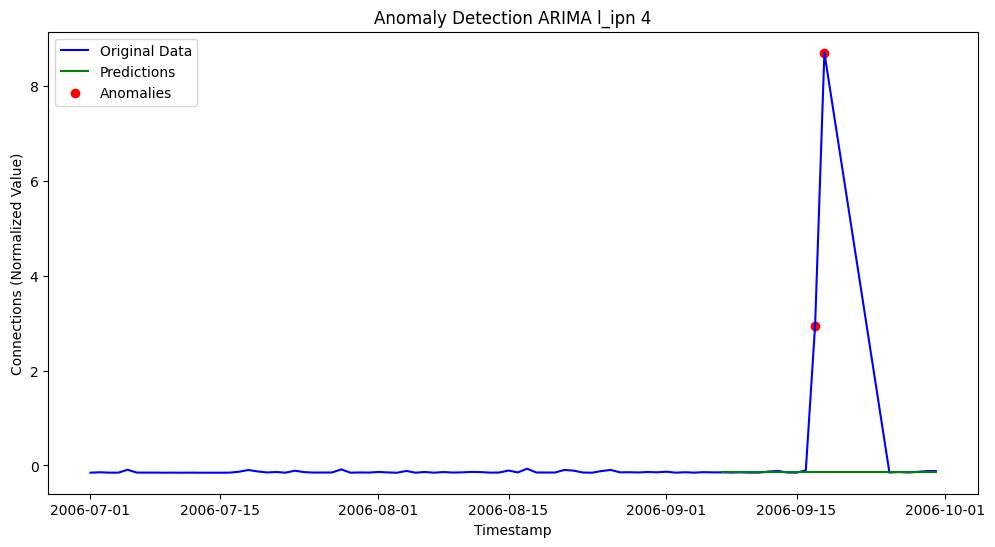

Anomaly Points:
         date   flows  normalized_value
78 2006-09-17  275140          2.947621
79 2006-09-18  785297          8.698705


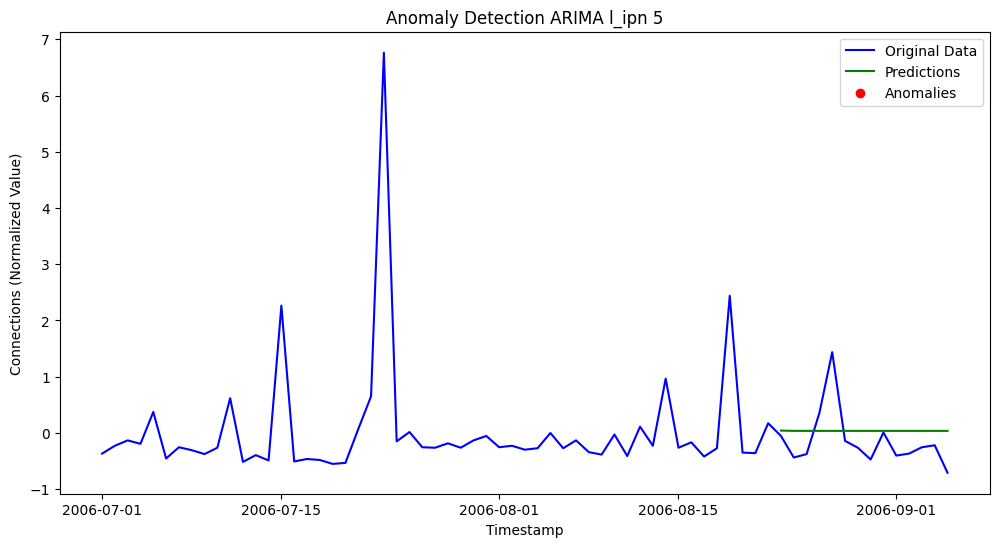

Anomaly Points:
Empty DataFrame
Columns: [date, flows, normalized_value]
Index: []


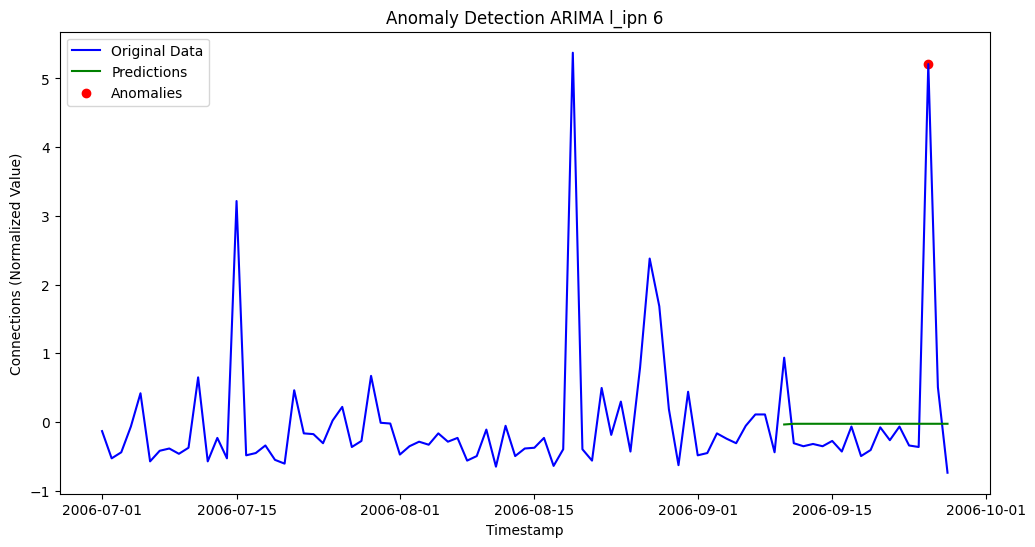

Anomaly Points:
         date  flows  normalized_value
86 2006-09-25    548          5.208686


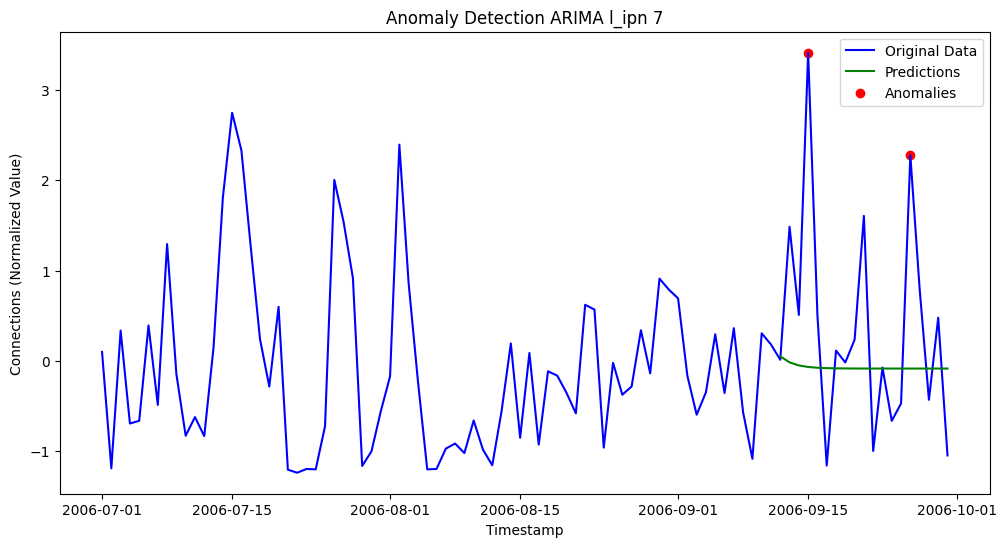

Anomaly Points:
         date  flows  normalized_value
76 2006-09-15   1293          3.411158
87 2006-09-26    991          2.277397


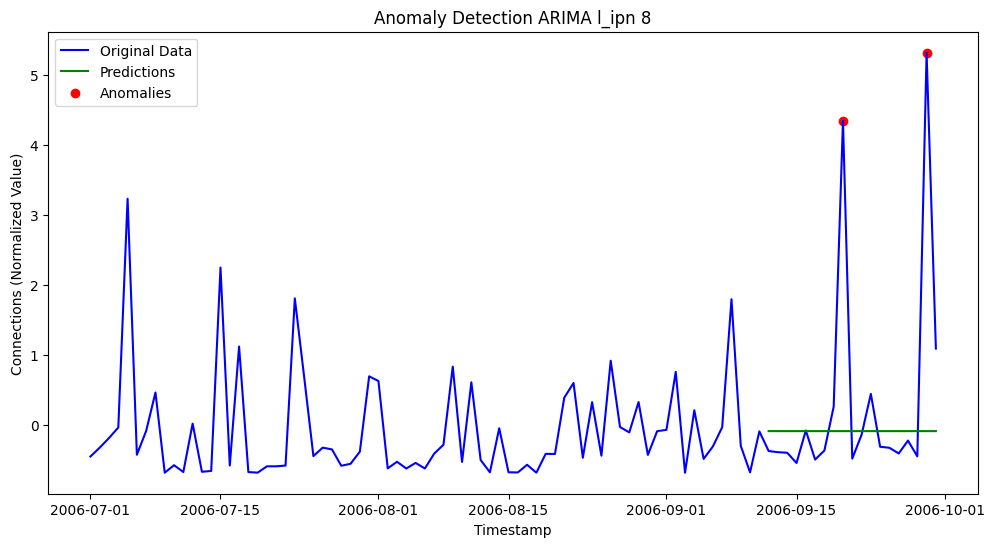

Anomaly Points:
         date  flows  normalized_value
81 2006-09-20   9573          4.347553
90 2006-09-29  11426          5.322097


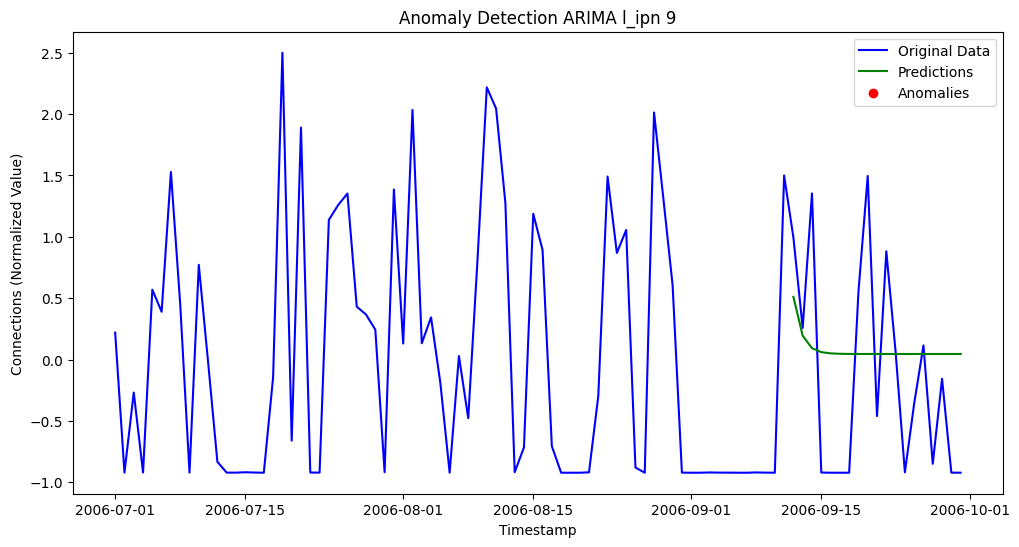

Anomaly Points:
Empty DataFrame
Columns: [date, flows, normalized_value]
Index: []


In [ ]:
for i in range(df['l_ipn'].nunique()):
    perform_arima(get_daily_aggregate_l_ipn(i))

# Prophet

In [ ]:
from prophet import Prophet

In [ ]:
def get_Prophet_forecast(data,in_l_ipn):

    # Rename columns to match Prophet's requirements
    data = data.rename(columns={'date': 'ds', 'flows': 'y'})

    # Initialize and train Prophet model
    model = Prophet(seasonality_mode='additive', daily_seasonality=False, yearly_seasonality=False, weekly_seasonality=True)
    model.fit(data)

    # Generate a forecast
    forecast = model.predict(pd.DataFrame(data['ds']))

    # Identify anomalies (check if the actual value is outside the predicted lower or upper bounds)
    data['anomaly'] = 0
    p_color = np.full((data.shape[0], 1), 'green')
    for i in range(forecast.shape[0]):
        if (forecast.at[i, 'yhat_lower'] > data.at[i, 'y']) or (forecast.at[i, 'yhat_upper'] < data.at[i, 'y']):
            data.at[i, 'anomaly'] = -1
            p_color[i] = 'red'

    # Plot the Prophet forecast
    model.plot(forecast)

    # Visualize the actual data points and any anomalies
    plt.scatter(data['ds'], data['y'], c=p_color.ravel())
    plt.scatter(data[data['anomaly'] == -1]['ds'], data[data['anomaly'] == -1]['y'], c='red', label='Anomalies')
    plt.title('Anomaly Detection Prophet l_ipn %d' %in_l_ipn)
    plt.xlabel('Timestamp')
    plt.ylabel('Connections')
    plt.legend()
    plt.show()

    # Identify anomalies
    anomalies = data[data['anomaly'] == -1]
    anomalies = anomalies.rename(columns={'ds': 'date', 'y': 'flows'})

    # Display details of anomaly points
    print('Anomaly Points:')
    print(anomalies)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpt_rypc9c/jf3_os33.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt_rypc9c/bu0wquwb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26750', 'data', 'file=/tmp/tmpt_rypc9c/jf3_os33.json', 'init=/tmp/tmpt_rypc9c/bu0wquwb.json', 'output', 'file=/tmp/tmpt_rypc9c/prophet_modellhg5lryk/prophet_model-20240205075920.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:59:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:59:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


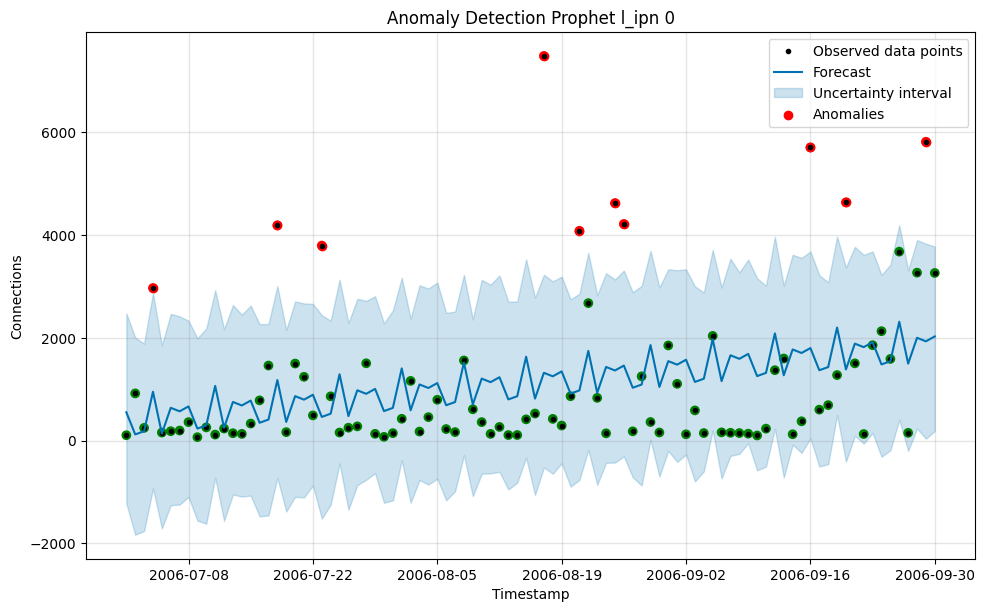

DEBUG:cmdstanpy:input tempfile: /tmp/tmpt_rypc9c/b70nwd9g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt_rypc9c/t8wpt_vx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23057', 'data', 'file=/tmp/tmpt_rypc9c/b70nwd9g.json', 'init=/tmp/tmpt_rypc9c/t8wpt_vx.json', 'output', 'file=/tmp/tmpt_rypc9c/prophet_modelr1d0cub5/prophet_model-20240205075921.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:59:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Anomaly Points:
         date  flows  anomaly
3  2006-07-04   2971       -1
17 2006-07-18   4191       -1
22 2006-07-23   3797       -1
47 2006-08-17   7488       -1
51 2006-08-21   4085       -1
55 2006-08-25   4624       -1
56 2006-08-26   4218       -1
77 2006-09-16   5706       -1
81 2006-09-20   4638       -1
90 2006-09-29   5818       -1


07:59:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


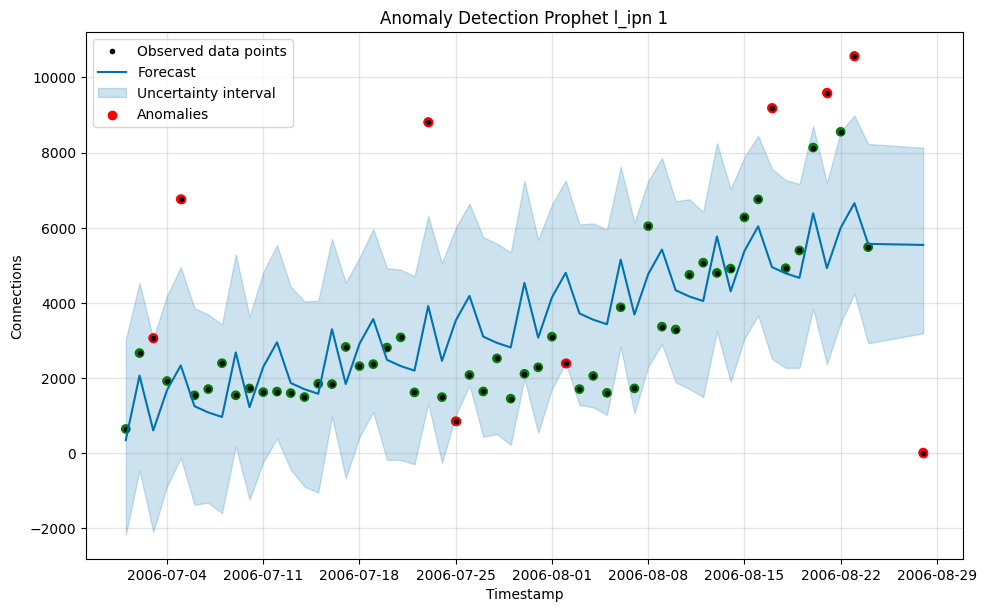

DEBUG:cmdstanpy:input tempfile: /tmp/tmpt_rypc9c/2h6nkurb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt_rypc9c/ihz1mu0u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25659', 'data', 'file=/tmp/tmpt_rypc9c/2h6nkurb.json', 'init=/tmp/tmpt_rypc9c/ihz1mu0u.json', 'output', 'file=/tmp/tmpt_rypc9c/prophet_model00fw3oaa/prophet_model-20240205075922.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:59:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Anomaly Points:
         date  flows  anomaly
2  2006-07-03   3063       -1
4  2006-07-05   6760       -1
22 2006-07-23   8813       -1
24 2006-07-25    846       -1
32 2006-08-02   2385       -1
47 2006-08-17   9190       -1
51 2006-08-21   9596       -1
53 2006-08-23  10574       -1
55 2006-08-28     11       -1


07:59:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


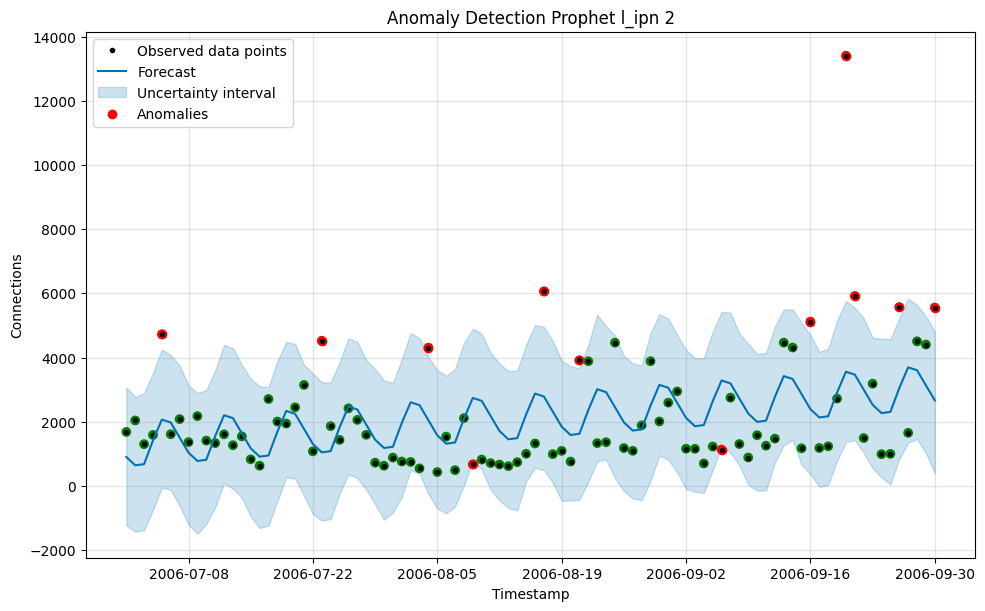

DEBUG:cmdstanpy:input tempfile: /tmp/tmpt_rypc9c/mxz97e_m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt_rypc9c/q2x1t7wr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15422', 'data', 'file=/tmp/tmpt_rypc9c/mxz97e_m.json', 'init=/tmp/tmpt_rypc9c/q2x1t7wr.json', 'output', 'file=/tmp/tmpt_rypc9c/prophet_modele4de4h1c/prophet_model-20240205075924.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:59:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Anomaly Points:
         date  flows  anomaly
4  2006-07-05   4725       -1
22 2006-07-23   4524       -1
34 2006-08-04   4309       -1
39 2006-08-09    664       -1
47 2006-08-17   6062       -1
51 2006-08-21   3912       -1
67 2006-09-06   1127       -1
77 2006-09-16   5122       -1
81 2006-09-20  13421       -1
82 2006-09-21   5920       -1
87 2006-09-26   5574       -1
91 2006-09-30   5560       -1


07:59:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


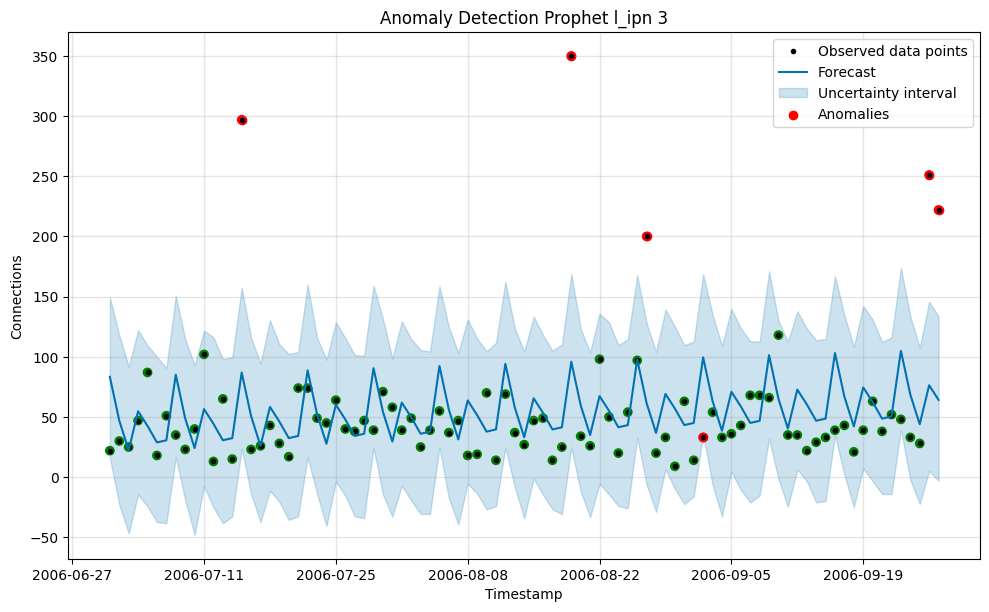

DEBUG:cmdstanpy:input tempfile: /tmp/tmpt_rypc9c/7ss3mxeg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt_rypc9c/7brz70dp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14397', 'data', 'file=/tmp/tmpt_rypc9c/7ss3mxeg.json', 'init=/tmp/tmpt_rypc9c/7brz70dp.json', 'output', 'file=/tmp/tmpt_rypc9c/prophet_modelnno2399p/prophet_model-20240205075924.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:59:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Anomaly Points:
         date  flows  anomaly
14 2006-07-15    297       -1
49 2006-08-19    350       -1
57 2006-08-27    200       -1
63 2006-09-02     33       -1
87 2006-09-26    251       -1
88 2006-09-27    222       -1


07:59:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


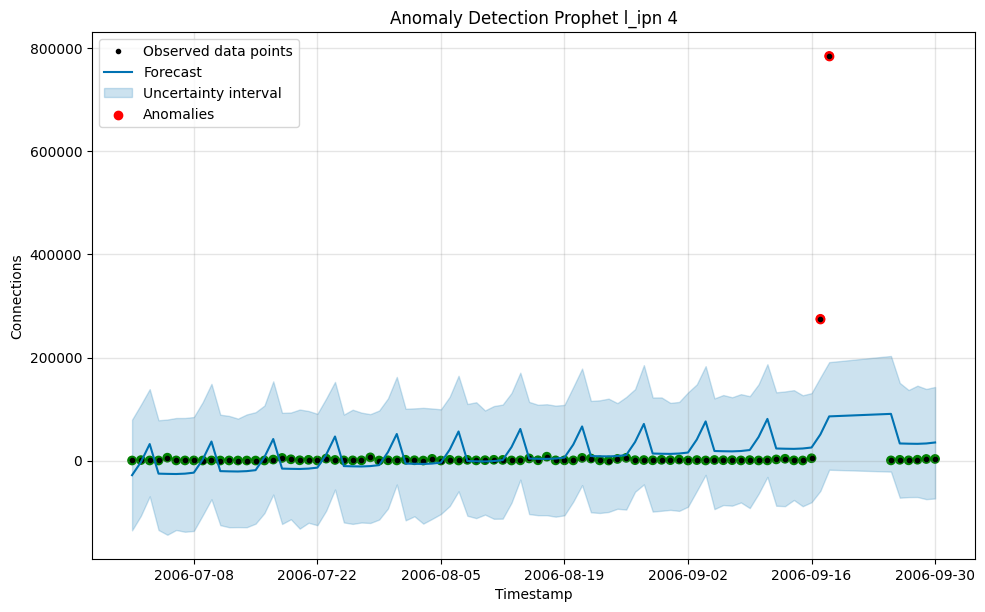

DEBUG:cmdstanpy:input tempfile: /tmp/tmpt_rypc9c/axgic3bx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt_rypc9c/xo9s1iel.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32538', 'data', 'file=/tmp/tmpt_rypc9c/axgic3bx.json', 'init=/tmp/tmpt_rypc9c/xo9s1iel.json', 'output', 'file=/tmp/tmpt_rypc9c/prophet_modelio5rq8fj/prophet_model-20240205075925.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:59:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:59:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Anomaly Points:
         date   flows  anomaly
78 2006-09-17  275140       -1
79 2006-09-18  785297       -1


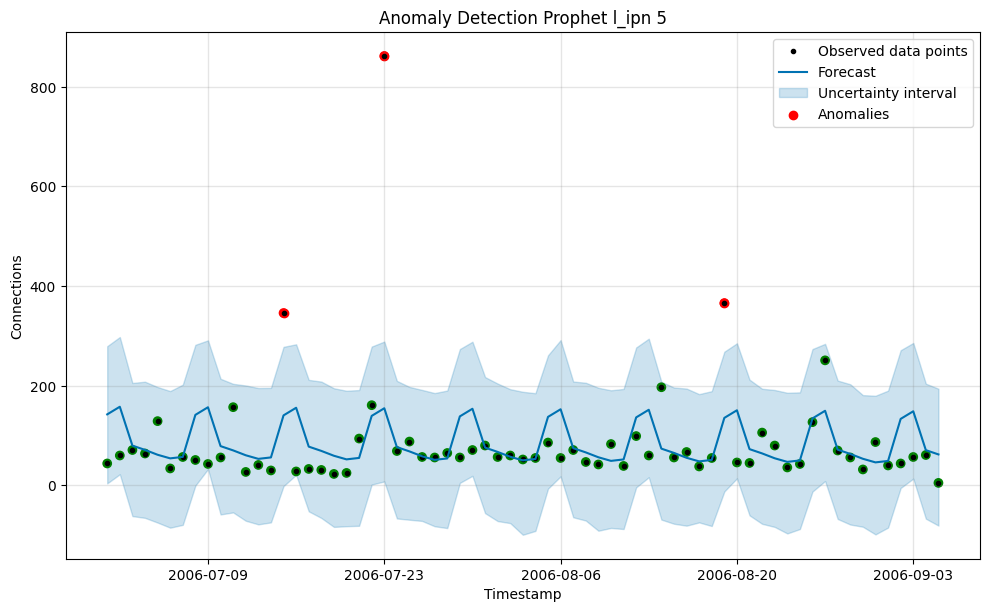

DEBUG:cmdstanpy:input tempfile: /tmp/tmpt_rypc9c/924nz95e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt_rypc9c/f4e3n7ps.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80910', 'data', 'file=/tmp/tmpt_rypc9c/924nz95e.json', 'init=/tmp/tmpt_rypc9c/f4e3n7ps.json', 'output', 'file=/tmp/tmpt_rypc9c/prophet_model6ax0x1ja/prophet_model-20240205075926.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:59:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Anomaly Points:
         date  flows  anomaly
14 2006-07-15    346       -1
22 2006-07-23    862       -1
49 2006-08-19    366       -1


07:59:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


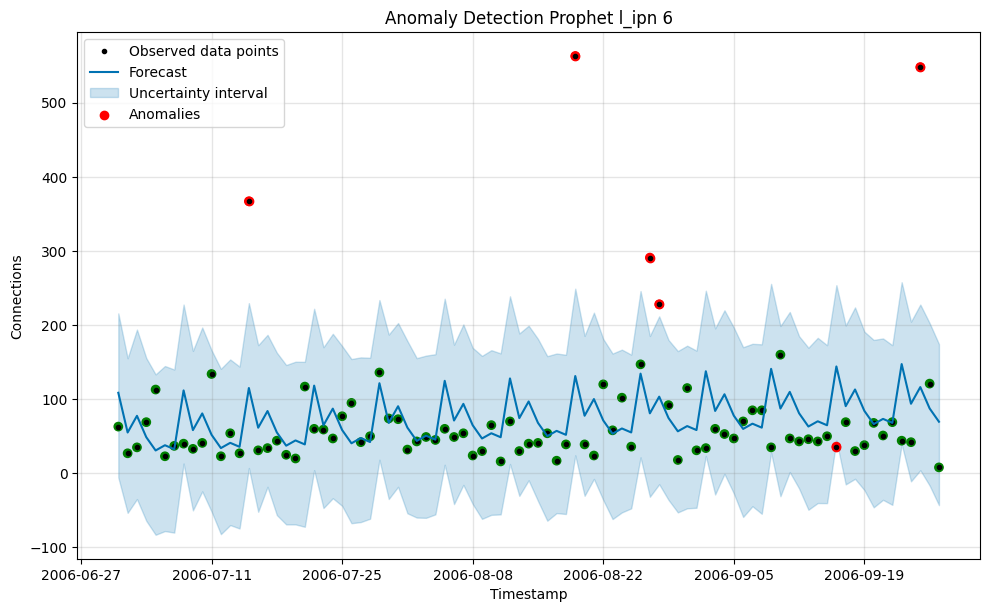

DEBUG:cmdstanpy:input tempfile: /tmp/tmpt_rypc9c/0qhvyrj2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt_rypc9c/em3c2dyf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97304', 'data', 'file=/tmp/tmpt_rypc9c/0qhvyrj2.json', 'init=/tmp/tmpt_rypc9c/em3c2dyf.json', 'output', 'file=/tmp/tmpt_rypc9c/prophet_model9822fvpp/prophet_model-20240205075926.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:59:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:59:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Anomaly Points:
         date  flows  anomaly
14 2006-07-15    367       -1
49 2006-08-19    563       -1
57 2006-08-27    291       -1
58 2006-08-28    228       -1
77 2006-09-16     36       -1
86 2006-09-25    548       -1


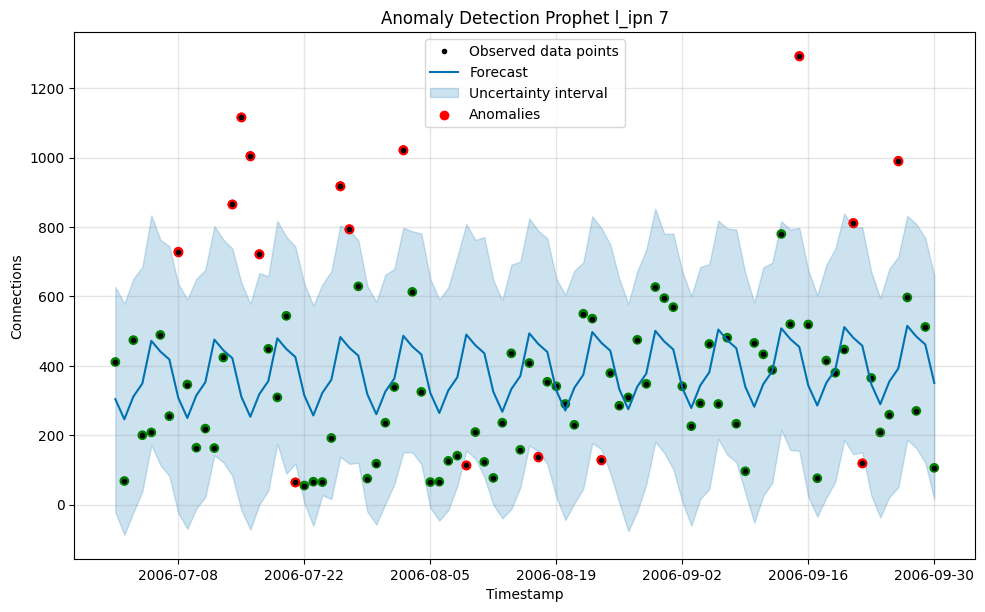

DEBUG:cmdstanpy:input tempfile: /tmp/tmpt_rypc9c/pi4n7x2v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt_rypc9c/odgkqywt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86824', 'data', 'file=/tmp/tmpt_rypc9c/pi4n7x2v.json', 'init=/tmp/tmpt_rypc9c/odgkqywt.json', 'output', 'file=/tmp/tmpt_rypc9c/prophet_modelx8vtzspw/prophet_model-20240205075927.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:59:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Anomaly Points:
         date  flows  anomaly
7  2006-07-08    729       -1
13 2006-07-14    865       -1
14 2006-07-15   1116       -1
15 2006-07-16   1005       -1
16 2006-07-17    722       -1
20 2006-07-21     64       -1
25 2006-07-26    918       -1
26 2006-07-27    794       -1
32 2006-08-02   1022       -1
39 2006-08-09    113       -1
47 2006-08-17    138       -1
54 2006-08-24    129       -1
76 2006-09-15   1293       -1
82 2006-09-21    812       -1
83 2006-09-22    119       -1
87 2006-09-26    991       -1


07:59:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


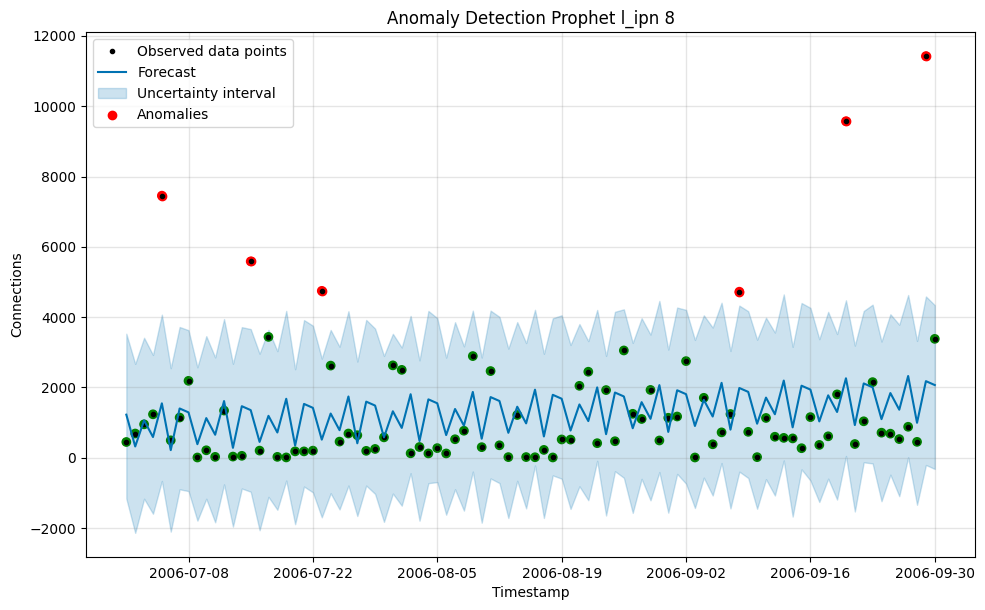

DEBUG:cmdstanpy:input tempfile: /tmp/tmpt_rypc9c/vo59im1o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt_rypc9c/yavjhiwl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43768', 'data', 'file=/tmp/tmpt_rypc9c/vo59im1o.json', 'init=/tmp/tmpt_rypc9c/yavjhiwl.json', 'output', 'file=/tmp/tmpt_rypc9c/prophet_modelc1x_g7vx/prophet_model-20240205075928.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:59:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:59:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Anomaly Points:
         date  flows  anomaly
4  2006-07-05   7456       -1
14 2006-07-15   5586       -1
22 2006-07-23   4748       -1
69 2006-09-08   4724       -1
81 2006-09-20   9573       -1
90 2006-09-29  11426       -1


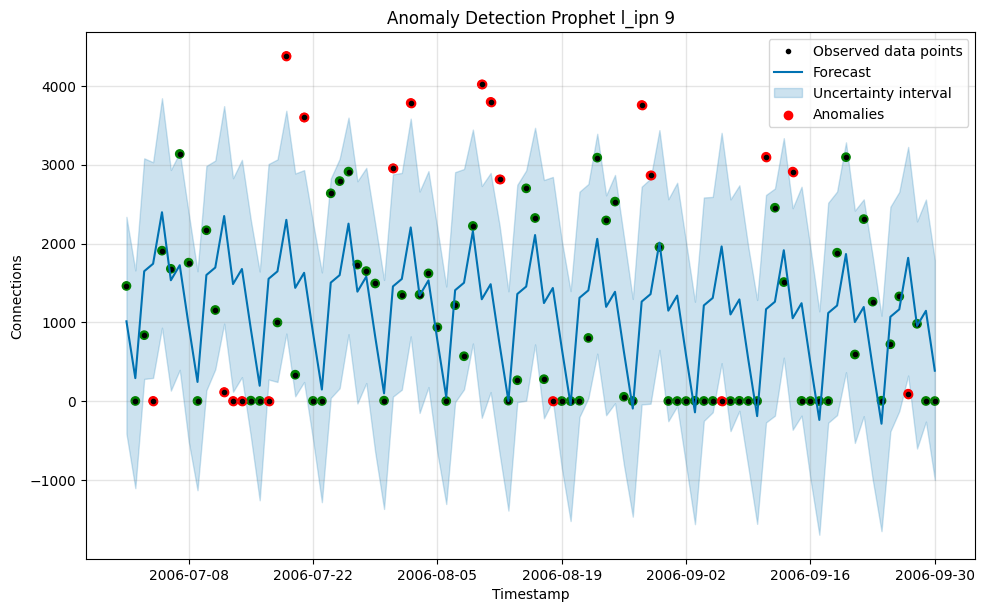

Anomaly Points:
         date  flows  anomaly
3  2006-07-04      6       -1
11 2006-07-12    118       -1
12 2006-07-13      5       -1
13 2006-07-14      5       -1
16 2006-07-17      4       -1
18 2006-07-19   4378       -1
20 2006-07-21   3598       -1
30 2006-07-31   2954       -1
32 2006-08-02   3782       -1
40 2006-08-10   4017       -1
41 2006-08-11   3796       -1
42 2006-08-12   2813       -1
48 2006-08-18      4       -1
58 2006-08-28   3756       -1
59 2006-08-29   2863       -1
67 2006-09-06      4       -1
72 2006-09-11   3100       -1
75 2006-09-14   2912       -1
88 2006-09-27     97       -1


In [ ]:
for i in range(df['l_ipn'].nunique()):
    get_Prophet_forecast(get_daily_aggregate_l_ipn(i),i)

# Luminol

In [ ]:
!pip install luminol
import luminol
from luminol.anomaly_detector import AnomalyDetector

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 824.5/824.5 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for future: filename=future-0.16.0-py3-none-any.whl size=487794 sha256=77d357dd105b58b092e597135a0950634d46992f5ec8905c26f35574c37c5bb3
  Stored in directory: /root/.cache/pip/wheels/99/10/cf/94af142fb7fe16e7327b17dc4d6d69ed041f8ec74b1fef10b2
Successfully built future
  Attempting uninstall: future
    Found existing installation: future 0.18.3
    Uninstalling future-0.18.3:
      Successfully uninstalled future-0.18.3


Patch the asscalar method in NumPy to make Luminol work

In [ ]:
def patch_asscalar(a):
    return a.item()

setattr(np, "asscalar", patch_asscalar)

In [ ]:
def get_luminol_anomalies(data):

    # Initialize a new column to mark anomalies (0 for normal, 1 for anomaly)
    data['isAnomaly'] = 0

    # Create an AnomalyDetector using Luminol
    detector = AnomalyDetector(data['y'].to_dict())

    # Get the list of anomalies detected by Luminol
    anomalies = detector.get_anomalies()

    # Mark anomalies in the dataset
    time_period = ()
    for j in range(len(anomalies)):
        time_period = anomalies[j].get_time_window()
        for k in time_period:
            data.at[k,'isAnomaly'] = 1

    return(data)

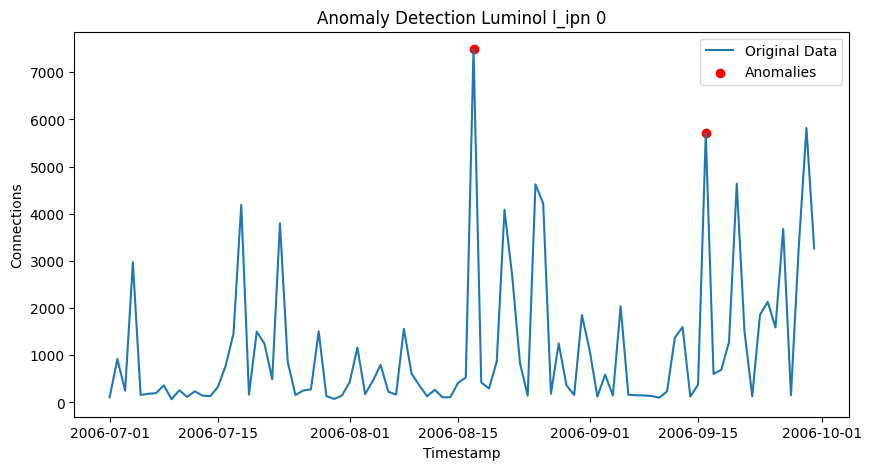

Anomaly Points:
         date  flows  isAnomaly
47 2006-08-17   7488          1
77 2006-09-16   5706          1


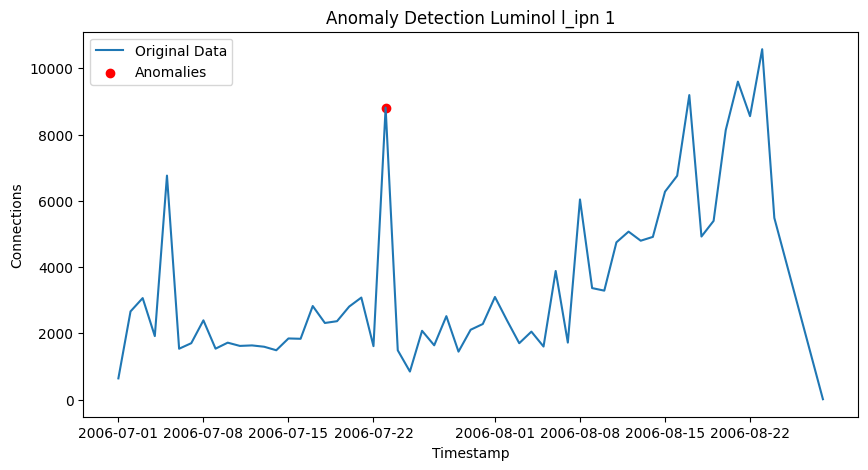

Anomaly Points:
         date  flows  isAnomaly
22 2006-07-23   8813          1


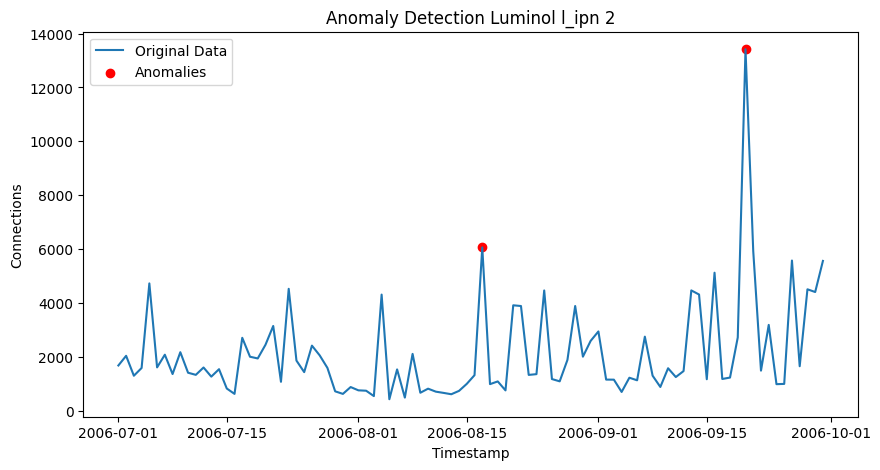

Anomaly Points:
         date  flows  isAnomaly
47 2006-08-17   6062          1
81 2006-09-20  13421          1


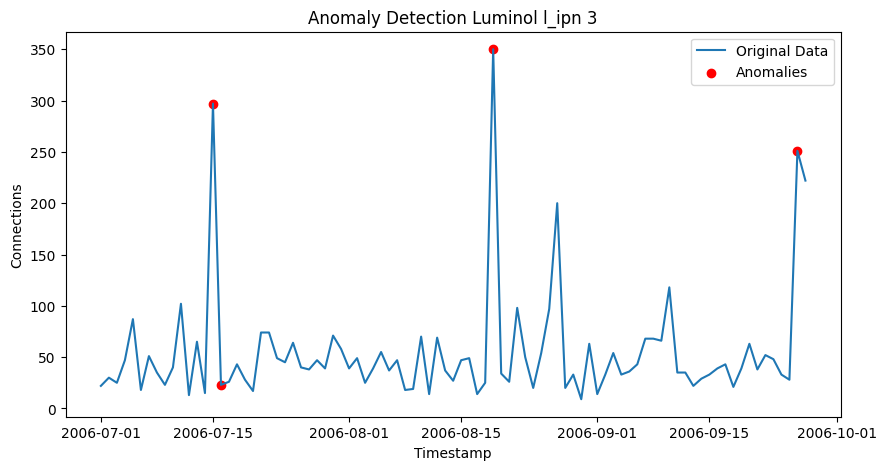

Anomaly Points:
         date  flows  isAnomaly
14 2006-07-15    297          1
15 2006-07-16     23          1
49 2006-08-19    350          1
87 2006-09-26    251          1


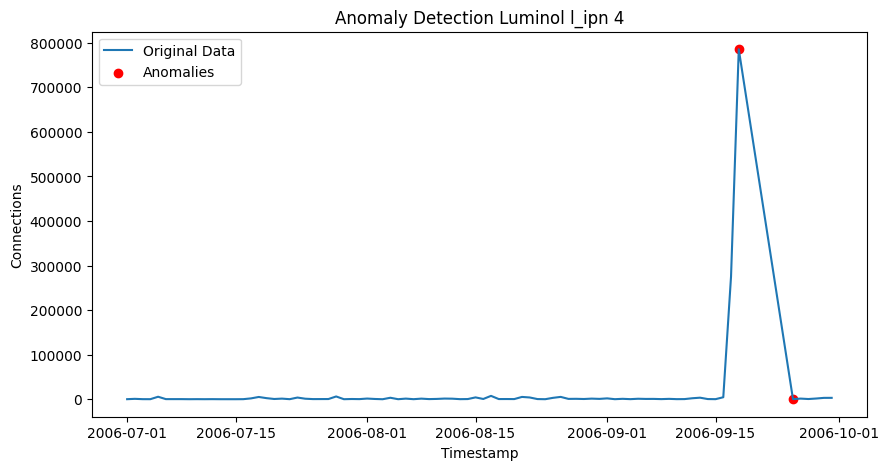

Anomaly Points:
         date   flows  isAnomaly
79 2006-09-18  785297          1
80 2006-09-25     387          1


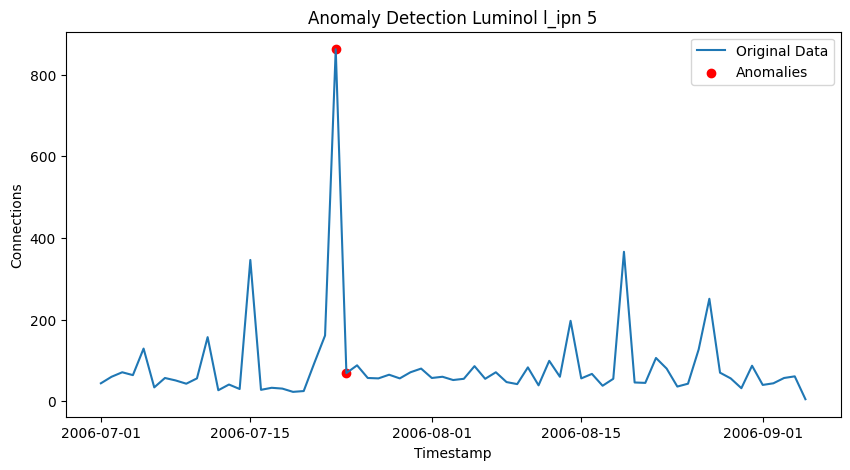

Anomaly Points:
         date  flows  isAnomaly
22 2006-07-23    862          1
23 2006-07-24     69          1


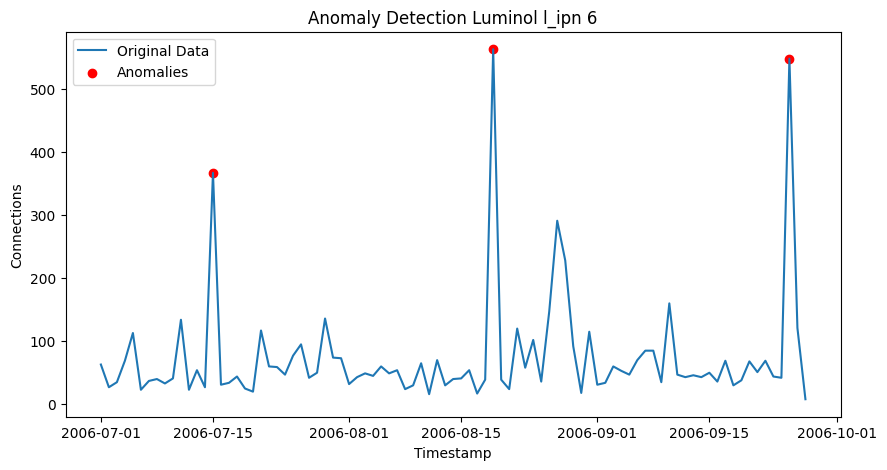

Anomaly Points:
         date  flows  isAnomaly
14 2006-07-15    367          1
49 2006-08-19    563          1
86 2006-09-25    548          1


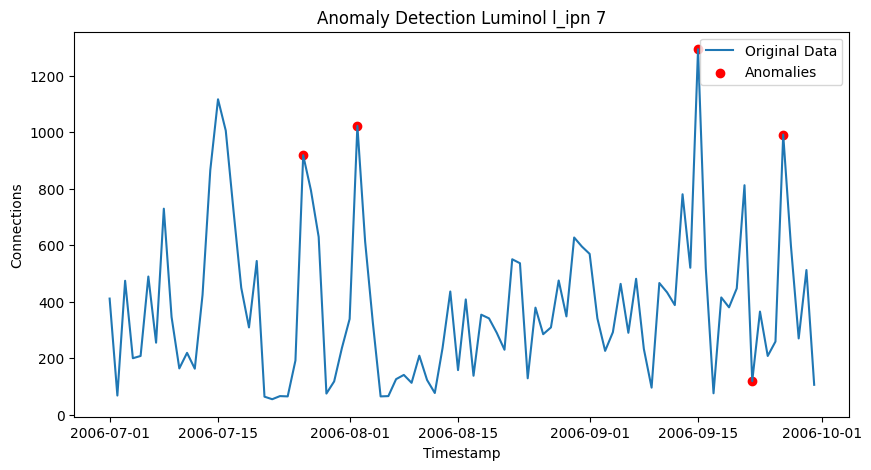

Anomaly Points:
         date  flows  isAnomaly
25 2006-07-26    918          1
32 2006-08-02   1022          1
76 2006-09-15   1293          1
83 2006-09-22    119          1
87 2006-09-26    991          1


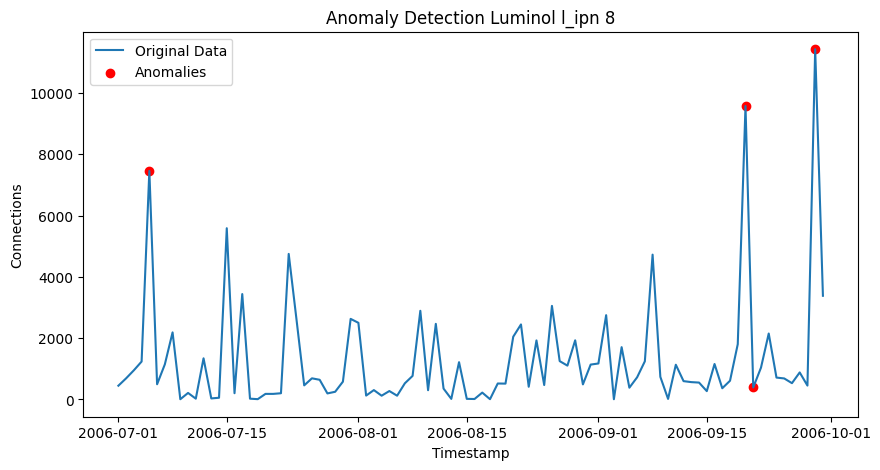

Anomaly Points:
         date  flows  isAnomaly
4  2006-07-05   7456          1
81 2006-09-20   9573          1
82 2006-09-21    390          1
90 2006-09-29  11426          1


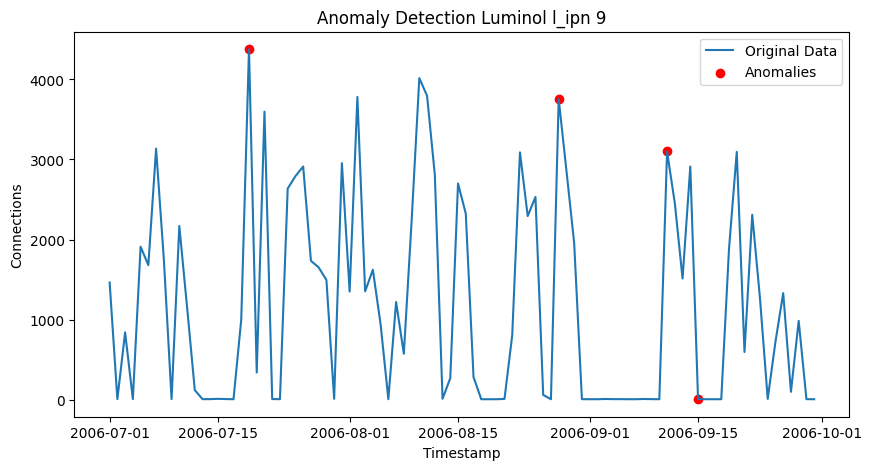

Anomaly Points:
         date  flows  isAnomaly
18 2006-07-19   4378          1
58 2006-08-28   3756          1
72 2006-09-11   3100          1
76 2006-09-15      6          1


In [ ]:
for i in range(df['l_ipn'].nunique()):

    # Apply Luminol anomaly detection
    t_df = get_luminol_anomalies(get_daily_aggregate_l_ipn(i).rename(columns={'date': 'ds', 'flows': 'y'}))


    # Plot the time series data with anomalies highlighted
    plt.figure(figsize=(10,5))
    plt.plot(t_df['ds'],t_df['y'], label='Original Data')
    plt.scatter(t_df[t_df['isAnomaly'] == 1]['ds'], t_df[t_df['isAnomaly'] == 1]['y'], c='red', label='Anomalies')
    plt.title('Anomaly Detection Luminol l_ipn %d' %i)
    plt.xlabel('Timestamp')
    plt.ylabel('Connections')
    plt.legend()
    plt.show()

    # Identify anomalies
    anomalies = t_df[t_df['isAnomaly'] == 1]
    anomalies = anomalies.rename(columns={'ds': 'date', 'y': 'flows'})

    # Display details of anomaly points
    print('Anomaly Points:')
    print(anomalies)